In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from dtw import *
from scipy.stats import percentileofscore
from sklearn.metrics import auc

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Analyzing bbr data

In [2]:
# Collating bbr data
ap_bbr = pd.read_csv('bucket_data/ap_bbr.csv')
eu_bbr = pd.read_csv('bucket_data/eu_bbr.csv')
us_bbr = pd.read_csv('bucket_data/us_bbr.csv')

ap_bbr['project_id'] = ap_bbr['project_id'].astype(str).str.lower()
eu_bbr['project_id'] = eu_bbr['project_id'].astype(str).str.lower()
us_bbr['project_id'] = us_bbr['project_id'].astype(str).str.lower()

ap_bbr['interval_start'] = pd.to_datetime(ap_bbr['interval_start'])
eu_bbr['interval_start'] = pd.to_datetime(eu_bbr['interval_start'])
us_bbr['interval_start'] = pd.to_datetime(us_bbr['interval_start'])

## Downloads

#### Duplicates of suspected download cancellations

As per discussion with Ben, inline=0 and settled=0 could indicate a cheater who didn't proceed with the upload/downlaod once they checked the list of node operators that Storj gives them. This cross-checking and cancellation process needs to be intentional as the user would need to tweak the open-source command line program. Hence, wallets that have such records are suspected as cheaters.

In [3]:
# Finding duplicates of such downloads
# Ben confirmed that these duplicates should be interpreted as multiple independent occurences
ap_bbr_dlsusdf = ap_bbr[(ap_bbr['inline']==0) & (ap_bbr['settled']==0) & (ap_bbr['action']==2)]
ap_bbr_dlsusdf[ap_bbr_dlsusdf.duplicated(subset=['interval_start','action','inline','settled','project_id'], keep=False)].sort_values(by=['project_id','interval_start','action']).iloc[:,1:]

interval_start  action  inline  settled  \
109237 2020-10-03 16:00:00       2       0        0   
109821 2020-10-03 16:00:00       2       0        0   
109298 2020-10-13 05:00:00       2       0        0   
110068 2020-10-13 05:00:00       2       0        0   
110182 2020-10-13 05:00:00       2       0        0   
...                    ...     ...     ...      ...   
99982  2020-10-22 12:00:00       2       0        0   
109399 2020-10-22 12:00:00       2       0        0   
113551 2021-02-09 11:00:00       2       0        0   
115402 2021-02-09 11:00:00       2       0        0   
115430 2021-02-09 11:00:00       2       0        0   

                              project_id  
109237  50ce9633c7ab4abd9c12c9be63d6665e  
109821  50ce9633c7ab4abd9c12c9be63d6665e  
109298  50ce9633c7ab4abd9c12c9be63d6665e  
110068  50ce9633c7ab4abd9c12c9be63d6665e  
110182  50ce9633c7ab4abd9c12c9be63d6665e  
...                                  ...  
99982   d2adb8afbe11450f92eb17715cc18312  
109399  d2adb8afbe11450f92eb17715cc18312  
113551  d2adb8afbe11450f92eb17715cc18312  
115402  d2adb8afbe11450f92eb17715cc18312  
115430  d2adb8afbe11450f92eb17715cc18312  

[228 rows x 5 columns]

This notebook contains most of the exploration stage (exploring regions and various options of template patterns) which causes it to be long. To jump to the final result production, please search and jump to the section titled **"All Regions Results (Using Template Candidate 7)"**.

### Asia Pacific Region Data (ap_bbr)

In [24]:
ap_bbr['month'] = ap_bbr['interval_start'].dt.to_period('M')
ap_bbr_dlsuscount = ap_bbr[(ap_bbr['inline']==0) & (ap_bbr['settled']==0) & (ap_bbr['action']==2)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
ap_bbr_dlsuscount = ap_bbr_dlsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'dl_cancel_count'}, axis=1).reset_index(drop=True)
ap_bbr_dlsuscount

project_id  dl_cancel_count
0    50ce9633c7ab4abd9c12c9be63d6665e              125
1    879379eb3543450ba03b7b5e7c222265               93
2    ade3539d50d3420fbb7e916e1d2b9dad               32
3    067b9a1733c34739be924eb447bd1e81               21
4    6a9e3daf41a348c2838669f4d8075f94               20
..                                ...              ...
204  7b107ea981db41de99708d19414171fd                1
205  7e0b58c50a964bc8a6139aa556ebdb8d                1
206  7fba3d90663e42a19e852c2ba4c7acbc                1
207  80b49049734949499a2ddcb328554d1e                1
208  817ed8f3d5724902810a5d1f9a6d8875                1

[209 rows x 2 columns]

In [481]:
# ap_bbr_dlsuscount = ap_bbr[(ap_bbr['inline']==0) & (ap_bbr['settled']==0) & (ap_bbr['action']==2)].groupby('project_id').agg({'interval_start':'count'}).sort_values(by='interval_start', ascending=False)
# ap_bbr_dlsuscount = ap_bbr_dlsuscount.rename({'interval_start': 'dl_cancel_count'}, axis=1).reset_index()
# ap_bbr_dlsuscount

project_id  dl_cancel_count
0    50ce9633c7ab4abd9c12c9be63d6665e              241
1    879379eb3543450ba03b7b5e7c222265              179
2    59eddba1ef384f98baa61486ca1e9e30               44
3    88391e289bea4dd6875c47de7f4b9f4e               35
4    067b9a1733c34739be924eb447bd1e81               33
..                                ...              ...
204  69352b5e9ee7416e9a708f4a72cdd444                1
205  69a353f2ac9e4c3eb81e38f7cb9a10e5                1
206  69d85e47154f4733a08c9a885319fd80                1
207  6a9bb29a0ca34842bd91ddb87d071ea1                1
208  821fd55f5df8474588a5d20e2b84654e                1

[209 rows x 2 columns]

In [25]:
ap_bbr_dlsuscount['dl_cancel_count'].value_counts()

1      133
2       28
3       16
4        9
5        9
9        2
17       1
93       1
32       1
21       1
20       1
10       1
16       1
11       1
8        1
7        1
6        1
125      1
Name: dl_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [26]:
# Narrowing down ap_bbr for future plotting purpose
ap_bbr = ap_bbr.groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index()
ap_bbr_download = ap_bbr[ap_bbr['action']==2][['project_id', 'interval_start', 'settled']]
ap_bbr_download

project_id      interval_start       settled
3      62397406ab88417e81ceb8de2809b08d 2020-06-16 14:00:00    5011919360
4      c2958c3bbd9645fbb2a420c93dd6abc1 2020-06-16 14:00:00  375467558400
5      fb1375d48401410e929461049b8b079c 2020-06-16 14:00:00             0
12     62397406ab88417e81ceb8de2809b08d 2020-06-16 15:00:00    5013709056
13     c2958c3bbd9645fbb2a420c93dd6abc1 2020-06-16 15:00:00  388187763712
...                                 ...                 ...           ...
97138  6a9e3daf41a348c2838669f4d8075f94 2021-06-11 13:00:00             0
97139  7bac41c5befc4fdea13b0dce59ef230f 2021-06-11 13:00:00             0
97140  879379eb3543450ba03b7b5e7c222265 2021-06-11 13:00:00        925184
97141  967f7da291834ce48f6576c9aac7b1bc 2021-06-11 13:00:00          4096
97142  b995bf3226af45d18c58bf9f789f7ed8 2021-06-11 13:00:00     754521088

[35558 rows x 3 columns]

In [27]:
# Focusing first on projects with more than 3 times download cancellations
ap_bbr_dlsusproj1 = ap_bbr_dlsuscount[ap_bbr_dlsuscount['dl_cancel_count']>3]
ap_bbr_dlsusproj1

project_id  dl_cancel_count
0   50ce9633c7ab4abd9c12c9be63d6665e              125
1   879379eb3543450ba03b7b5e7c222265               93
2   ade3539d50d3420fbb7e916e1d2b9dad               32
3   067b9a1733c34739be924eb447bd1e81               21
4   6a9e3daf41a348c2838669f4d8075f94               20
5   88391e289bea4dd6875c47de7f4b9f4e               17
6   59eddba1ef384f98baa61486ca1e9e30               16
7   30855481e4bb4b34906843c4c7a89889               11
8   967f7da291834ce48f6576c9aac7b1bc               10
9   6f118a8cc64d42e08864ea6d7d72087c                9
10  34a8efb11b724a2ea3207898c25fb827                9
11  a10ea36b98734016b1b027857872f527                8
12  9056c7beff894e5fb4a5941efd63f58d                7
13  324b8fc203af41aa895a42200fe775df                6
14  a6294aab3a8e4049981a5b761ff8f726                5
15  a797a711006a4e698bbe75bd072ac8d7                5
16  8895320c53fd4f74a545e024f5e6ef3c                5
17  5423d6fb966d4669b3385d8090e5b301                5
18  8d5d6591474e4bd893eeccf4e77b6179                5
19  e473d8a6070e47b1a2f4380f86d871e3                5
20  c2958c3bbd9645fbb2a420c93dd6abc1                5
21  e8d7ae1aeff745c2927e06c114c1998d                5
22  24f54428460c43c89d49ca759baf59cc                5
23  e16778fa96684816a92e2930778fdaa1                4
24  76cf211ee6be4f9eb8704ef7a7fd8755                4
25  72fbc6516a7a4bc0b699471eb67325d9                4
26  deacc77697ce446c9e29e1737bf37248                4
27  b23d22e872264e93ae1d71a3c6808ed0                4
28  7e089301f17042228ca4d0f101112c73                4
29  b995bf3226af45d18c58bf9f789f7ed8                4
30  2eaed972ef6744d6b93c16216582dd9f                4
31  d2adb8afbe11450f92eb17715cc18312                4

In [28]:
ap_bbr_dlsusproj1_df = ap_bbr_download[ap_bbr_download['project_id'].isin(list(ap_bbr_dlsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
ap_bbr_dlsusproj1_df = ap_bbr_dlsusproj1_df[list(ap_bbr_dlsusproj1['project_id'])]
ap_bbr_dlsusproj1_df

project_id           50ce9633c7ab4abd9c12c9be63d6665e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           879379eb3543450ba03b7b5e7c222265  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                        13322240.0   
2021-06-11 10:00:00                          466176.0   
2021-06-11 11:00:00                         3284224.0   
2021-06-11 12:00:00                         4547840.0   
2021-06-11 13:00:00                          925184.0   

project_id           ade3539d50d3420fbb7e916e1d2b9dad  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           067b9a1733c34739be924eb447bd1e81  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           6a9e3daf41a348c2838669f4d8075f94  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                        16481280.0   
2021-06-11 11:00:00                          222720.0   
2021-06-11 12:00:00                               0.0   
2021-06-11 13:00:00                               0.0   

project_id           88391e289bea4dd6875c47de7f4b9f4e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


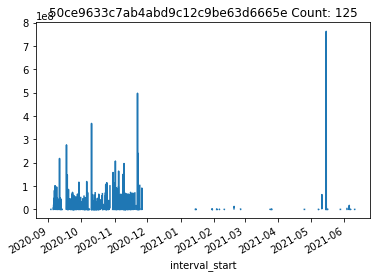

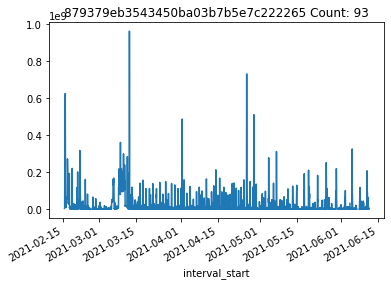

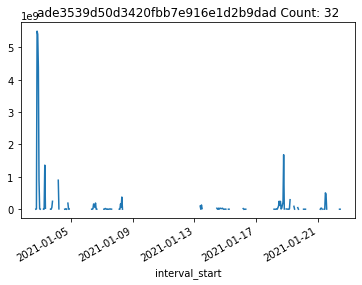

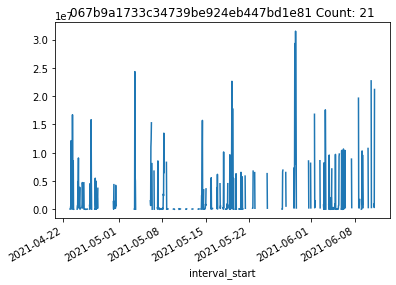

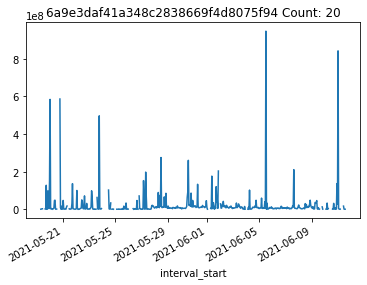

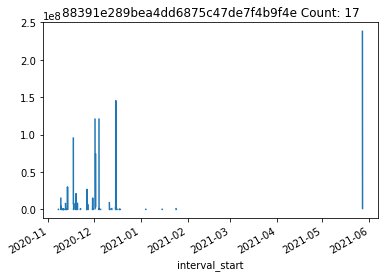

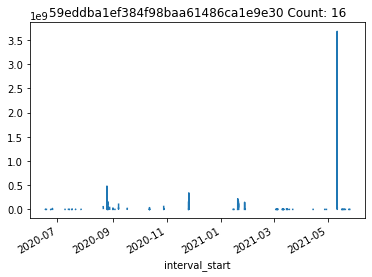

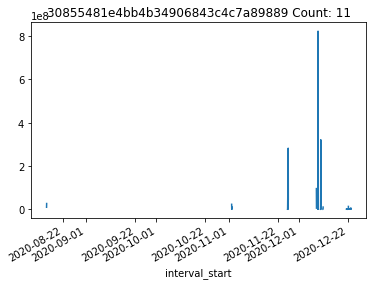

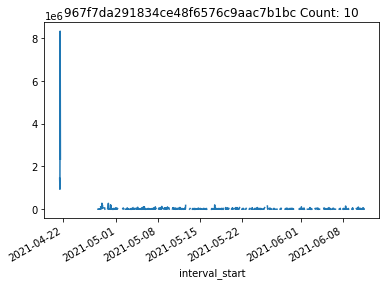

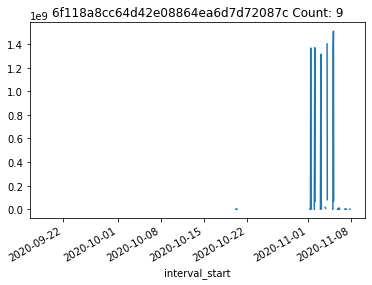

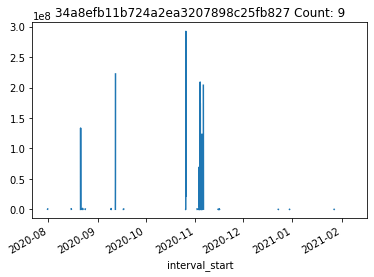

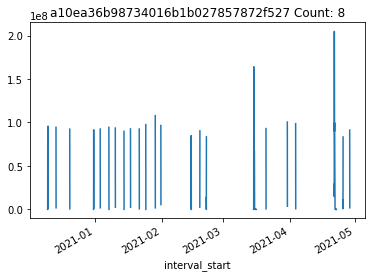

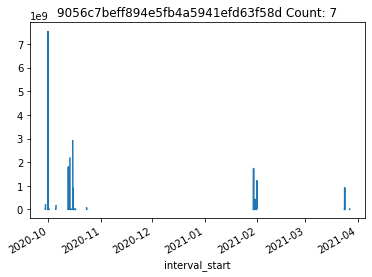

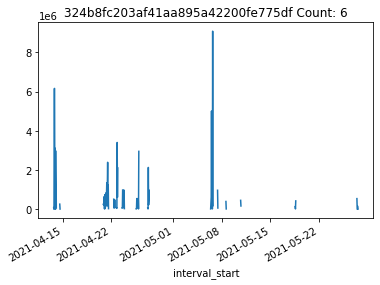

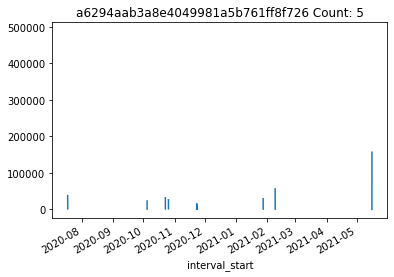

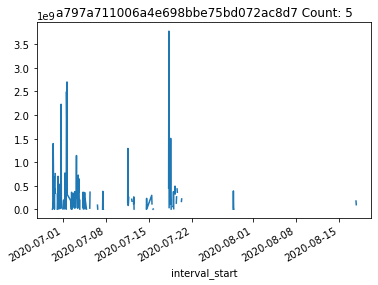

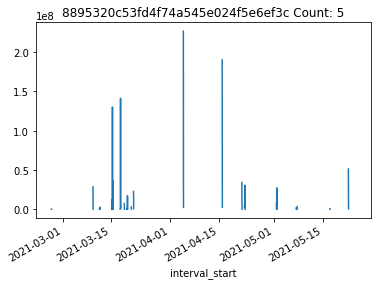

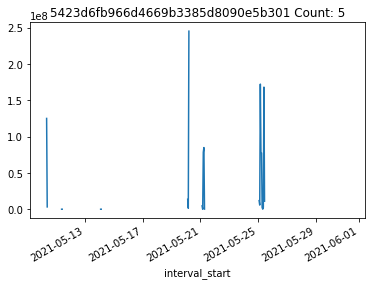

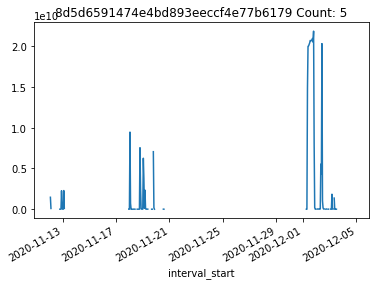

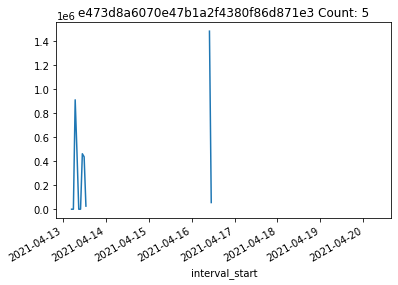

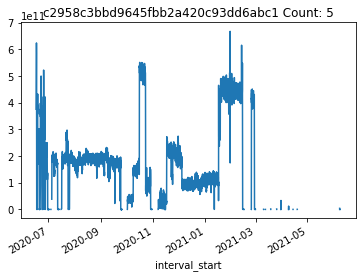

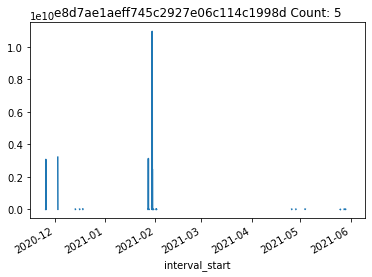

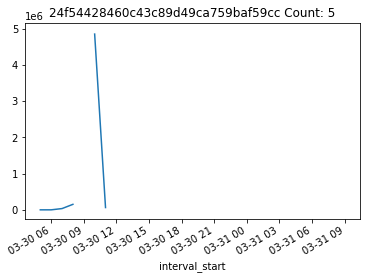

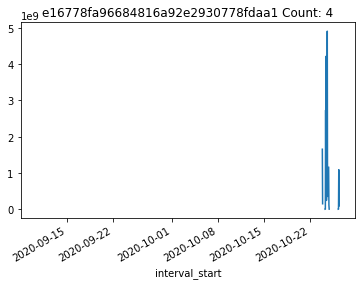

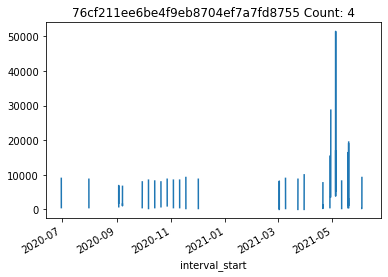

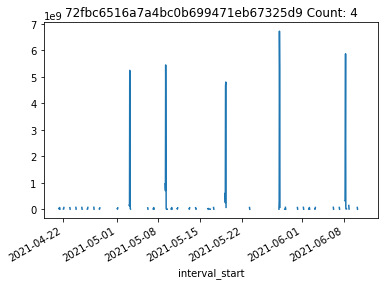

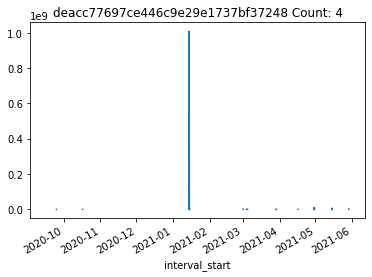

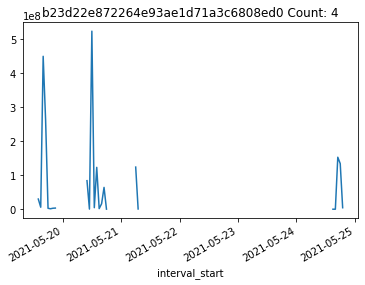

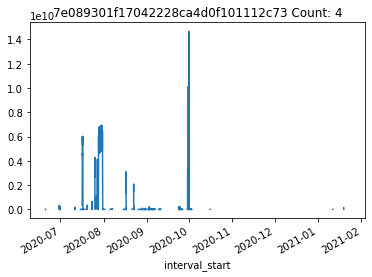

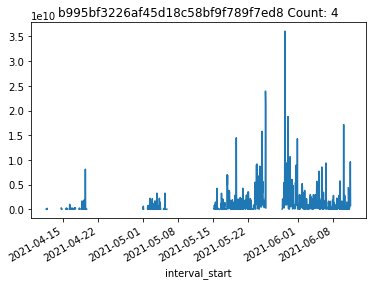

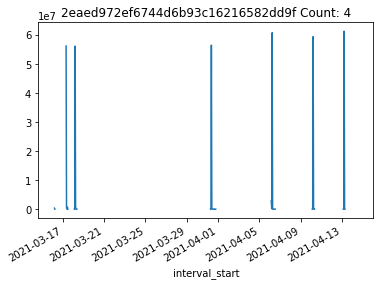

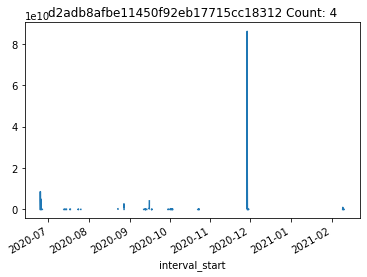

In [29]:
for i in range(len(ap_bbr_dlsusproj1_df.columns)):
    proj_id = ap_bbr_dlsusproj1.loc[i, 'project_id']
    cancel_count = ap_bbr_dlsusproj1.loc[i, 'dl_cancel_count']
    plt.figure()
    ap_bbr_dlsusproj1_df.iloc[:,i].plot(title=proj_id + ' Count: ' + str(cancel_count))
    # ap_bbr_download[ap_bbr_download['project_id']==ap_bbr_dlsusproj1.loc[i, 'project_id']].pivot(index='interval_start', columns='project_id', values='settled').plot(title=ap_bbr_dlsusproj1.loc[i, 'project_id'] + ' Count: ' + str(ap_bbr_dlsusproj1.loc[i, 'dl_cancel_count']), legend=False, rot=30)

#### Comparing to non-suspected projects' usage patterns

In [30]:
ap_bbr_dlnosussum = ap_bbr_download[~ap_bbr_download['project_id'].isin(list(ap_bbr_dlsuscount['project_id']))].groupby('project_id').agg({'settled':'sum'}).sort_values(by='settled', ascending=False)
ap_bbr_dlnosussum = ap_bbr_dlnosussum.rename({'settled': 'settled_sum'}, axis=1).reset_index()
ap_bbr_dlnosussum

project_id   settled_sum
0    cfbbd26cfa9f4a9e8ac5dcbda07b2cc3  283388525568
1    8b2edd391c734bc0aa63aefc2c8c18f3   47099931904
2    4aea0d3bc32f420e90b32ba75683f5f4   46174693376
3    f14d77db47934aa09b8c5a2536009d03   25769356544
4    553643593cac45979c57af9508742590   25529869824
..                                ...           ...
367  8b80b61c462d49e58447e842e2d197f8             0
368  296534ccba094ff88d9051a691c20334             0
369  ef2a4085edfc431ca22470a437c2d4a2             0
370  9653a09434104242a8bbae7ec2acb8e1             0
371  008c2211812a4905bcfc5e54f9a4648a             0

[372 rows x 2 columns]

In [31]:
# Zooming in first to the top 20 projects with highest total amount settled
ap_bbr_dlnosusproj1 = ap_bbr_dlnosussum.loc[:20,:]
ap_bbr_dlnosusproj1

project_id   settled_sum
0   cfbbd26cfa9f4a9e8ac5dcbda07b2cc3  283388525568
1   8b2edd391c734bc0aa63aefc2c8c18f3   47099931904
2   4aea0d3bc32f420e90b32ba75683f5f4   46174693376
3   f14d77db47934aa09b8c5a2536009d03   25769356544
4   553643593cac45979c57af9508742590   25529869824
5   11ffeab1d317465099a4efa65270a72e   21532154368
6   9e20b2594c094df2a24c34c9d0df0402   16492491776
7   98e8ecf20d244a2b9c83c73aafd8d6b9   12674849792
8   43c8058d1969455c84911cff9d6af230    7215442944
9   6b8c055d72264bba929bb41023b7fdab    6102228480
10  ada42c5ca171485cb1cc797571d618dd    4480218368
11  94a3b1590cfc47fa8c1a3779e67f21a4    3430792960
12  1c6c28d50e614688aabf6f64ee8c7153    3324532224
13  10d14b91795741eba9c967a32bbbdcdf    3101166080
14  213b07d942ad4c4e83f207502dad6b76    2945942016
15  cbfca105d1d041a79e0a263d6bc69c69    2941210624
16  97a5477dbf6742e7aa92215569dec92a    2879863040
17  aefb1147677d4f8495d702dfa597cf20    2501852160
18  1015ca85d0b7496caa232ce73f44fe70    2292746752
19  a0aa710b5a8e4f28ab16d287cc7b42f5    2220410368
20  777c85e5ce774219bf2f44e315965016    2143750656

In [32]:
ap_bbr_dlnosus1_df = ap_bbr_download[ap_bbr_download['project_id'].isin(list(ap_bbr_dlnosusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
ap_bbr_dlnosus1_df = ap_bbr_dlnosus1_df[list(ap_bbr_dlnosusproj1['project_id'])]
ap_bbr_dlnosus1_df

project_id           cfbbd26cfa9f4a9e8ac5dcbda07b2cc3  \
interval_start                                          
2020-06-17 12:00:00                               NaN   
2020-06-17 13:00:00                               NaN   
2020-06-17 15:00:00                               NaN   
2020-06-17 16:00:00                               NaN   
2020-06-18 00:00:00                               NaN   
...                                               ...   
2021-06-11 08:00:00                      1.852272e+10   
2021-06-11 09:00:00                      1.874066e+08   
2021-06-11 10:00:00                      1.056768e+06   
2021-06-11 11:00:00                      1.652480e+07   
2021-06-11 12:00:00                      5.005312e+06   

project_id           8b2edd391c734bc0aa63aefc2c8c18f3  \
interval_start                                          
2020-06-17 12:00:00                               NaN   
2020-06-17 13:00:00                               NaN   
2020-06-17 15:00:00                               NaN   
2020-06-17 16:00:00                               NaN   
2020-06-18 00:00:00                               NaN   
...                                               ...   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   

project_id           4aea0d3bc32f420e90b32ba75683f5f4  \
interval_start                                          
2020-06-17 12:00:00                               NaN   
2020-06-17 13:00:00                               NaN   
2020-06-17 15:00:00                               NaN   
2020-06-17 16:00:00                               NaN   
2020-06-18 00:00:00                               NaN   
...                                               ...   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   

project_id           f14d77db47934aa09b8c5a2536009d03  \
interval_start                                          
2020-06-17 12:00:00                               NaN   
2020-06-17 13:00:00                               NaN   
2020-06-17 15:00:00                               NaN   
2020-06-17 16:00:00                               NaN   
2020-06-18 00:00:00                               NaN   
...                                               ...   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   

project_id           553643593cac45979c57af9508742590  \
interval_start                                          
2020-06-17 12:00:00                               NaN   
2020-06-17 13:00:00                               NaN   
2020-06-17 15:00:00                               NaN   
2020-06-17 16:00:00                               NaN   
2020-06-18 00:00:00                               NaN   
...                                               ...   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   

project_id           11ffeab1d317465099a4efa65270a72e  \
interval_start                                          
2020-06-17 12:00:00                           74240.0   
2020-06-17 13:00:00                            7680.0   
2020-06-17 15:00:00                           94720.0   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


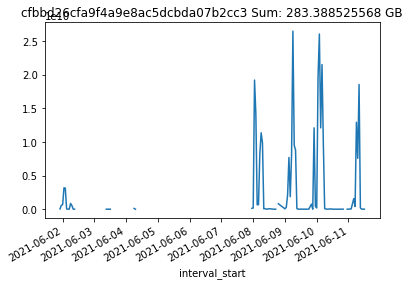

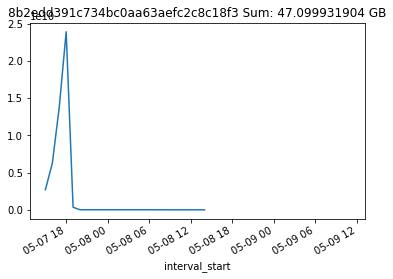

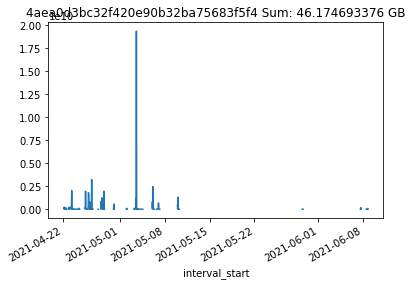

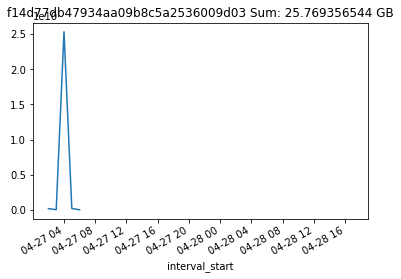

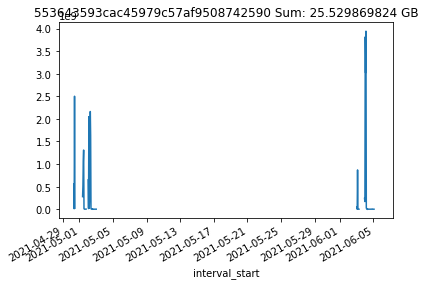

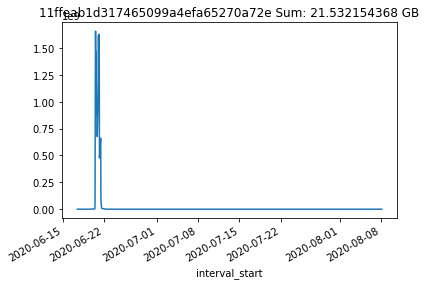

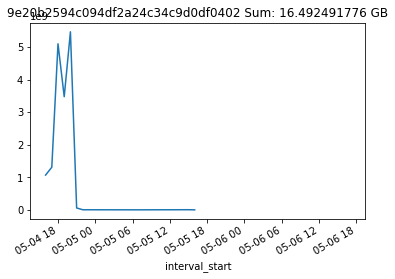

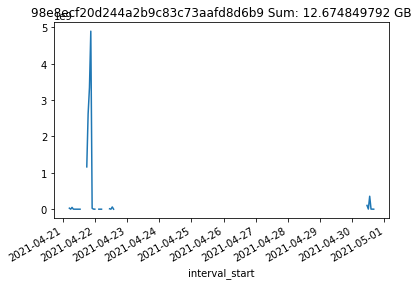

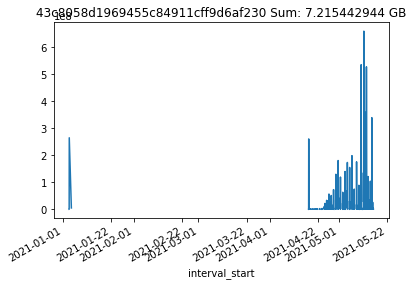

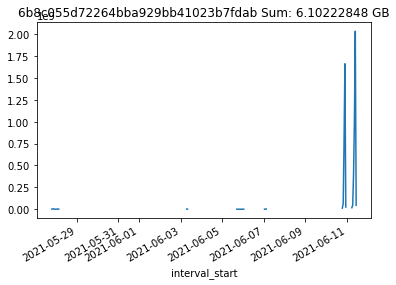

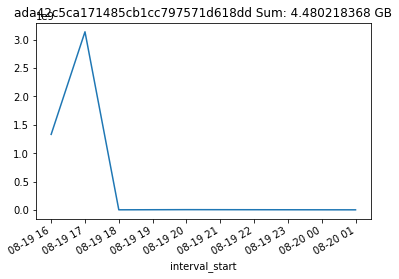

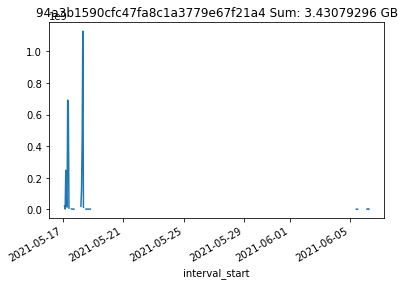

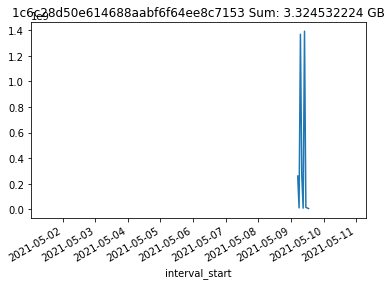

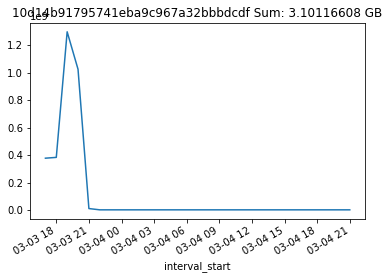

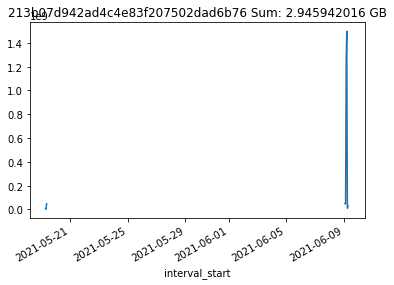

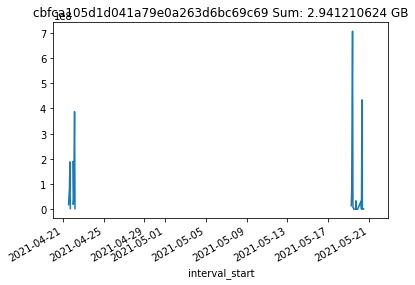

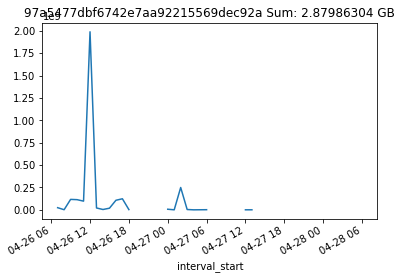

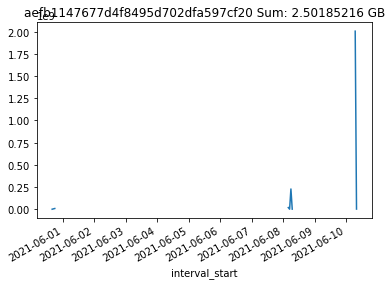

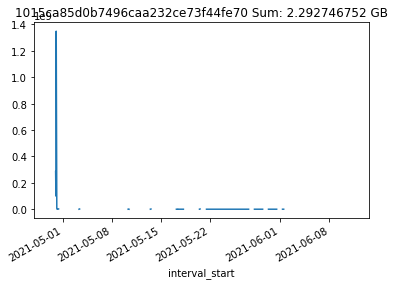

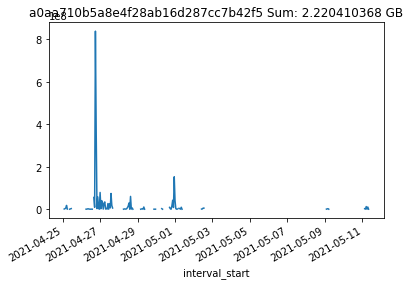

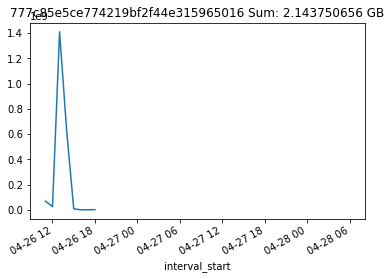

In [33]:
for i in range(len(ap_bbr_dlnosus1_df.columns)):
    proj_id = ap_bbr_dlnosusproj1.loc[i, 'project_id']
    settled_sum = ap_bbr_dlnosusproj1.loc[i, 'settled_sum']/1e9
    plt.figure()
    ap_bbr_dlnosus1_df.iloc[:,i].plot(title=proj_id + ' Sum: ' + str(settled_sum) + ' GB')

#### Selecting template pattern for DTW matching

##### Template candidate 1

<AxesSubplot:xlabel='interval_start'>

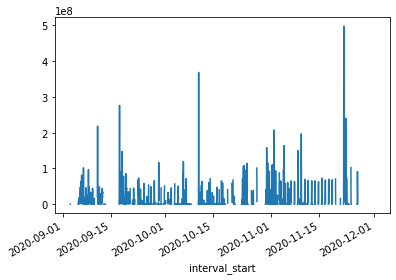

In [34]:
# Plotting template candidate 1
ap_template1 = ap_bbr_dlsusproj1_df.iloc[:4000,0]
ap_template1.plot()

In [35]:
template = list(ap_template1.dropna())
testsus0 = list(ap_bbr_dlsusproj1_df.iloc[:,0].dropna())
testsus1 = list(ap_bbr_dlsusproj1_df.iloc[:,1].dropna())
testsus2 = list(ap_bbr_dlsusproj1_df.iloc[:,2].dropna())

testnosus0 = list(ap_bbr_dlnosus1_df.iloc[:,0].dropna())
testnosus1 = list(ap_bbr_dlnosus1_df.iloc[:,1].dropna())

0.0005653063598944592


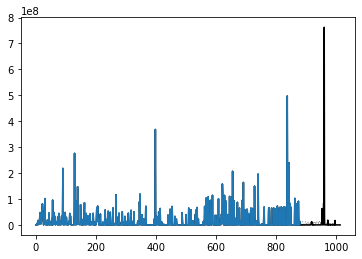

<AxesSubplot:>

In [64]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.008865303928011612


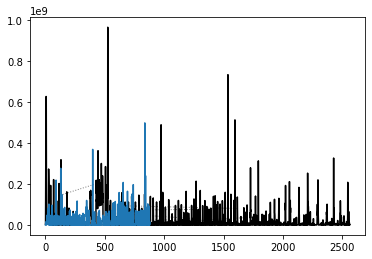

<AxesSubplot:>

In [65]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.029703618619883042


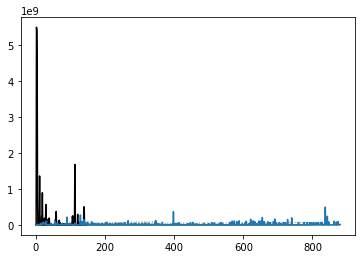

<AxesSubplot:>

In [66]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [75]:
sus_scores = list()
for i in range(len(ap_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(ap_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.7685140012692369
1 0.5433707660685994
2 0.9049952651515152
3 0.7165294117647059
4 0.7236681082075819
5 0.8291239002932551
6 0.7681330472103004
7 0.5221280991735537
8 0.17274565057583924
9 0.6294545454545455
10 0.769590132090132
11 0.5824404761904762
12 0.8903309409888357
13 0.6961311589174184
14 0.0015327695560253263
15 0.9199640287769784
16 0.6725243506493506
17 0.8064772727272728
18 0.5488954970263382
19 0.23417832167832164
20 0.0634122677905361
21 0.603030303030303
22 0.6797979797979798
23 0.1624545454545454
24 0.47722968319559234
25 0.862525826446281
26 0.211489898989899
27 0.6929467084639498
28 0.24233018100467763
29 0.5757775997864103
30 0.8074701937406855
31 0.6691677807486631


(array([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 2., 1., 0.,
        1., 0., 3., 2., 1., 1., 0., 3., 0., 2., 0., 1., 1., 0., 1., 2.]),
 array([0.00153277, 0.01990139, 0.03827002, 0.05663865, 0.07500727,
        0.0933759 , 0.11174452, 0.13011315, 0.14848177, 0.1668504 ,
        0.18521902, 0.20358765, 0.22195627, 0.2403249 , 0.25869352,
        0.27706215, 0.29543077, 0.3137994 , 0.33216802, 0.35053665,
        0.36890527, 0.3872739 , 0.40564252, 0.42401115, 0.44237977,
        0.4607484 , 0.47911702, 0.49748565, 0.51585427, 0.5342229 ,
        0.55259153, 0.57096015, 0.58932878, 0.6076974 , 0.62606603,
        0.64443465, 0.66280328, 0.6811719 , 0.69954053, 0.71790915,
        0.73627778, 0.7546464 , 0.77301503, 0.79138365, 0.80975228,
        0.8281209 , 0.84648953, 0.86485815, 0.88322678, 0.9015954 ,
        0.91996403]),
 <BarContainer object of 50 artists>)

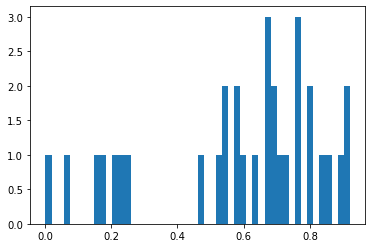

In [76]:
# Plotting scores histogram
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

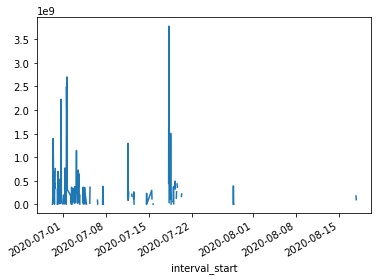

In [77]:
# Checking the project that was assigned the highest probability
ap_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

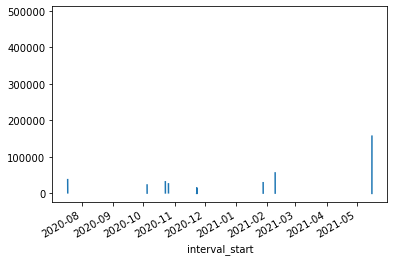

In [78]:
# Checking the project that was assigned the lowest probability
ap_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

0.06654805638435754


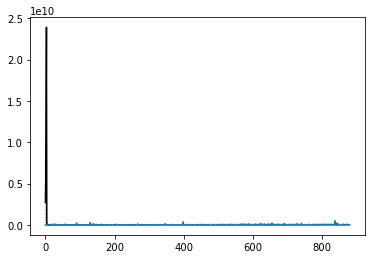

<AxesSubplot:>

In [79]:
alignment = dtw(testnosus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.29529363239751555


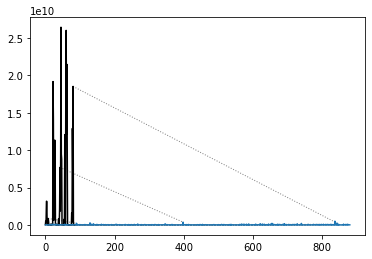

<AxesSubplot:>

In [80]:
alignment = dtw(testnosus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [81]:
nosus_scores = list()
for i in range(len(ap_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(ap_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.9951569264069264
1 0.2488636363636364
2 0.7359643734643735
3 0.7113636363636364
4 0.8062950937950938
5 0.39345041322314045
6 0.4415775401069518
7 0.8499579124579124
8 0.7503372135994087
9 0.9383522727272727
10 0.07159090909090904
11 0.8015993265993266
12 0.3113636363636364
13 0.18198051948051952
14 0.2796717171717171
15 0.9098596256684492
16 0.4273200757575758
17 0.86125
18 0.585058505850585
19 0.9419554455445545
20 0.2570707070707071


(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 1., 1., 1., 0., 1.]),
 array([0.07159091, 0.09006223, 0.10853355, 0.12700487, 0.14547619,
        0.16394751, 0.18241883, 0.20089015, 0.21936147, 0.23783279,
        0.25630411, 0.27477543, 0.29324675, 0.31171807, 0.33018939,
        0.34866071, 0.36713203, 0.38560335, 0.40407468, 0.422546  ,
        0.44101732, 0.45948864, 0.47795996, 0.49643128, 0.5149026 ,
        0.53337392, 0.55184524, 0.57031656, 0.58878788, 0.6072592 ,
        0.62573052, 0.64420184, 0.66267316, 0.68114448, 0.6996158 ,
        0.71808712, 0.73655844, 0.75502976, 0.77350108, 0.7919724 ,
        0.81044372, 0.82891504, 0.84738636, 0.86585768, 0.884329  ,
        0.90280032, 0.92127165, 0.93974297, 0.95821429, 0.97668561,
        0.99515693]),
 <BarContainer object of 50 artists>)

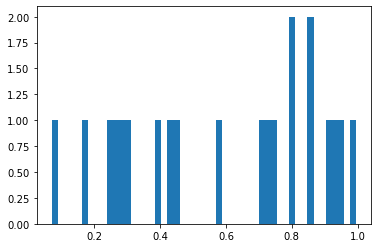

In [82]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

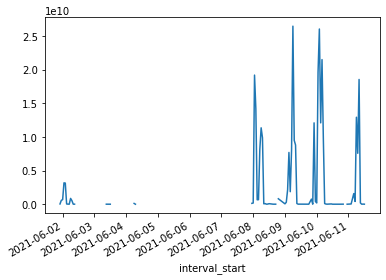

In [83]:
ap_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

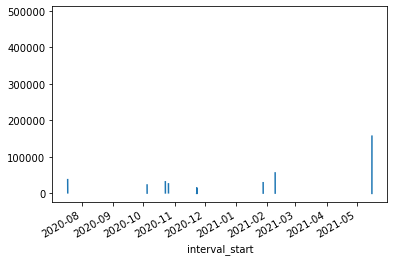

In [84]:
ap_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

##### Template candidate 2

<AxesSubplot:xlabel='interval_start'>

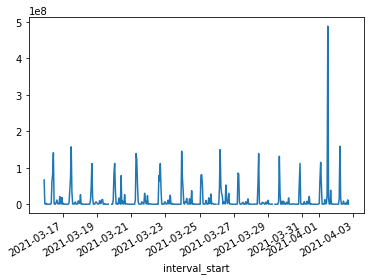

In [85]:
# Plotting template candidate 2
ap_template2 = ap_bbr_dlsusproj1_df.iloc[6200:6600,1]
ap_template2.plot()

In [86]:
template = list(ap_template2.dropna())

0.008135385945945945


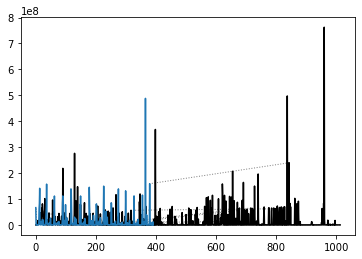

<AxesSubplot:>

In [87]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.010825678029769959


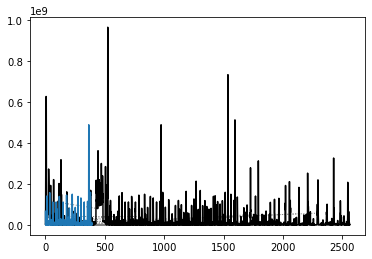

<AxesSubplot:>

In [88]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.04583247040595903


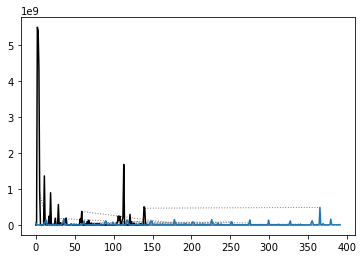

<AxesSubplot:>

In [89]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [90]:
sus_scores = list()
for i in range(len(ap_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(ap_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.5757494701111399
1 0.37312012358315527
2 0.938210429099176
3 0.9032089107311012
4 0.6601207229669233
5 0.9156835244616781
6 0.7987552550409975
7 0.5082538944431527
8 0.14123356490852035
9 0.9818925831202046
10 0.9142894616040396
11 0.9916575325782487
12 0.9716875308475793
13 0.869701880088245
14 0.037411526794742134
15 0.9852619183425638
16 0.8649068322981366
17 0.6896419437340153
18 0.6613284891364104
19 0.7928388746803069
20 0.07159752536156294
21 0.5640451832907076
22 0.5816993464052287
23 0.4059335038363171
24 0.507323878167868
25 0.8203470123227157
26 0.14394872280635285
27 0.8078313784284328
28 0.26203393450041434
29 0.31547354086935453
30 0.8794599807135969
31 0.8539942831352489


(array([1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0., 2., 0.,
        1., 0., 0., 0., 0., 2., 1., 1., 1., 2., 1., 2., 1., 1., 1., 3.]),
 array([0.03741153, 0.05649645, 0.07558137, 0.09466629, 0.11375121,
        0.13283613, 0.15192105, 0.17100597, 0.19009089, 0.20917581,
        0.22826073, 0.24734565, 0.26643057, 0.28551549, 0.30460041,
        0.32368533, 0.34277025, 0.36185517, 0.38094009, 0.40002501,
        0.41910993, 0.43819485, 0.45727977, 0.47636469, 0.49544961,
        0.51453453, 0.53361945, 0.55270437, 0.57178929, 0.59087421,
        0.60995913, 0.62904405, 0.64812897, 0.66721389, 0.68629881,
        0.70538373, 0.72446865, 0.74355357, 0.76263849, 0.78172341,
        0.80080833, 0.81989325, 0.83897817, 0.85806309, 0.87714801,
        0.89623293, 0.91531785, 0.93440277, 0.95348769, 0.97257261,
        0.99165753]),
 <BarContainer object of 50 artists>)

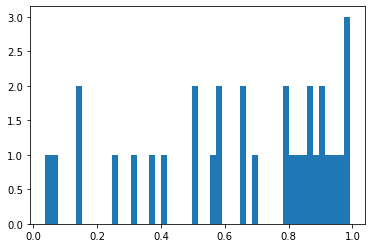

In [91]:
# Plotting scores histogram
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

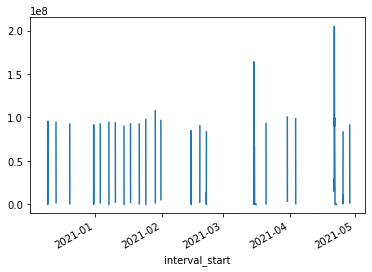

In [92]:
ap_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

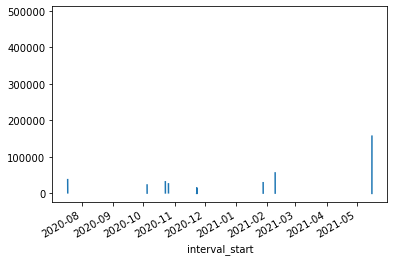

In [93]:
ap_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

0.12760844673891628


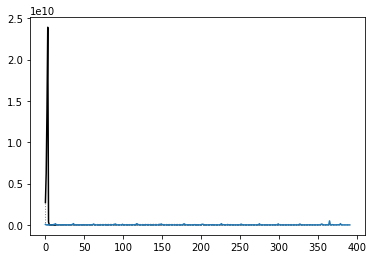

<AxesSubplot:>

In [94]:
alignment = dtw(testnosus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.586856965903564


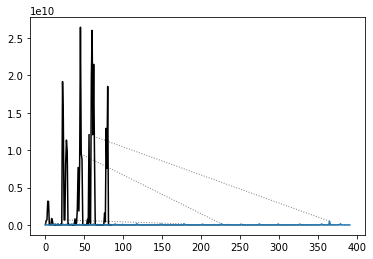

<AxesSubplot:>

In [95]:
alignment = dtw(testnosus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [96]:
nosus_scores = list()
for i in range(len(ap_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(ap_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.7950615028620144
1 0.2467047019476687
2 0.9954724545517384
3 0.5869565217391304
4 0.8200787561401373
5 0.3853522436642641
6 0.7424401985858282
7 0.28890783366486694
8 0.9572079096750047
9 0.6801242236024845
10 0.09015345268542196
11 0.15392630482144554
12 0.10204603580562654
13 0.40409207161125316
14 0.33731173628871836
15 0.6860989920264782
16 0.855924978687127
17 0.49053708439897703
18 0.03740092679344664
19 0.899268187688334
20 0.6098323387325946


(array([1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
        0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]),
 array([0.03740093, 0.05656236, 0.07572379, 0.09488522, 0.11404665,
        0.13320808, 0.15236951, 0.17153094, 0.19069237, 0.2098538 ,
        0.22901523, 0.24817666, 0.26733809, 0.28649952, 0.30566095,
        0.32482239, 0.34398382, 0.36314525, 0.38230668, 0.40146811,
        0.42062954, 0.43979097, 0.4589524 , 0.47811383, 0.49727526,
        0.51643669, 0.53559812, 0.55475955, 0.57392098, 0.59308241,
        0.61224384, 0.63140527, 0.6505667 , 0.66972814, 0.68888957,
        0.708051  , 0.72721243, 0.74637386, 0.76553529, 0.78469672,
        0.80385815, 0.82301958, 0.84218101, 0.86134244, 0.88050387,
        0.8996653 , 0.91882673, 0.93798816, 0.95714959, 0.97631102,
        0.99547245]),
 <BarContainer object of 50 artists>)

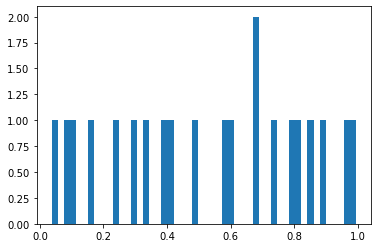

In [97]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

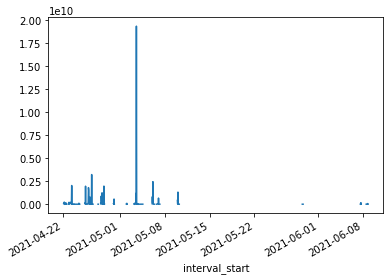

In [98]:
ap_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

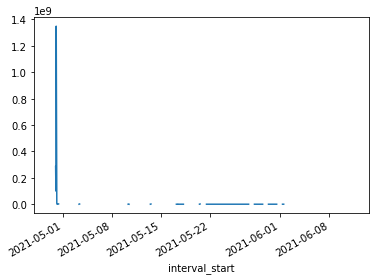

In [99]:
ap_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

### Europe Region Data (eu_bbr)

In [100]:
eu_bbr['month'] = eu_bbr['interval_start'].dt.to_period('M')
eu_bbr_dlsuscount = eu_bbr[(eu_bbr['inline']==0) & (eu_bbr['settled']==0) & (eu_bbr['action']==2)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
eu_bbr_dlsuscount = eu_bbr_dlsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'dl_cancel_count'}, axis=1).reset_index(drop=True)
eu_bbr_dlsuscount

project_id  dl_cancel_count
0     8118cf7c11224ffda2284716de755d21             8238
1     a56224e6a3f943baa6791431d2711271              260
2     fee8c911af2e4c5c841ee158eebb8663               70
3     55a57b57962a4ad58d71c86408f972af               64
4     9f28c45fa04249da955042dc28d7f2a8               59
...                                ...              ...
1067  679425ef6d92443a9a388d44257556bc                1
1068  67b9a5b3848144bc9a6e69abb31e95db                1
1069  6855452731b3485da9872c27cab5cb29                1
1070  69bd1fd778f4431bb59b2b5ecec372b8                1
1071  fff103d31b114502a51ef83a52293e84                1

[1072 rows x 2 columns]

In [101]:
eu_bbr_dlsuscount['dl_cancel_count'].value_counts()

1       639
2       171
3        77
4        38
5        23
6        15
7        11
9        11
14        7
10        7
8         7
11        6
13        5
17        5
12        4
26        4
32        3
29        3
25        3
18        3
16        3
21        2
24        2
28        2
41        2
45        1
260       1
70        1
64        1
59        1
55        1
53        1
48        1
8238      1
39        1
42        1
23        1
38        1
36        1
33        1
15        1
30        1
19        1
46        1
Name: dl_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [102]:
# Narrowing down eu_bbr for future plotting purpose
eu_bbr = eu_bbr.groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index()
eu_bbr_download = eu_bbr[eu_bbr['action']==2][['project_id', 'interval_start', 'settled']]
eu_bbr_download

project_id      interval_start       settled
12      0de105efbc5d4944b567aa6ea90db9f9 2020-06-16 14:00:00     422522112
13      300af053503a42cfa6c1a90246c09d59 2020-06-16 14:00:00  245334294016
14      8118cf7c11224ffda2284716de755d21 2020-06-16 14:00:00    1536007424
15      963889ab75c84daab252be8209c4d185 2020-06-16 14:00:00    5041695488
16      a652fecc84a249b9b7380e8798ea9c8b 2020-06-16 14:00:00             0
...                                  ...                 ...           ...
319765  b34b271795f84c9995b80fd9b319ca3e 2021-06-11 13:00:00       1813504
319766  b617c07370a240ef938138ce4df3097d 2021-06-11 13:00:00   17375255808
319767  e2bc94727cc4497d8a3a7d93a4f068ad 2021-06-11 13:00:00         67072
319768  f6c05c9255a14ecabb3473d4c97e3705 2021-06-11 13:00:00             0
319769  f7877e7be74d4e9a8f2c7b90d0935cf5 2021-06-11 13:00:00        195584

[109677 rows x 3 columns]

In [107]:
# Focusing first on projects with more than 30 times download cancellations
eu_bbr_dlsusproj1 = eu_bbr_dlsuscount[eu_bbr_dlsuscount['dl_cancel_count']>30]
eu_bbr_dlsusproj1

project_id  dl_cancel_count
0   8118cf7c11224ffda2284716de755d21             8238
1   a56224e6a3f943baa6791431d2711271              260
2   fee8c911af2e4c5c841ee158eebb8663               70
3   55a57b57962a4ad58d71c86408f972af               64
4   9f28c45fa04249da955042dc28d7f2a8               59
5   6a0c2e967df34f0298b61814949c3fc4               55
6   a63cf958e0614ed8859a64991aa1fa5f               53
7   2417ab05b502446dbd0795c37668a723               48
8   6fecd3f0f8c94dcc8a451639bc6976b1               46
9   e6cd1b6ec6c042ccadf54429c52a6b96               45
10  c2b2ee61bd46445a85deeb1a7644d00b               42
11  a0756f3ffc174c9ebf78208d4cb000d2               41
12  26d307b047494b2faacb27b05d203934               41
13  2eb37414d18e4f928b706ccb8a8e2507               39
14  b427c1436c4d4ab9a54b2b4c22247f95               38
15  0ad9622e1c2c4bd59832e292fcb57bd2               36
16  2206b7bd93c14b91954a31b10b4581e7               33
17  4071809c797046198d68a3ad4b0fc8ff               32
18  0de105efbc5d4944b567aa6ea90db9f9               32
19  a5a35931913941daaf4553721eeb5263               32

In [108]:
eu_bbr_dlsusproj1_df = eu_bbr_download[eu_bbr_download['project_id'].isin(list(eu_bbr_dlsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
eu_bbr_dlsusproj1_df = eu_bbr_dlsusproj1_df[list(eu_bbr_dlsusproj1['project_id'])]
eu_bbr_dlsusproj1_df

project_id           8118cf7c11224ffda2284716de755d21  \
interval_start                                          
2020-06-16 14:00:00                      1.536007e+09   
2020-06-16 15:00:00                      6.202394e+08   
2020-06-16 16:00:00                      6.954959e+08   
2020-06-16 17:00:00                      1.754264e+09   
2020-06-16 18:00:00                      2.696940e+09   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           fee8c911af2e4c5c841ee158eebb8663  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           55a57b57962a4ad58d71c86408f972af  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           9f28c45fa04249da955042dc28d7f2a8  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           6a0c2e967df34f0298b61814949c3fc4  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

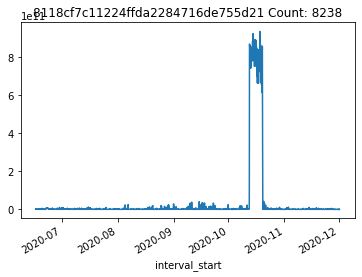

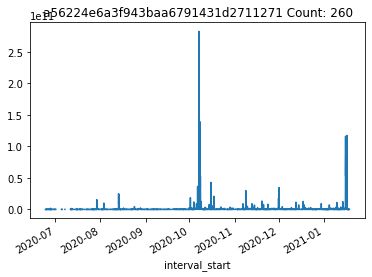

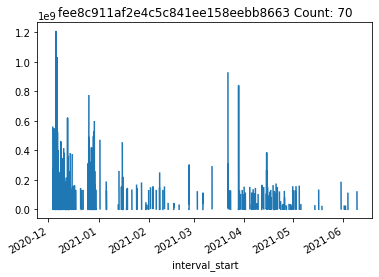

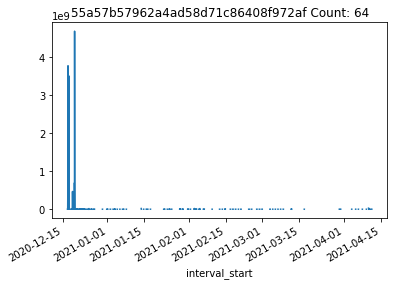

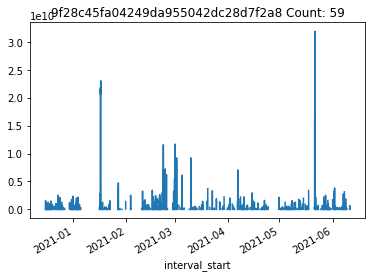

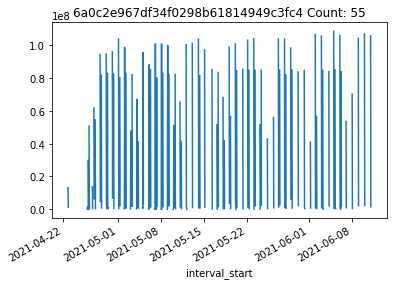

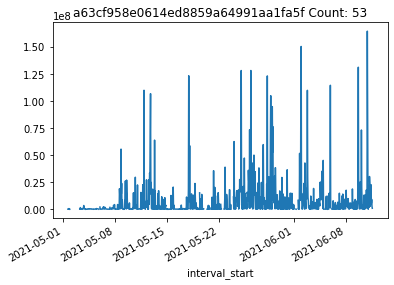

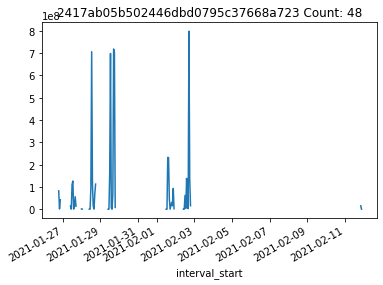

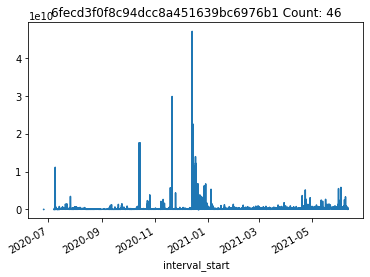

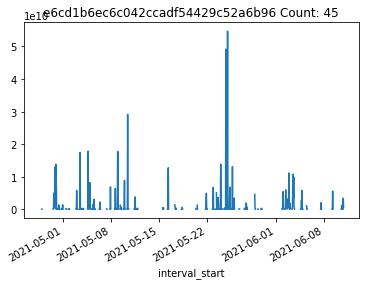

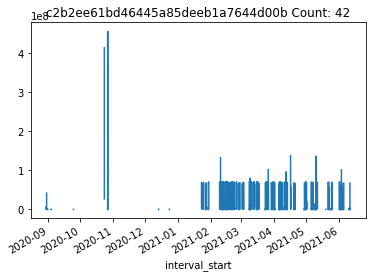

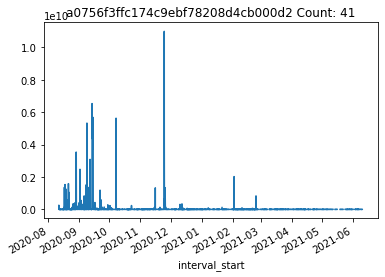

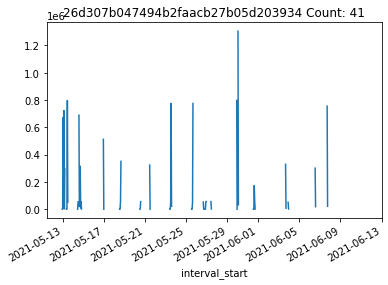

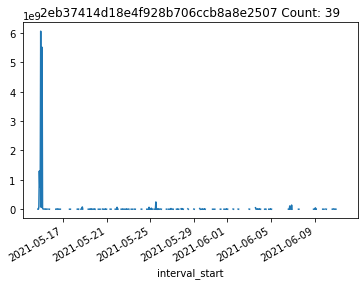

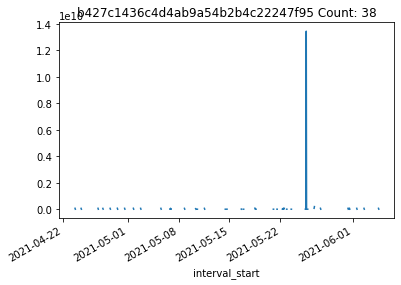

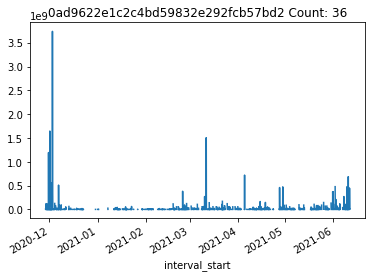

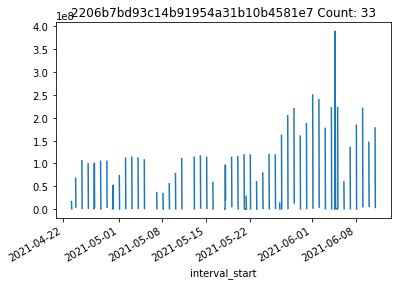

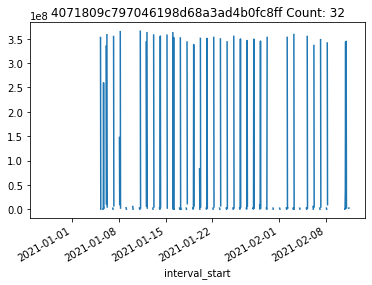

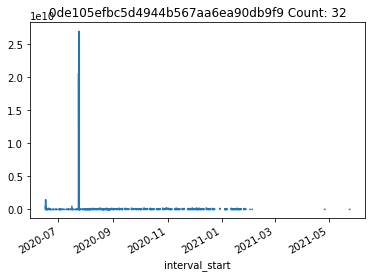

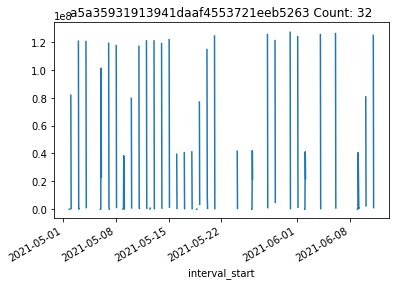

In [109]:
for i in range(len(eu_bbr_dlsusproj1_df.columns)):
    proj_id = eu_bbr_dlsusproj1.loc[i, 'project_id']
    cancel_count = eu_bbr_dlsusproj1.loc[i, 'dl_cancel_count']
    plt.figure()
    eu_bbr_dlsusproj1_df.iloc[:,i].plot(title=proj_id + ' Count: ' + str(cancel_count))

#### Comparing to non-suspected projects' usage patterns

In [110]:
eu_bbr_dlnosussum = eu_bbr_download[~eu_bbr_download['project_id'].isin(list(eu_bbr_dlsuscount['project_id']))].groupby('project_id').agg({'settled':'sum'}).sort_values(by='settled', ascending=False)
eu_bbr_dlnosussum = eu_bbr_dlnosussum.rename({'settled': 'settled_sum'}, axis=1).reset_index()
eu_bbr_dlnosussum

project_id      settled_sum
0    b617c07370a240ef938138ce4df3097d  109970738002432
1    ca7a0f2e08944a508baeb6f278d88f3d   11134437815552
2    36971dbb4d434790a6897bc8202fe08b    7298432770816
3    4f14c095f79146ada0267da3e3748544     524110851328
4    2b6aa64399d04cf5975497af8ebdf36f      89559508992
..                                ...              ...
419  c27defded9e448b9be2942acdc000bc9                0
420  c365ec68f8bc486a8b5b002de47ebb6c                0
421  c42a83eaadf94c34ada7161eb91f983a                0
422  c5da7a0eaa754bfeb5908356bd01038e                0
423  85423cb7df694f88b06b1068bbc51537                0

[424 rows x 2 columns]

In [111]:
# Zooming in first to the top 20 projects with highest total amount settled
eu_bbr_dlnosusproj1 = eu_bbr_dlnosussum.loc[:20,:]
eu_bbr_dlnosusproj1

project_id      settled_sum
0   b617c07370a240ef938138ce4df3097d  109970738002432
1   ca7a0f2e08944a508baeb6f278d88f3d   11134437815552
2   36971dbb4d434790a6897bc8202fe08b    7298432770816
3   4f14c095f79146ada0267da3e3748544     524110851328
4   2b6aa64399d04cf5975497af8ebdf36f      89559508992
5   72fb8ed63d384ddd932630d02285026b      69925026560
6   8bbfe0f87e1d4e3c8a1cc2417dcc8f8f      61117650176
7   1217efb7b0064f97ae5f73945720c8ac      57859331584
8   f8019fe4fce9414fb2fa41f5df4f6cec      53296633856
9   96d3f5f8b69848919724af93ef453b22      48558186240
10  c8c8cadc3cc94b4ea66c5bbd847e00ca      44795372032
11  f5cd2cea4f594401bfc4471e5fd86de1      43653463552
12  5a1a3cc5ca734079b4dca2d760713bb7      39384883968
13  7469f059951c4e27964002158e588a4d      37194526976
14  86ae2d340bb940f686601545aa452bda      33920560640
15  2b3d2645ff9c4e65a47ea5a7ac72af76      30554423808
16  7393b84ca39743ceb7db7a97c76d322b      22571385088
17  1602988296824785ac93060574cf55df      21320767488
18  d9f1c90411244a198b925760f4fd474b      17964376832
19  39a3967982ed44b280f8fa0e807bdd9e      13182683904
20  375782937c6f4cb38ce9bc2b303f23ff      10189687552

In [112]:
eu_bbr_dlnosus1_df = eu_bbr_download[eu_bbr_download['project_id'].isin(list(eu_bbr_dlnosusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
eu_bbr_dlnosus1_df = eu_bbr_dlnosus1_df[list(eu_bbr_dlnosusproj1['project_id'])]
eu_bbr_dlnosus1_df

project_id           b617c07370a240ef938138ce4df3097d  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-06-27 17:00:00                               NaN   
2020-06-27 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.802391e+11   
2021-06-11 10:00:00                      2.393457e+11   
2021-06-11 11:00:00                      2.366751e+11   
2021-06-11 12:00:00                      2.568208e+11   
2021-06-11 13:00:00                      1.737526e+10   

project_id           ca7a0f2e08944a508baeb6f278d88f3d  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-06-27 17:00:00                               NaN   
2020-06-27 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           36971dbb4d434790a6897bc8202fe08b  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-06-27 17:00:00                               NaN   
2020-06-27 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           4f14c095f79146ada0267da3e3748544  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-06-27 17:00:00                               NaN   
2020-06-27 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           2b6aa64399d04cf5975497af8ebdf36f  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-06-27 17:00:00                               NaN   
2020-06-27 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           72fb8ed63d384ddd932630d02285026b  \
interval_start                                          
2020-06-27 10:00:00                               NaN   
2020-06-27 11:00:00                               NaN   
2020-06-27 12:00:00                               NaN   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


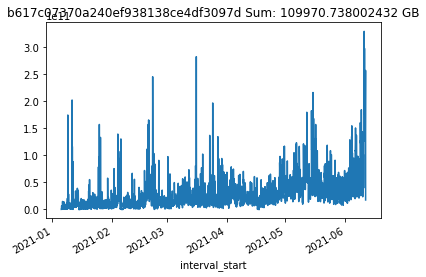

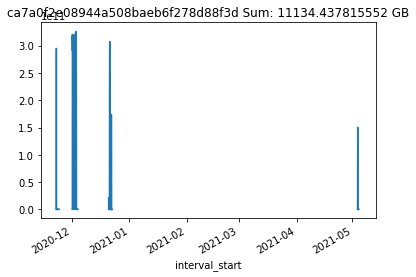

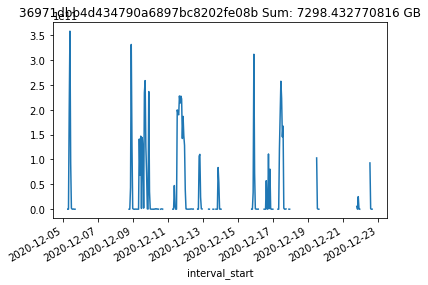

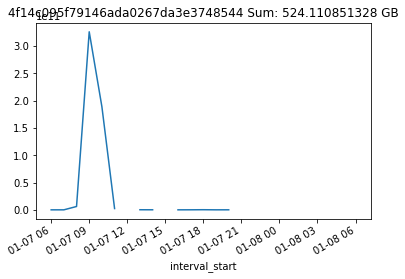

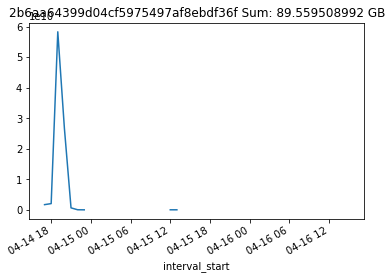

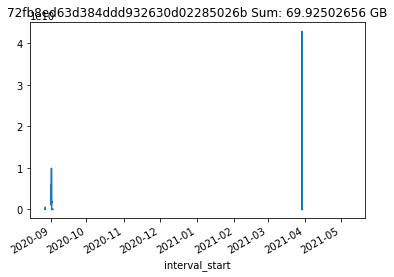

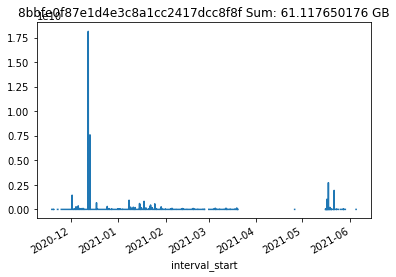

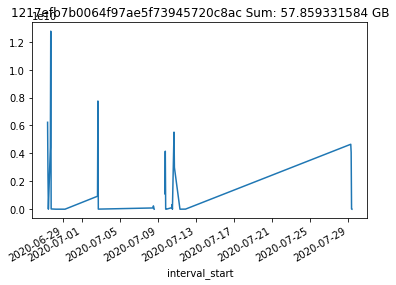

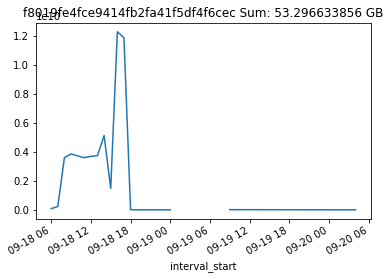

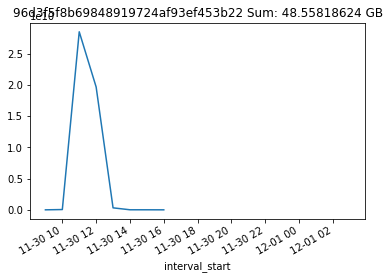

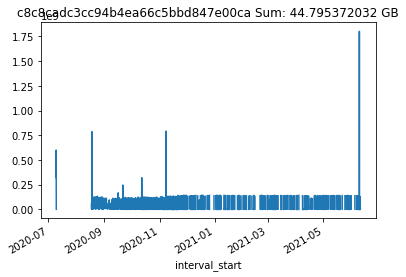

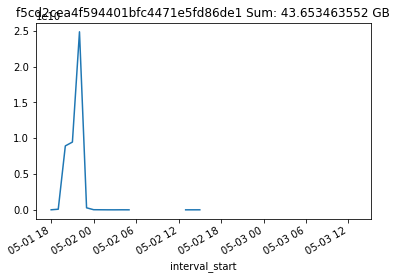

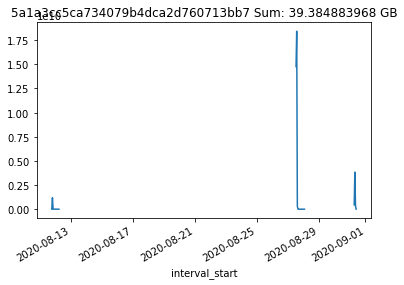

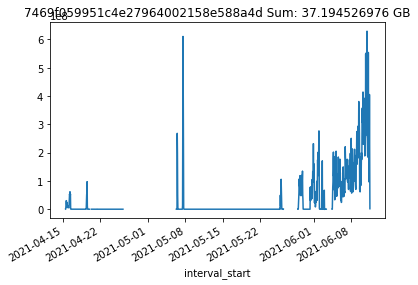

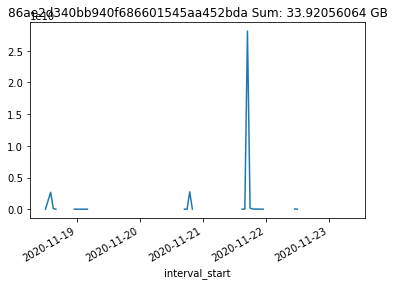

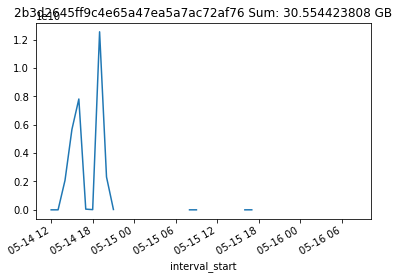

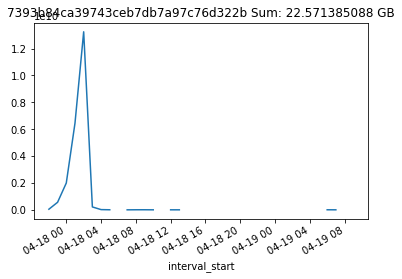

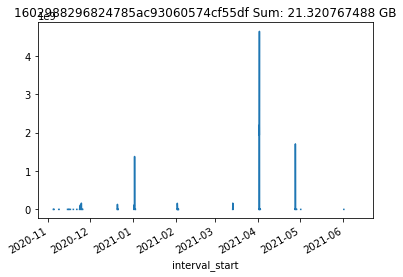

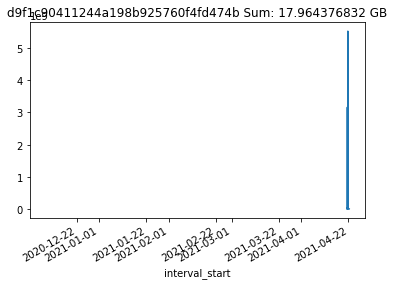

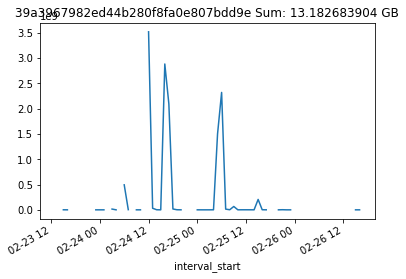

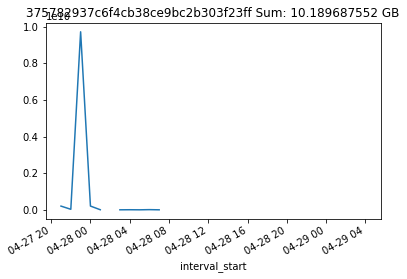

In [113]:
for i in range(len(eu_bbr_dlnosus1_df.columns)):
    proj_id = eu_bbr_dlnosusproj1.loc[i, 'project_id']
    settled_sum = eu_bbr_dlnosusproj1.loc[i, 'settled_sum']/1e9
    plt.figure()
    eu_bbr_dlnosus1_df.iloc[:,i].plot(title=proj_id + ' Sum: ' + str(settled_sum) + ' GB')

#### Selecting template pattern for DTW matching

##### Testing with ap_template1

In [114]:
template = list(ap_template1.dropna())

sus_scores = list()
for i in range(len(eu_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(eu_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.08128661087866107
1 0.5475812170741592
2 0.8689048065336725
3 0.05520689416966018
4 0.4862105183235472
5 0.8256238859180036
6 0.9910984848484848
7 0.5257126348228043
8 0.5093694135243362
9 0.6330213903743316
10 0.8501161108573169
11 0.1009046414430268
12 0.8716366687004271
13 0.9194941348973606
14 0.47865056818181817
15 0.6012735901013364
16 0.8854545454545455
17 0.5744152691968226
18 0.6798932275777914
19 0.9129529561347743


(array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 1., 1., 0., 0., 1.]),
 array([0.05520689, 0.07392473, 0.09264256, 0.11136039, 0.13007822,
        0.14879605, 0.16751389, 0.18623172, 0.20494955, 0.22366738,
        0.24238521, 0.26110304, 0.27982088, 0.29853871, 0.31725654,
        0.33597437, 0.3546922 , 0.37341004, 0.39212787, 0.4108457 ,
        0.42956353, 0.44828136, 0.46699919, 0.48571703, 0.50443486,
        0.52315269, 0.54187052, 0.56058835, 0.57930618, 0.59802402,
        0.61674185, 0.63545968, 0.65417751, 0.67289534, 0.69161318,
        0.71033101, 0.72904884, 0.74776667, 0.7664845 , 0.78520233,
        0.80392017, 0.822638  , 0.84135583, 0.86007366, 0.87879149,
        0.89750933, 0.91622716, 0.93494499, 0.95366282, 0.97238065,
        0.99109848]),
 <BarContainer object of 50 artists>)

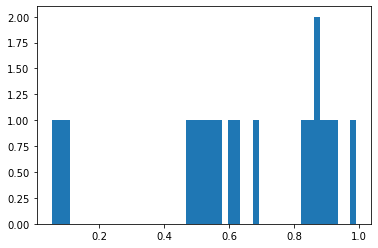

In [115]:
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

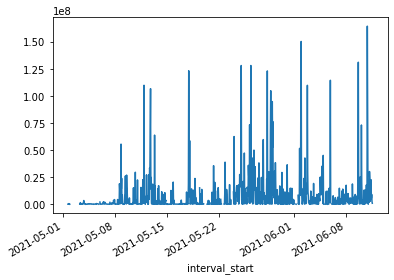

In [116]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

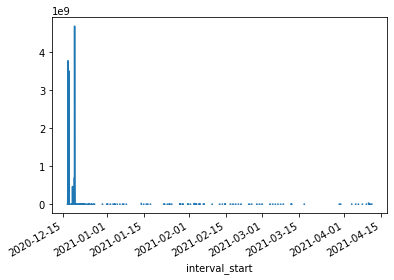

In [117]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [118]:
nosus_scores = list()
for i in range(len(eu_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(eu_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.051560952289236184
1 0.8344046811397557
2 0.8524369416710458
3 0.07972027972027973
4 0.8570616883116883
5 0.6181818181818182
6 0.5435598913664952
7 0.8845454545454545
8 0.07172459893048133
9 0.08508522727272727
10 0.8567283057851239
11 0.5877005347593582
12 0.8673701298701298
13 0.8477263145791814
14 0.7385281385281386
15 0.057018716577540096
16 0.6002673796791445
17 0.838673139158576
18 0.36270053475935826
19 0.7951515151515152
20 0.19914772727272723


(array([2., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 2., 4., 1.]),
 array([0.05156095, 0.06822064, 0.08488033, 0.10154002, 0.11819971,
        0.1348594 , 0.15151909, 0.16817878, 0.18483847, 0.20149816,
        0.21815785, 0.23481754, 0.25147723, 0.26813692, 0.28479661,
        0.3014563 , 0.31811599, 0.33477568, 0.35143537, 0.36809506,
        0.38475475, 0.40141444, 0.41807413, 0.43473382, 0.45139351,
        0.4680532 , 0.48471289, 0.50137258, 0.51803227, 0.53469196,
        0.55135165, 0.56801134, 0.58467103, 0.60133072, 0.61799041,
        0.6346501 , 0.65130979, 0.66796948, 0.68462917, 0.70128886,
        0.71794855, 0.73460824, 0.75126793, 0.76792762, 0.78458731,
        0.801247  , 0.81790669, 0.83456638, 0.85122607, 0.86788576,
        0.88454545]),
 <BarContainer object of 50 artists>)

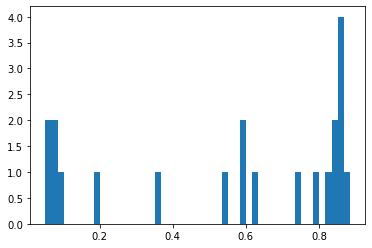

In [119]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

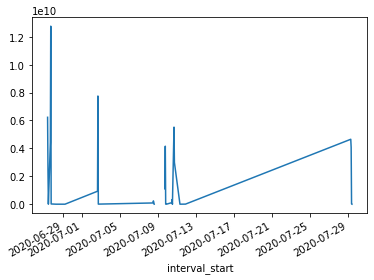

In [121]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

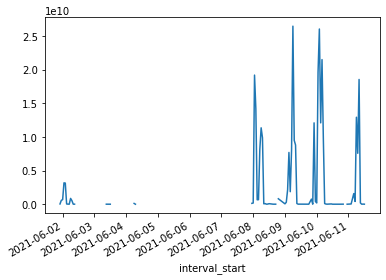

In [122]:
ap_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### Testing with ap_template2

In [123]:
template = list(ap_template2.dropna())

sus_scores = list()
for i in range(len(eu_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(eu_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.07852754344470125
1 0.6557964224132892
2 0.3314810749622451
3 0.02471832446256994
4 0.46980250381952804
5 0.8811410327131706
6 0.7193144830784004
7 0.9910702674584941
8 0.2973575827669077
9 0.9492216323869701
10 0.7069907285021324
11 0.11075335322386515
12 0.8817521756295165
13 0.9780381156670241
14 0.715537084398977
15 0.6487123861935712
16 0.8410866109075827
17 0.8361309065627095
18 0.5021963351766437
19 0.9529268685278915


(array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 1., 2.]),
 array([0.02471832, 0.04404536, 0.0633724 , 0.08269944, 0.10202648,
        0.12135352, 0.14068056, 0.1600076 , 0.17933464, 0.19866167,
        0.21798871, 0.23731575, 0.25664279, 0.27596983, 0.29529687,
        0.31462391, 0.33395095, 0.35327799, 0.37260502, 0.39193206,
        0.4112591 , 0.43058614, 0.44991318, 0.46924022, 0.48856726,
        0.5078943 , 0.52722133, 0.54654837, 0.56587541, 0.58520245,
        0.60452949, 0.62385653, 0.64318357, 0.66251061, 0.68183765,
        0.70116468, 0.72049172, 0.73981876, 0.7591458 , 0.77847284,
        0.79779988, 0.81712692, 0.83645396, 0.855781  , 0.87510803,
        0.89443507, 0.91376211, 0.93308915, 0.95241619, 0.97174323,
        0.99107027]),
 <BarContainer object of 50 artists>)

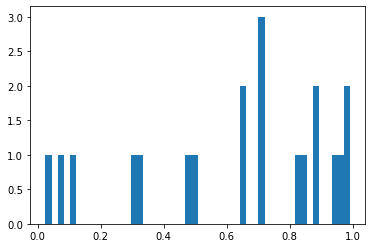

In [124]:
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

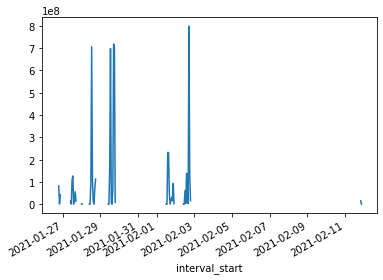

In [125]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

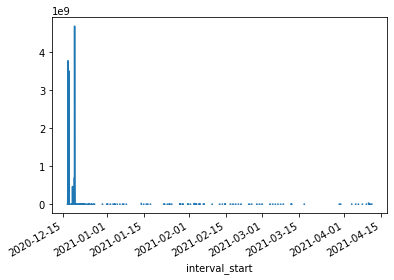

In [126]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [127]:
nosus_scores = list()
for i in range(len(eu_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(eu_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.06522585999559627
1 0.27319922128487995
2 0.3147849740549651
3 0.10072791658469404
4 0.85988308366825
5 0.21432225063938615
6 0.5452764205461444
7 0.7828644501278772
8 0.2088160072213029
9 0.11636828644501274
10 0.6121207341392791
11 0.40439295922972773
12 0.7612349287541104
13 0.6903553842042982
14 0.44172451589331385
15 0.06815104558447416
16 0.6590943282683918
17 0.629627790330991
18 0.4683315781555589
19 0.692980960500142
20 0.2563938618925832


(array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 3., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 1., 2.]),
 array([0.02471832, 0.04404536, 0.0633724 , 0.08269944, 0.10202648,
        0.12135352, 0.14068056, 0.1600076 , 0.17933464, 0.19866167,
        0.21798871, 0.23731575, 0.25664279, 0.27596983, 0.29529687,
        0.31462391, 0.33395095, 0.35327799, 0.37260502, 0.39193206,
        0.4112591 , 0.43058614, 0.44991318, 0.46924022, 0.48856726,
        0.5078943 , 0.52722133, 0.54654837, 0.56587541, 0.58520245,
        0.60452949, 0.62385653, 0.64318357, 0.66251061, 0.68183765,
        0.70116468, 0.72049172, 0.73981876, 0.7591458 , 0.77847284,
        0.79779988, 0.81712692, 0.83645396, 0.855781  , 0.87510803,
        0.89443507, 0.91376211, 0.93308915, 0.95241619, 0.97174323,
        0.99107027]),
 <BarContainer object of 50 artists>)

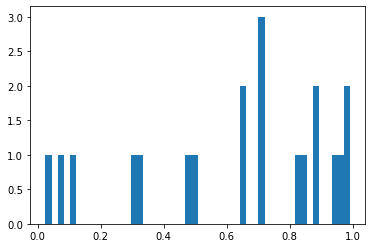

In [128]:
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

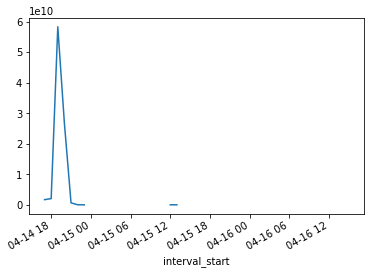

In [129]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

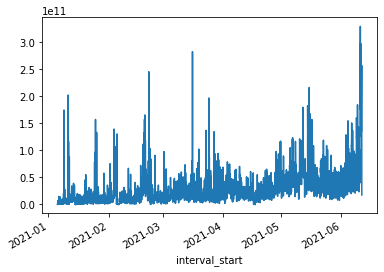

In [130]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### Template candidate 1

<AxesSubplot:xlabel='interval_start'>

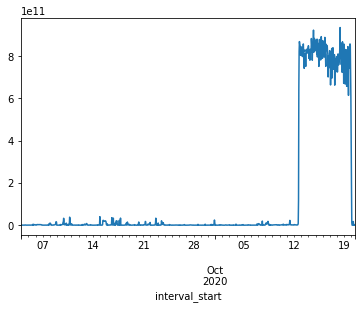

In [131]:
# Plotting template candidate 1
eu_template1 = eu_bbr_dlsusproj1_df.iloc[1900:3020,0]
eu_template1.plot()

In [132]:
template = list(eu_template1.dropna())
testsus0 = list(eu_bbr_dlsusproj1_df.iloc[:,0].dropna())
testsus1 = list(eu_bbr_dlsusproj1_df.iloc[:,1].dropna())
testsus2 = list(eu_bbr_dlsusproj1_df.iloc[:,2].dropna())

testnosus0 = list(eu_bbr_dlnosus1_df.iloc[:,0].dropna())
testnosus1 = list(eu_bbr_dlnosus1_df.iloc[:,1].dropna())

0.5192139577706957


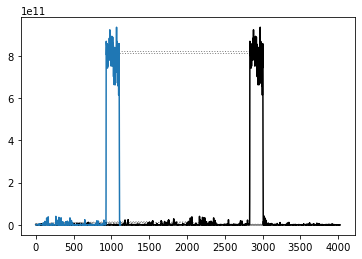

<AxesSubplot:>

In [133]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

19.537633854934633


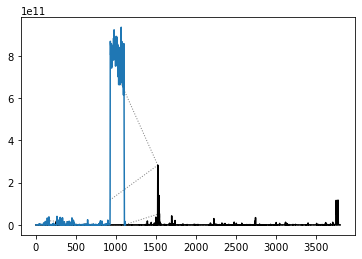

<AxesSubplot:>

In [134]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

79.77331816832


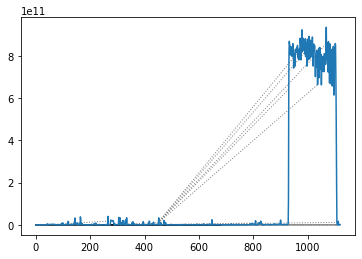

<AxesSubplot:>

In [135]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [136]:
sus_scores = list()
for i in range(len(eu_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(eu_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6708015135532954
1 0.3894306669756117
2 0.7326141976649149
3 0.10263587495348381
4 0.9076303907000183
5 0.9934582114049075
6 0.8807309619558279
7 0.8083185653049787
8 0.3512687408247418
9 0.7180756127294528
10 0.11070245478210239
11 0.333193930009841
12 0.8903863108839988
13 0.04515264204791147
14 0.4932529043789098
15 0.07565187481798319
16 0.35562640388377653
17 0.8557614721882402
18 0.2492676100406538
19 0.7854977908597212


(array([1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 2., 1., 0., 0., 0., 1.]),
 array([0.04515264, 0.06411875, 0.08308486, 0.10205098, 0.12101709,
        0.1399832 , 0.15894931, 0.17791542, 0.19688153, 0.21584764,
        0.23481376, 0.25377987, 0.27274598, 0.29171209, 0.3106782 ,
        0.32964431, 0.34861042, 0.36757654, 0.38654265, 0.40550876,
        0.42447487, 0.44344098, 0.46240709, 0.4813732 , 0.50033932,
        0.51930543, 0.53827154, 0.55723765, 0.57620376, 0.59516987,
        0.61413598, 0.6331021 , 0.65206821, 0.67103432, 0.69000043,
        0.70896654, 0.72793265, 0.74689876, 0.76586487, 0.78483099,
        0.8037971 , 0.82276321, 0.84172932, 0.86069543, 0.87966154,
        0.89862765, 0.91759377, 0.93655988, 0.95552599, 0.9744921 ,
        0.99345821]),
 <BarContainer object of 50 artists>)

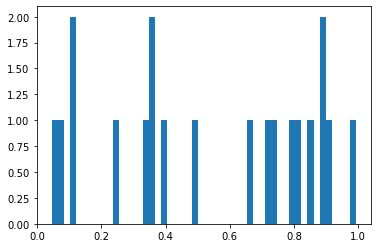

In [137]:
# Plotting scores histogram
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

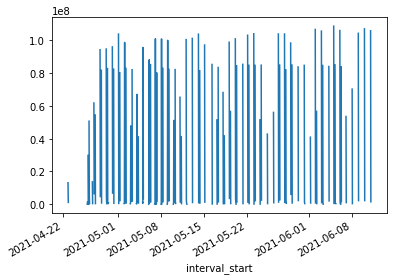

In [138]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

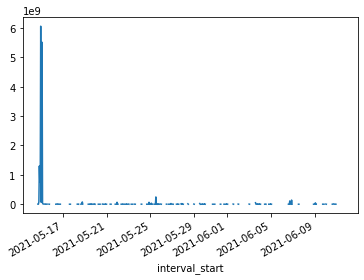

In [139]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

75.91376505574503


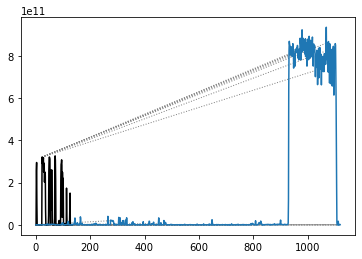

<AxesSubplot:>

In [140]:
alignment = dtw(testnosus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

28.847002049433915


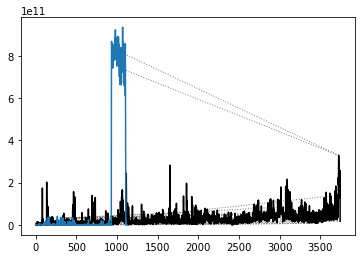

<AxesSubplot:>

In [141]:
alignment = dtw(testnosus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [142]:
nosus_scores = list()
for i in range(len(eu_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(eu_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.8028879552445652
1 0.17047470422685496
2 0.02642739440148356
3 0.13177974840173234
4 0.059555725775564894
5 0.314834673815907
6 0.1497725232728011
7 0.15624069109323802
8 0.3973610892078011
9 0.2998212689901698
10 0.906568815952194
11 0.18167481469799718
12 0.24537214349546788
13 0.8343251779740416
14 0.47321162602663946
15 0.5467066183041581
16 0.2033328076538926
17 0.9770657458259947
18 0.4916154129212007
19 0.3920166815609175
20 0.061811140899612704


(array([1., 2., 0., 0., 0., 1., 2., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.02642739, 0.04544016, 0.06445293, 0.0834657 , 0.10247846,
        0.12149123, 0.140504  , 0.15951676, 0.17852953, 0.1975423 ,
        0.21655506, 0.23556783, 0.2545806 , 0.27359337, 0.29260613,
        0.3116189 , 0.33063167, 0.34964443, 0.3686572 , 0.38766997,
        0.40668273, 0.4256955 , 0.44470827, 0.46372104, 0.4827338 ,
        0.50174657, 0.52075934, 0.5397721 , 0.55878487, 0.57779764,
        0.59681041, 0.61582317, 0.63483594, 0.65384871, 0.67286147,
        0.69187424, 0.71088701, 0.72989977, 0.74891254, 0.76792531,
        0.78693808, 0.80595084, 0.82496361, 0.84397638, 0.86298914,
        0.88200191, 0.90101468, 0.92002744, 0.93904021, 0.95805298,
        0.97706575]),
 <BarContainer object of 50 artists>)

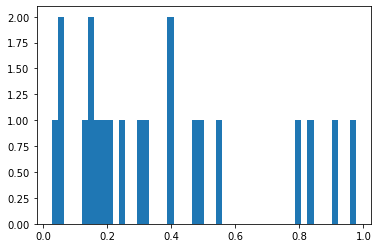

In [143]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

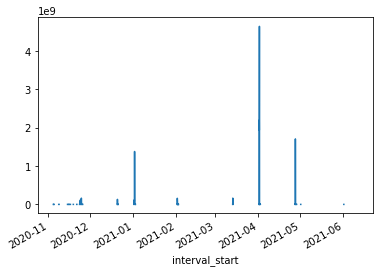

In [144]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

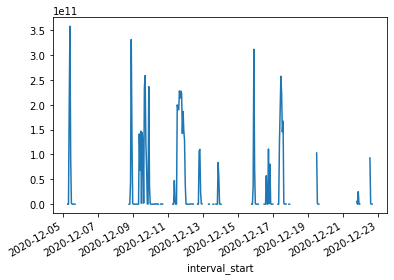

In [145]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### Template candidate 2

<AxesSubplot:xlabel='interval_start'>

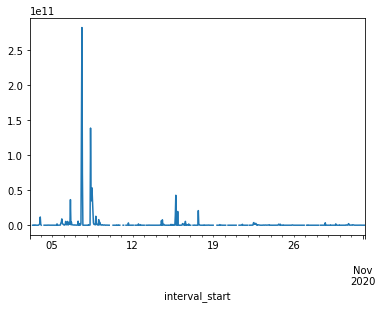

In [146]:
# Plotting template candidate 2
eu_template2 = eu_bbr_dlsusproj1_df.iloc[2600:3300,1]
eu_template2.plot()

In [147]:
template = list(eu_template2.dropna())
testsus0 = list(eu_bbr_dlsusproj1_df.iloc[:,0].dropna())
testsus1 = list(eu_bbr_dlsusproj1_df.iloc[:,1].dropna())
testsus2 = list(eu_bbr_dlsusproj1_df.iloc[:,2].dropna())

testnosus0 = list(eu_bbr_dlnosus1_df.iloc[:,0].dropna())
testnosus1 = list(eu_bbr_dlnosus1_df.iloc[:,1].dropna())

20.765974105141385


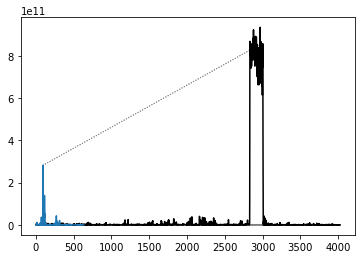

<AxesSubplot:>

In [148]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.4268576835559559


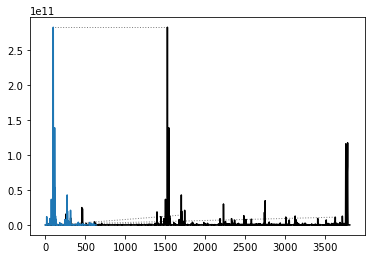

<AxesSubplot:>

In [149]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.8764922772927757


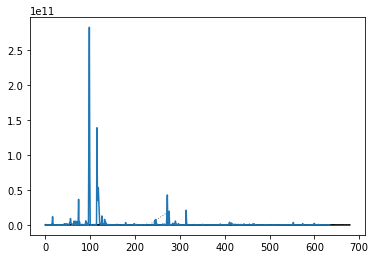

<AxesSubplot:>

In [150]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [151]:
sus_scores = list()
for i in range(len(eu_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(eu_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.8533459073909596
1 0.8639999149856742
2 0.837816110985238
3 0.26080279748744184
4 0.8113048690434627
5 0.84974021154203
6 0.9789708678620269
7 0.5174570924450623
8 0.6500543127232591
9 0.5812678383656302
10 0.9561952771216756
11 0.6229810962026874
12 0.583289225753181
13 0.7488043146433296
14 0.34392744479495263
15 0.8163179096832214
16 0.21987381703470033
17 0.9561575449450247
18 0.6267935280350057
19 0.9035207694513688


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 2.,
        0., 0., 0., 1., 0., 0., 0., 2., 1.]),
 array([0.21987382, 0.23252543, 0.24517705, 0.25782867, 0.27048029,
        0.2831319 , 0.29578352, 0.30843514, 0.32108676, 0.33373837,
        0.34638999, 0.35904161, 0.37169323, 0.38434484, 0.39699646,
        0.40964808, 0.4222997 , 0.43495131, 0.44760293, 0.46025455,
        0.47290617, 0.48555778, 0.4982094 , 0.51086102, 0.52351264,
        0.53616425, 0.54881587, 0.56146749, 0.57411911, 0.58677072,
        0.59942234, 0.61207396, 0.62472558, 0.63737719, 0.65002881,
        0.66268043, 0.67533205, 0.68798367, 0.70063528, 0.7132869 ,
        0.72593852, 0.73859014, 0.75124175, 0.76389337, 0.77654499,
        0.78919661, 0.80184822, 0.81449984, 0.82715146, 0.83980308,
        0.85245469, 0.86510631, 0.87775793, 0.

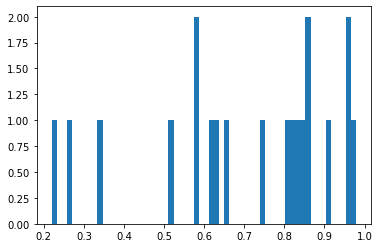

In [152]:
# Plotting scores histogram
plt.hist(sus_scores, bins=60)

<AxesSubplot:xlabel='interval_start'>

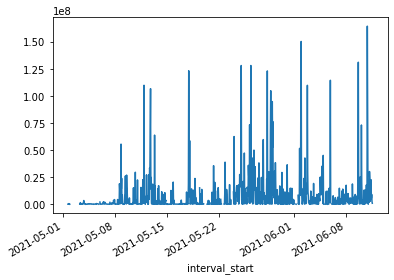

In [153]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

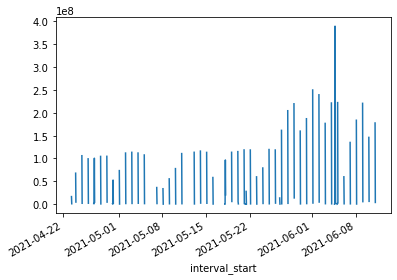

In [154]:
eu_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

8.711757408748053


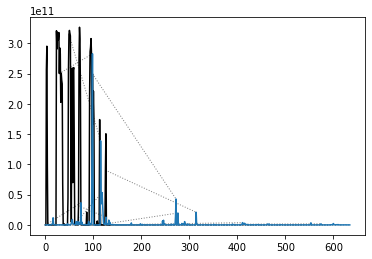

<AxesSubplot:>

In [155]:
alignment = dtw(testnosus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

13.87777823509041


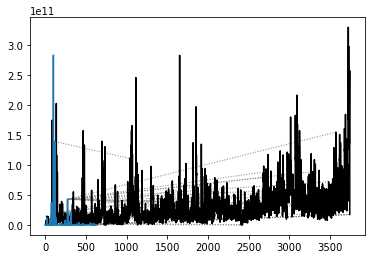

<AxesSubplot:>

In [156]:
alignment = dtw(testnosus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [157]:
nosus_scores = list()
for i in range(len(eu_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(eu_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.823097383093434
1 0.5529215123122557
2 0.5433252493572327
3 0.5553263770929386
4 0.9674402884182064
5 0.698527865404837
6 0.43723145870124125
7 0.6735015772870663
8 0.7265726479866395
9 0.8412854889589905
10 0.9803073483296694
11 0.8782705511226573
12 0.7856016223524109
13 0.9809668152899917
14 0.6297130839717591
15 0.9115791426980887
16 0.9995360920393394
17 0.47174154951864666
18 0.6709036927073668
19 0.9618647038205398
20 0.9112776025236593


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 1., 2., 1.]),
 array([0.43723146, 0.44847755, 0.45972364, 0.47096974, 0.48221583,
        0.49346192, 0.50470801, 0.51595411, 0.5272002 , 0.53844629,
        0.54969239, 0.56093848, 0.57218457, 0.58343066, 0.59467676,
        0.60592285, 0.61716894, 0.62841503, 0.63966113, 0.65090722,
        0.66215331, 0.6733994 , 0.6846455 , 0.69589159, 0.70713768,
        0.71838378, 0.72962987, 0.74087596, 0.75212205, 0.76336815,
        0.77461424, 0.78586033, 0.79710642, 0.80835252, 0.81959861,
        0.8308447 , 0.84209079, 0.85333689, 0.86458298, 0.87582907,
        0.88707517, 0.89832126, 0.90956735, 0.92081344, 0.93205954,
        0.94330563, 0.95455172, 0.96579781, 0.97704391, 0.98829   ,
        0.99953609]),
 <BarContainer object of 50 artists>)

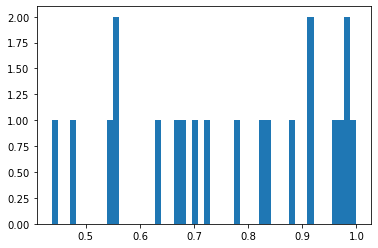

In [158]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

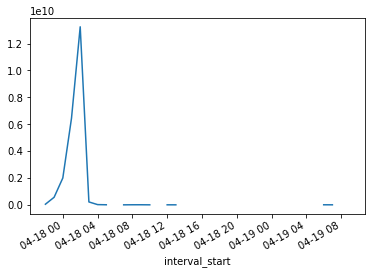

In [159]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

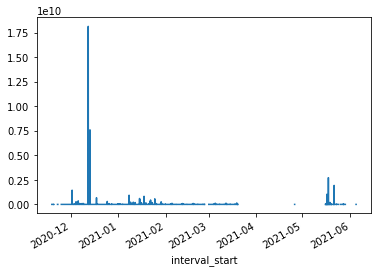

In [160]:
eu_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

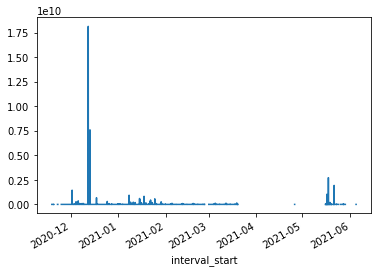

In [185]:
# Checking project that was scored around 0
eu_bbr_dlnosus1_df.iloc[:,6].plot()

### US Region Data (us_bbr)

In [161]:
us_bbr['month'] = us_bbr['interval_start'].dt.to_period('M')
us_bbr_dlsuscount = us_bbr[(us_bbr['inline']==0) & (us_bbr['settled']==0) & (us_bbr['action']==2)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
us_bbr_dlsuscount = us_bbr_dlsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'dl_cancel_count'}, axis=1).reset_index(drop=True)
us_bbr_dlsuscount

project_id  dl_cancel_count
0    0276add01fd94ae484e926afe29a031a              147
1    75ba7cc203b3411d8cb5f62e9a1286b7              132
2    91c84be747f34cccb0363d4fd8242e3d               84
3    c633be39a19f4e259068364f684f2614               82
4    5d91665c1ab0418089bdf29488c70c5b               80
..                                ...              ...
693  6e8cae8756504e2c8eeec0bb59a63817                1
694  6ed90c32e5bb4e32bc84940d20d98805                1
695  6efc0ef7fbf84271bf69525aaaf5ccac                1
696  6f618d6fb0934af88582302ea9eb223e                1
697  7cafa93a05b74a1b9b3c907cfd05f687                1

[698 rows x 2 columns]

In [162]:
us_bbr_dlsuscount['dl_cancel_count'].value_counts()

1      431
2      101
3       60
4       24
5       12
6        8
7        7
15       6
10       6
12       6
16       5
8        4
14       3
44       1
84       1
82       1
80       1
79       1
77       1
132      1
76       1
74       1
67       1
46       1
45       1
23       1
39       1
35       1
32       1
30       1
28       1
22       1
21       1
18       1
17       1
13       1
9        1
147      1
Name: dl_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [163]:
# Narrowing down eu_bbr for future plotting purpose
us_bbr = us_bbr.groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index()
us_bbr_download = us_bbr[us_bbr['action']==2][['project_id', 'interval_start', 'settled']]
us_bbr_download

project_id      interval_start       settled
10      2e1e9468e497490d89544666a1760e3a 2020-06-16 14:00:00  192471493376
11      321590f2b8294783bf21d76541b30f67 2020-06-16 14:00:00             0
12      40d0af33125649d5adbf343920fa3751 2020-06-16 14:00:00   12405925888
13      4624db856a994966bb5dcae6e437c87c 2020-06-16 14:00:00             0
14      77c757dc75dc4fd2b2dafc20b0a48b60 2020-06-16 14:00:00             0
...                                  ...                 ...           ...
212348  75ba7cc203b3411d8cb5f62e9a1286b7 2021-06-11 13:00:00     953689856
212349  89ecf24740654ee984c47957d23ec886 2021-06-11 13:00:00          5888
212350  d346180ab62e4142aeb0d34a31fdd382 2021-06-11 13:00:00       3868160
212351  eddb79195f3241c884df12ea93b44529 2021-06-11 13:00:00             0
212352  f82708edb49e40f9956d0bd72ba0cdbf 2021-06-11 13:00:00        484864

[75106 rows x 3 columns]

In [166]:
# Focusing first on projects with more than 30 times download cancellations
us_bbr_dlsusproj1 = us_bbr_dlsuscount[us_bbr_dlsuscount['dl_cancel_count']>30]
us_bbr_dlsusproj1

project_id  dl_cancel_count
0   0276add01fd94ae484e926afe29a031a              147
1   75ba7cc203b3411d8cb5f62e9a1286b7              132
2   91c84be747f34cccb0363d4fd8242e3d               84
3   c633be39a19f4e259068364f684f2614               82
4   5d91665c1ab0418089bdf29488c70c5b               80
5   276d649ffb4149c18c48d0b7de487aec               79
6   0fc6c670c8c349b8a917b3f5b1ac5e68               77
7   db34f21f987044eaaadb13f516b79f5c               76
8   d041a5c274e1471fa603e00b2143414e               74
9   d346180ab62e4142aeb0d34a31fdd382               67
10  22c86abe69a845178764dec325a59dfe               46
11  e1e17bb6fb874b4794d1e6ac9426e78f               45
12  d1c8f2afeca542c8ba544c02803a045d               44
13  c9a530c68fed4385859e2b9608fa0084               39
14  89ecf24740654ee984c47957d23ec886               35
15  1132595a519d416e90cd5f5157039fc6               32

In [167]:
us_bbr_dlsusproj1_df = us_bbr_download[us_bbr_download['project_id'].isin(list(us_bbr_dlsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
us_bbr_dlsusproj1_df = us_bbr_dlsusproj1_df[list(us_bbr_dlsusproj1['project_id'])]
us_bbr_dlsusproj1_df

project_id           0276add01fd94ae484e926afe29a031a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           75ba7cc203b3411d8cb5f62e9a1286b7  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.460766e+10   
2021-06-11 10:00:00                      6.232017e+09   
2021-06-11 11:00:00                      7.947056e+09   
2021-06-11 12:00:00                      7.737266e+09   
2021-06-11 13:00:00                      9.536899e+08   

project_id           91c84be747f34cccb0363d4fd8242e3d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           c633be39a19f4e259068364f684f2614  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           5d91665c1ab0418089bdf29488c70c5b  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               0.0   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                           35840.0   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           276d649ffb4149c18c48d0b7de487aec  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

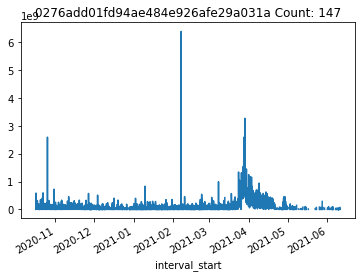

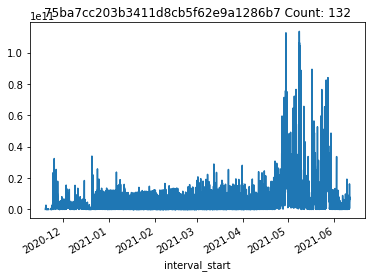

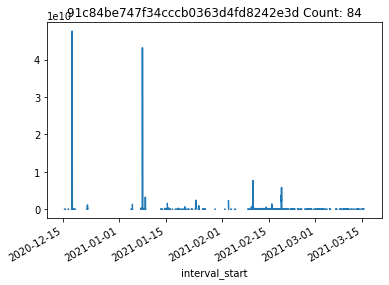

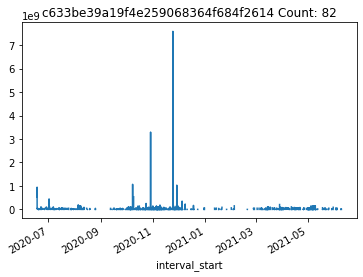

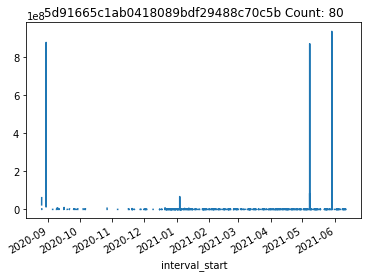

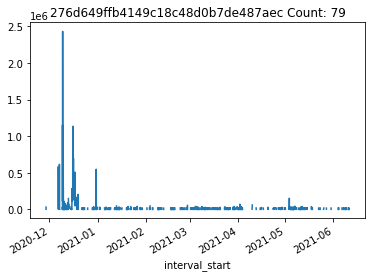

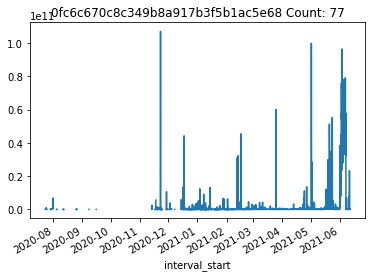

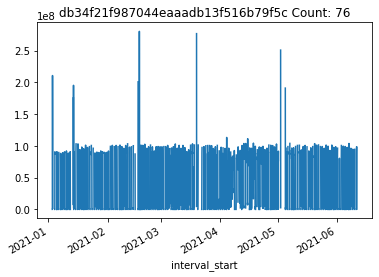

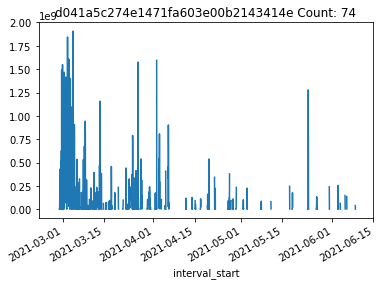

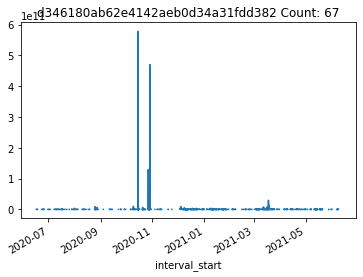

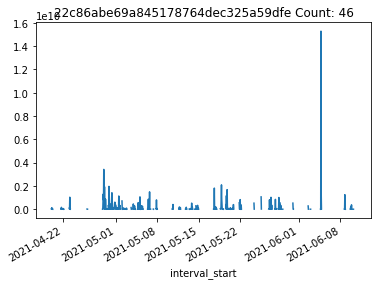

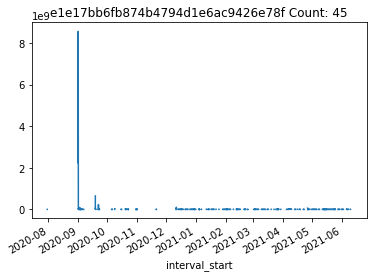

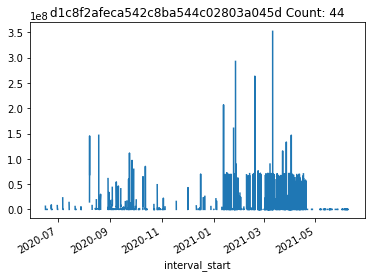

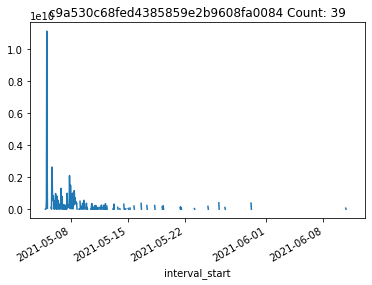

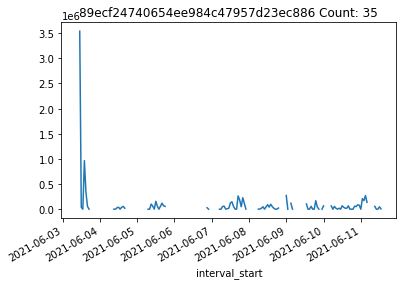

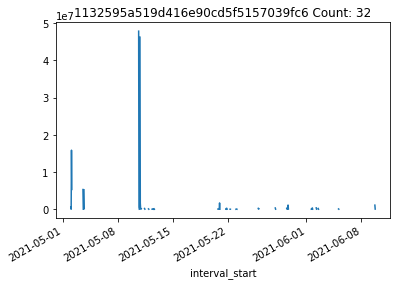

In [168]:
for i in range(len(us_bbr_dlsusproj1_df.columns)):
    proj_id = us_bbr_dlsusproj1.loc[i, 'project_id']
    cancel_count = us_bbr_dlsusproj1.loc[i, 'dl_cancel_count']
    plt.figure()
    us_bbr_dlsusproj1_df.iloc[:,i].plot(title=proj_id + ' Count: ' + str(cancel_count))

#### Comparing to non-suspected projects' usage patterns

In [169]:
us_bbr_dlnosussum = us_bbr_download[~us_bbr_download['project_id'].isin(list(us_bbr_dlsuscount['project_id']))].groupby('project_id').agg({'settled':'sum'}).sort_values(by='settled', ascending=False)
us_bbr_dlnosussum = us_bbr_dlnosussum.rename({'settled': 'settled_sum'}, axis=1).reset_index()
us_bbr_dlnosussum

project_id    settled_sum
0    321590f2b8294783bf21d76541b30f67  1248499906560
1    a1e5565ed55942e5b8b11b1037e0a787   384610895360
2    1a6d04e0ebc84c6382f03ecfe64368a3   249446252544
3    20574ac9ab424c3a8e708ea5f6a8603c   215931397888
4    48f425bd60b64c288d855a9e93ce92a6   152377132800
..                                ...            ...
361  b6e46a84049b42c79566a6d34b02e942              0
362  4b00a32c776142118ca5312621c5238a              0
363  4b2b2cfadd7946f1b4ac80417a704a51              0
364  4faea1be6e8c485c816ac98e3a193dbd              0
365  823842e049064873b8a0c130f48e6357              0

[366 rows x 2 columns]

In [170]:
# Zooming in first to the top 20 projects with highest total amount settled
us_bbr_dlnosusproj1 = us_bbr_dlnosussum.loc[:20,:]
us_bbr_dlnosusproj1

project_id    settled_sum
0   321590f2b8294783bf21d76541b30f67  1248499906560
1   a1e5565ed55942e5b8b11b1037e0a787   384610895360
2   1a6d04e0ebc84c6382f03ecfe64368a3   249446252544
3   20574ac9ab424c3a8e708ea5f6a8603c   215931397888
4   48f425bd60b64c288d855a9e93ce92a6   152377132800
5   a60cfe92d2704ab493c1272d5973b356    47421566464
6   91ef3fa3581144ecad76614e579fd003    36441541632
7   2732d93d0fc845fbb14fd3ace216fd80    22436419328
8   bcc06782ad0a42a3b211b0c2d06ba835    22331935232
9   098c6afde24b4b648627070315e61544    18875077120
10  a46cee78b34348ea94df9145aea970f8    15322432512
11  8209ace541cc422e8ba63dedfa566847    14536161792
12  d0f9600c8d9e49048011071a21537758    13789658880
13  b31380944c3d4af88fb20bfecfd89b4a    12477177600
14  f2fd7843b8ea42748194e5d2f509acfa     8776996352
15  c9e6a5e4aa184b2f92acd6a9e4e1f135     7247289856
16  0f727ffa4aee4ad8b5c265730c9230ac     6320682752
17  fb1be11a030a4bbbb25321ec1225a4d3     5861582848
18  2250453e88304a68b481b383c75218a3     3619866368
19  c9a3fbfb34764f5ba954031c01f6de05     3491265536
20  6e29b31979644df189a2f5b3a2d15964     2796039936

In [171]:
us_bbr_dlnosus1_df = us_bbr_download[us_bbr_download['project_id'].isin(list(us_bbr_dlnosusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
us_bbr_dlnosus1_df = us_bbr_dlnosus1_df[list(us_bbr_dlnosusproj1['project_id'])]
us_bbr_dlnosus1_df

project_id           321590f2b8294783bf21d76541b30f67  \
interval_start                                          
2020-06-16 14:00:00                               0.0   
2020-06-16 15:00:00                               0.0   
2020-06-16 16:00:00                               0.0   
2020-06-16 17:00:00                               0.0   
2020-06-16 18:00:00                               0.0   
...                                               ...   
2021-06-11 07:00:00                               NaN   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   

project_id           a1e5565ed55942e5b8b11b1037e0a787  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 07:00:00                               NaN   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   

project_id           1a6d04e0ebc84c6382f03ecfe64368a3  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 07:00:00                               NaN   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   

project_id           20574ac9ab424c3a8e708ea5f6a8603c  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 07:00:00                               NaN   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   

project_id           48f425bd60b64c288d855a9e93ce92a6  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 07:00:00                               NaN   
2021-06-11 08:00:00                               NaN   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   

project_id           a60cfe92d2704ab493c1272d5973b356  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


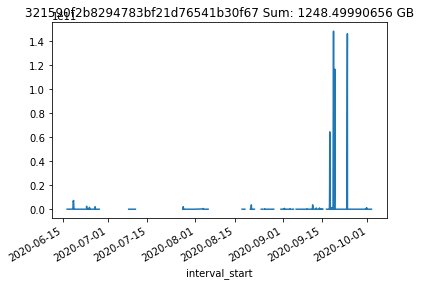

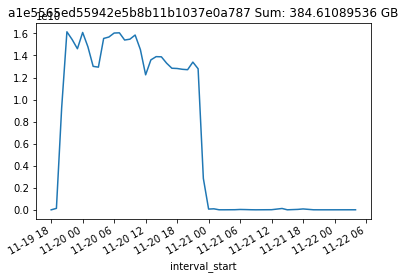

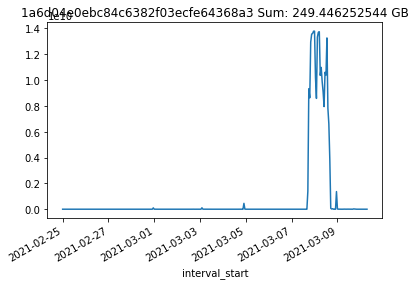

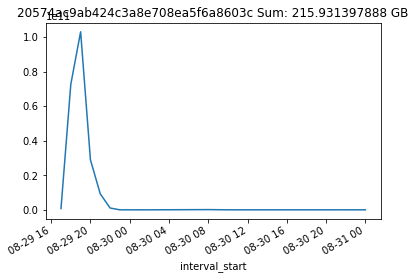

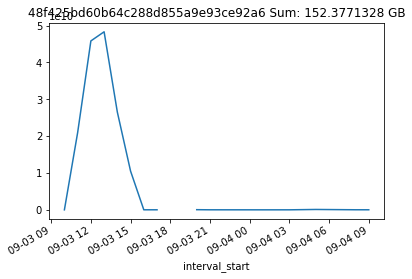

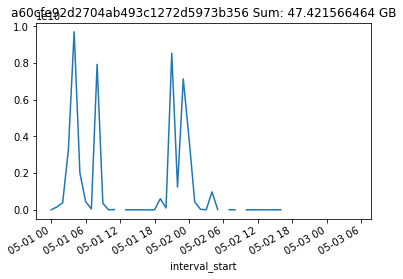

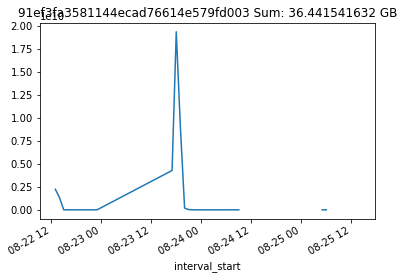

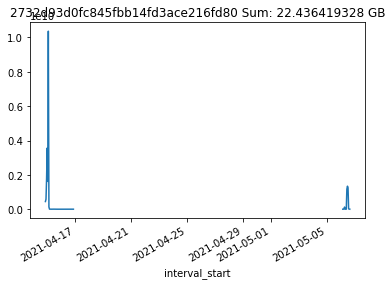

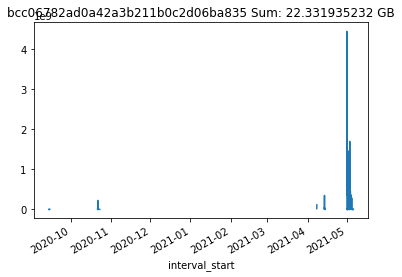

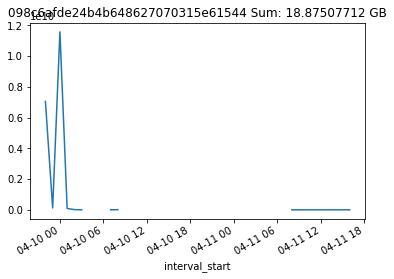

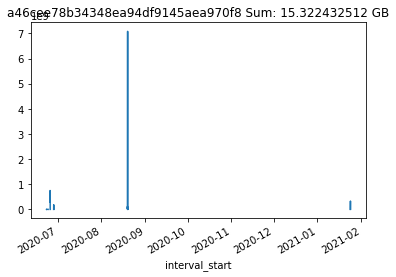

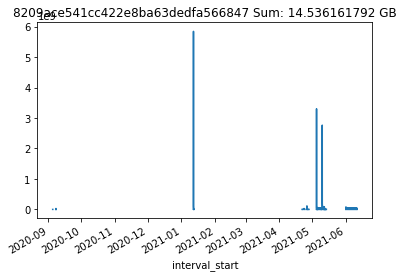

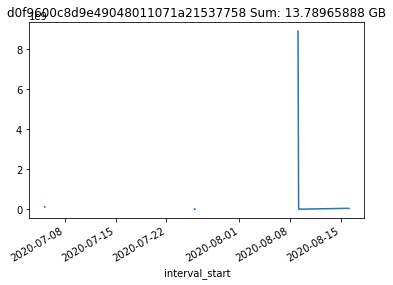

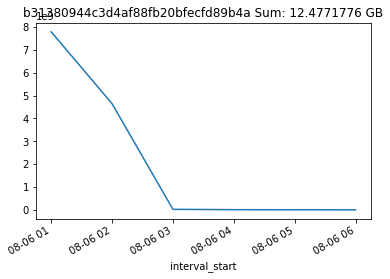

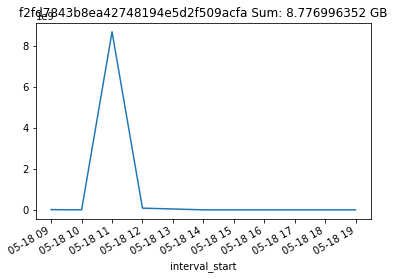

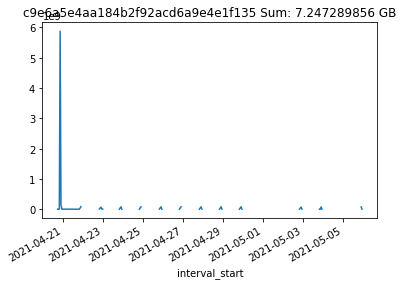

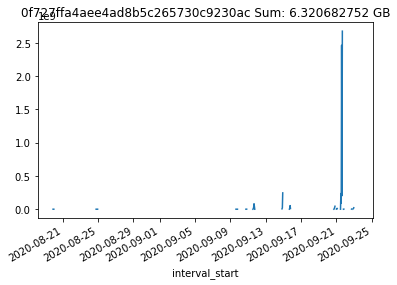

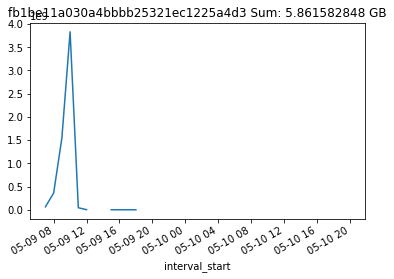

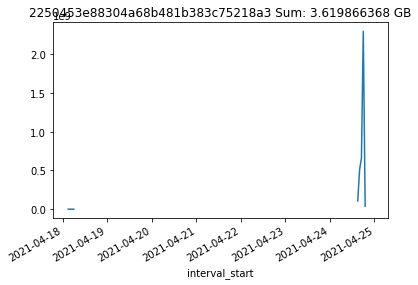

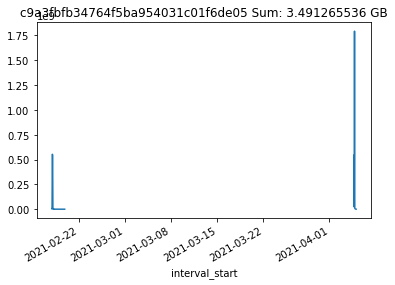

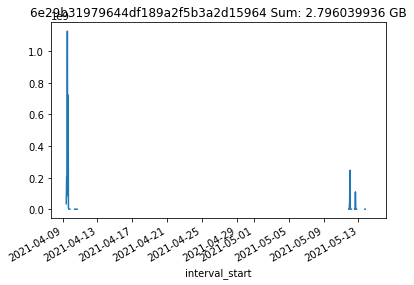

In [172]:
for i in range(len(us_bbr_dlnosus1_df.columns)):
    proj_id = us_bbr_dlnosusproj1.loc[i, 'project_id']
    settled_sum = us_bbr_dlnosusproj1.loc[i, 'settled_sum']/1e9
    plt.figure()
    us_bbr_dlnosus1_df.iloc[:,i].plot(title=proj_id + ' Sum: ' + str(settled_sum) + ' GB')

#### Selecting template pattern for DTW matching

##### Template candidate 1

<AxesSubplot:xlabel='interval_start'>

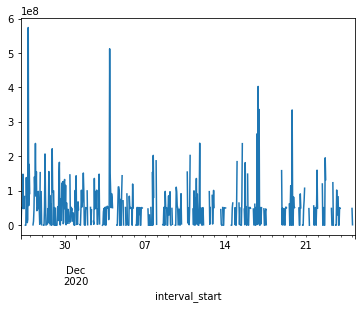

In [173]:
# Plotting template candidate 1
us_template1 = us_bbr_dlsusproj1_df.iloc[2000:2700,0]
us_template1.plot()

In [174]:
template = list(us_template1.dropna())
testsus0 = list(us_bbr_dlsusproj1_df.iloc[:,0].dropna())
testsus1 = list(us_bbr_dlsusproj1_df.iloc[:,1].dropna())
testsus2 = list(us_bbr_dlsusproj1_df.iloc[:,2].dropna())

testnosus0 = list(us_bbr_dlnosus1_df.iloc[:,0].dropna())
testnosus1 = list(us_bbr_dlnosus1_df.iloc[:,1].dropna())

0.06228466632893884


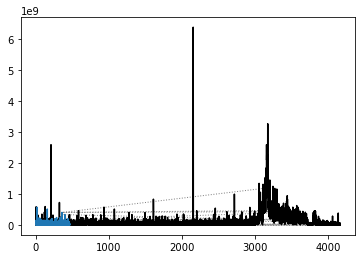

<AxesSubplot:>

In [175]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

4.750308387166764


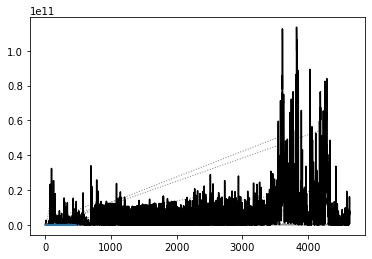

<AxesSubplot:>

In [176]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

0.14729846048026868


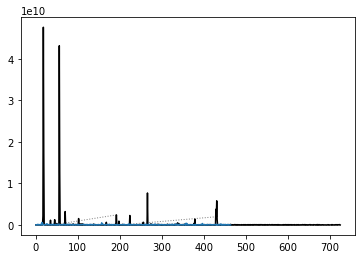

<AxesSubplot:>

In [177]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [178]:
sus_scores = list()
for i in range(len(us_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(us_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.49003404174090104
1 0.8223186328232025
2 0.8485281003007624
3 0.6277708159754884
4 0.4981713688610241
5 0.02767816565358172
6 0.8550858720452257
7 0.594458818977608
8 0.7993981665507304
9 0.5836408718717565
10 0.9304767371339456
11 0.13289345167317823
12 0.5057617212838277
13 0.9654150564803805
14 0.017606662770309756
15 0.4124374304783093


(array([2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.]),
 array([0.01760666, 0.03656283, 0.055519  , 0.07447517, 0.09343133,
        0.1123875 , 0.13134367, 0.15029984, 0.16925601, 0.18821217,
        0.20716834, 0.22612451, 0.24508068, 0.26403685, 0.28299301,
        0.30194918, 0.32090535, 0.33986152, 0.35881768, 0.37777385,
        0.39673002, 0.41568619, 0.43464236, 0.45359852, 0.47255469,
        0.49151086, 0.51046703, 0.5294232 , 0.54837936, 0.56733553,
        0.5862917 , 0.60524787, 0.62420403, 0.6431602 , 0.66211637,
        0.68107254, 0.70002871, 0.71898487, 0.73794104, 0.75689721,
        0.77585338, 0.79480955, 0.81376571, 0.83272188, 0.85167805,
        0.87063422, 0.88959038, 0.90854655, 0.92750272, 0.94645889,
        0.96541506]),
 <BarContainer object of 50 artists>)

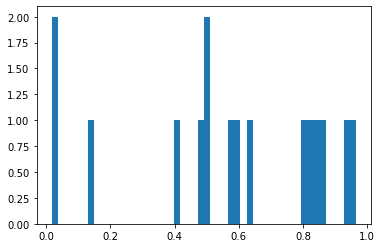

In [179]:
# Plotting scores histogram
plt.hist(sus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

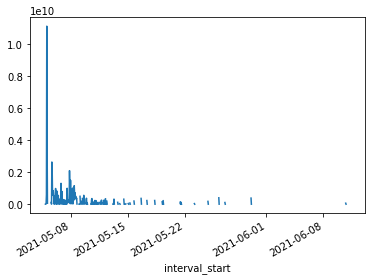

In [180]:
us_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

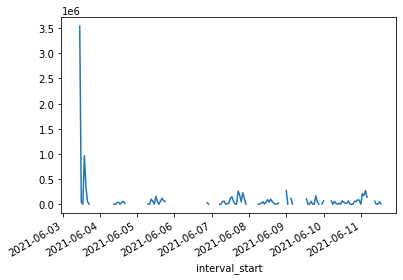

In [181]:
us_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [182]:
nosus_scores = list()
for i in range(len(us_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(us_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.5889509138873186
1 0.3212123991195891
2 0.3003431536658855
3 0.22811671087533159
4 0.8676108374384237
5 0.6155285843920145
6 0.9404047976011994
7 0.07075123152709362
8 0.9254382787597798
9 0.8819444444444444
10 0.7807526525198939
11 0.8555221210149642
12 0.21695402298850575
13 0.9886853448275862
14 0.4173850574712644
15 0.5827504879635654
16 0.8860067733990148
17 0.606763925729443
18 0.2925646551724138
19 0.7286140583554377
20 0.9790044493882091


(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 2.]),
 array([0.07075123, 0.08910991, 0.1074686 , 0.12582728, 0.14418596,
        0.16254464, 0.18090333, 0.19926201, 0.21762069, 0.23597937,
        0.25433805, 0.27269674, 0.29105542, 0.3094141 , 0.32777278,
        0.34613147, 0.36449015, 0.38284883, 0.40120751, 0.41956619,
        0.43792488, 0.45628356, 0.47464224, 0.49300092, 0.51135961,
        0.52971829, 0.54807697, 0.56643565, 0.58479433, 0.60315302,
        0.6215117 , 0.63987038, 0.65822906, 0.67658775, 0.69494643,
        0.71330511, 0.73166379, 0.75002248, 0.76838116, 0.78673984,
        0.80509852, 0.8234572 , 0.84181589, 0.86017457, 0.87853325,
        0.89689193, 0.91525062, 0.9336093 , 0.95196798, 0.97032666,
        0.98868534]),
 <BarContainer object of 50 artists>)

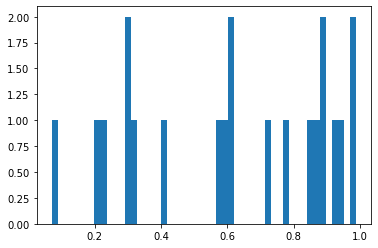

In [183]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

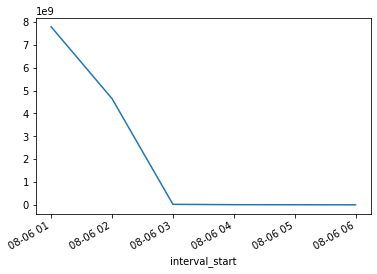

In [184]:
us_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

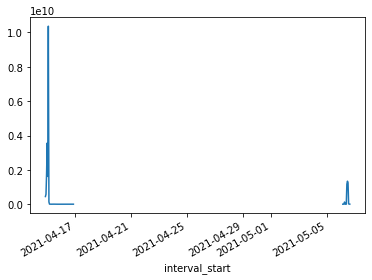

In [185]:
us_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### Template candidate 2

<AxesSubplot:xlabel='interval_start'>

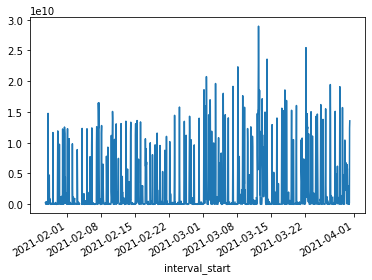

In [189]:
# Plotting template candidate 2
us_template2 = us_bbr_dlsusproj1_df.iloc[3500:5000,1]
us_template2.plot()

In [190]:
template = list(us_template2.dropna())
testsus0 = list(us_bbr_dlsusproj1_df.iloc[:,0].dropna())
testsus1 = list(us_bbr_dlsusproj1_df.iloc[:,1].dropna())
testsus2 = list(us_bbr_dlsusproj1_df.iloc[:,2].dropna())

testnosus0 = list(us_bbr_dlnosus1_df.iloc[:,0].dropna())
testnosus1 = list(us_bbr_dlnosus1_df.iloc[:,1].dropna())

0.5599395310200977


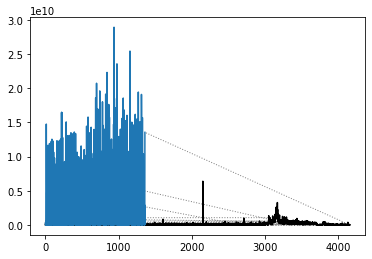

<AxesSubplot:>

In [191]:
alignment = dtw(testsus0, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

2.485588126703784


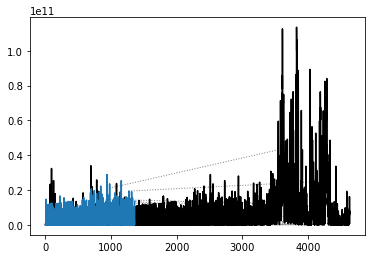

<AxesSubplot:>

In [192]:
alignment = dtw(testsus1, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

1.37712384208529


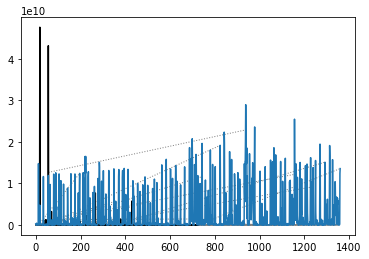

<AxesSubplot:>

In [193]:
alignment = dtw(testsus2, template, keep_internals=True)
print(alignment.normalizedDistance/1e9)
alignment.plot(type="twoway")

In [194]:
sus_scores = list()
for i in range(len(us_bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(us_bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6825504418946551
1 0.658417324473383
2 0.23645131845841783
3 0.5020825995068686
4 0.537455026920948
5 0.06651867992627858
6 0.7328840988450175
7 0.9832407407407407
8 0.7195189474753632
9 0.4760344682285522
10 0.7857153414129471
11 0.06571745820801567
12 0.6522676437203712
13 0.41525101419878296
14 0.053433449651046905
15 0.38385910815939284


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.05343345, 0.06893024, 0.08442703, 0.09992381, 0.1154206 ,
        0.13091739, 0.14641418, 0.16191097, 0.17740776, 0.19290454,
        0.20840133, 0.22389812, 0.23939491, 0.2548917 , 0.27038848,
        0.28588527, 0.30138206, 0.31687885, 0.33237564, 0.34787243,
        0.36336921, 0.378866  , 0.39436279, 0.40985958, 0.42535637,
        0.44085315, 0.45634994, 0.47184673, 0.48734352, 0.50284031,
        0.5183371 , 0.53383388, 0.54933067, 0.56482746, 0.58032425,
        0.59582104, 0.61131782, 0.62681461, 0.6423114 , 0.65780819,
        0.67330498, 0.68880177, 0.70429855, 0.71979534, 0.73529213,
        0.75078892, 0.76628571, 0.78178249, 0.79727928, 0.81277607,
        0.82827286, 0.84376965, 0.85926644, 0.

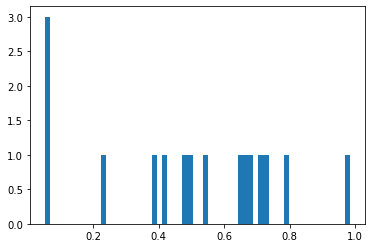

In [195]:
# Plotting scores histogram
plt.hist(sus_scores, bins=60)

<AxesSubplot:xlabel='interval_start'>

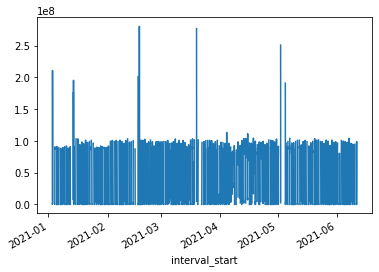

In [196]:
us_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

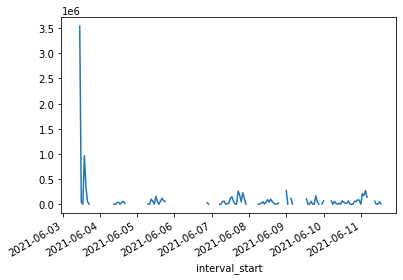

In [197]:
us_bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [198]:
nosus_scores = list()
for i in range(len(us_bbr_dlnosus1_df.columns)):
    alignment = dtw(list(us_bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.8707560410056139
1 0.5244367959949938
2 0.7670188463735008
3 0.4902714932126697
4 0.48792016806722693
5 0.6832236842105264
6 0.3986892583120205
7 0.4356302521008404
8 0.5470217498764212
9 0.36535947712418304
10 0.9868778280542987
11 0.25055031446540876
12 0.5257352941176471
13 0.9963235294117647
14 0.3188725490196078
15 0.4176609322974473
16 0.7349002100840336
17 0.22449095022624432
18 0.9710477941176471
19 0.9720588235294118
20 0.18249525616698292


(array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2.]),
 array([0.18249526, 0.19877182, 0.21504839, 0.23132495, 0.24760152,
        0.26387808, 0.28015465, 0.29643121, 0.31270778, 0.32898435,
        0.34526091, 0.36153748, 0.37781404, 0.39409061, 0.41036717,
        0.42664374, 0.4429203 , 0.45919687, 0.47547343, 0.49175   ,
        0.50802657, 0.52430313, 0.5405797 , 0.55685626, 0.57313283,
        0.58940939, 0.60568596, 0.62196252, 0.63823909, 0.65451565,
        0.67079222, 0.68706879, 0.70334535, 0.71962192, 0.73589848,
        0.75217505, 0.76845161, 0.78472818, 0.80100474, 0.81728131,
        0.83355787, 0.84983444, 0.86611101, 0.88238757, 0.89866414,
        0.9149407 , 0.93121727, 0.94749383, 0.9637704 , 0.98004696,
        0.99632353]),
 <BarContainer object of 50 artists>)

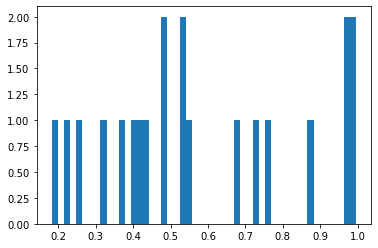

In [199]:
plt.hist(nosus_scores, bins=50)

<AxesSubplot:xlabel='interval_start'>

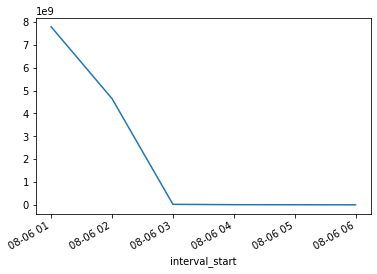

In [200]:
us_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

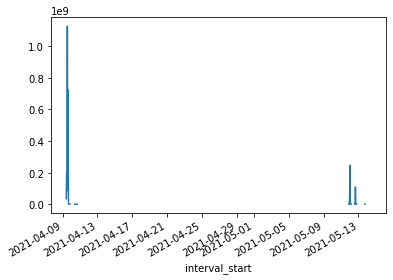

In [201]:
us_bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

### All Regions Combined

In [53]:
# Collating bbr data
ap_bbr = pd.read_csv('bucket_data/ap_bbr.csv')
eu_bbr = pd.read_csv('bucket_data/eu_bbr.csv')
us_bbr = pd.read_csv('bucket_data/us_bbr.csv')

ap_bbr['project_id'] = ap_bbr['project_id'].astype(str).str.lower()
eu_bbr['project_id'] = eu_bbr['project_id'].astype(str).str.lower()
us_bbr['project_id'] = us_bbr['project_id'].astype(str).str.lower()

ap_bbr['interval_start'] = pd.to_datetime(ap_bbr['interval_start'])
eu_bbr['interval_start'] = pd.to_datetime(eu_bbr['interval_start'])
us_bbr['interval_start'] = pd.to_datetime(us_bbr['interval_start'])

bbr = ap_bbr.append(eu_bbr).append(us_bbr).reset_index(drop=True)
bbr

Unnamed: 0      interval_start  action  inline   settled  \
0                 0 2021-06-04 14:00:00       1     126         0   
1                 1 2021-04-20 17:00:00       1       0  11766784   
2                 2 2021-04-20 17:00:00       2       0   8471040   
3                 3 2021-04-20 18:00:00       1       0    562432   
4                 4 2021-04-20 18:00:00       2       0    361216   
...             ...                 ...     ...     ...       ...   
1044495      237936 2021-03-10 13:00:00       2    2451         0   
1044496      237937 2021-03-10 15:00:00       2       0  75193856   
1044497      237938 2021-03-10 16:00:00       2       0   2381824   
1044498      237939 2021-02-12 22:00:00       2       0         0   
1044499      237940 2021-02-13 00:00:00       2       0   1345024   

                               project_id  
0        25f0aeda906b46ceb0a63f79037840c0  
1        a965308845f94c34a312cd34d0e30bc5  
2        a965308845f94c34a312cd34d0e30bc5  
3        a965308845f94c34a312cd34d0e30bc5  
4        a965308845f94c34a312cd34d0e30bc5  
...                                   ...  
1044495  99b54f4665b441269c87660036f8e42e  
1044496  99b54f4665b441269c87660036f8e42e  
1044497  99b54f4665b441269c87660036f8e42e  
1044498  d346180ab62e4142aeb0d34a31fdd382  
1044499  d346180ab62e4142aeb0d34a31fdd382  

[1044500 rows x 6 columns]

In [54]:
len(bbr) - len(bbr.drop_duplicates())

0

In [55]:
len(bbr.drop_duplicates().groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index())

629266

Within each region's file, we want to sum the inline and settled amounts of duplicate rows with the same project_id, interval_start and action EXCEPT when inline==0 and settled==0 (since these indicate multiple cancellations within an hour). For rows that are not cancellations, we can remove duplicates.

In [56]:
cancellation_mask = (bbr['inline']==0) & (bbr['settled']==0)
bbr = bbr[cancellation_mask].append(bbr[~cancellation_mask].drop_duplicates().groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index()).reset_index(drop=True)
bbr

Unnamed: 0      interval_start  action  inline  settled  \
0             41.0 2021-04-20 04:00:00       1       0        0   
1             42.0 2021-04-20 04:00:00       2       0        0   
2             43.0 2021-04-20 05:00:00       1       0        0   
3             44.0 2021-04-20 05:00:00       2       0        0   
4             56.0 2021-04-20 11:00:00       2       0        0   
...            ...                 ...     ...     ...      ...   
659183         NaN 2021-06-11 13:00:00       2       0    67072   
659184         NaN 2021-06-11 13:00:00       2     176        0   
659185         NaN 2021-06-11 13:00:00       2    4739        0   
659186         NaN 2021-06-11 13:00:00       2       0   195584   
659187         NaN 2021-06-11 13:00:00       2     649   484864   

                              project_id  
0       6b2d0a6d00c44b5abd88758afc2e4798  
1       6b2d0a6d00c44b5abd88758afc2e4798  
2       6b2d0a6d00c44b5abd88758afc2e4798  
3       6b2d0a6d00c44b5abd88758afc2e4798  
4       6b2d0a6d00c44b5abd88758afc2e4798  
...                                  ...  
659183  e2bc94727cc4497d8a3a7d93a4f068ad  
659184  eddb79195f3241c884df12ea93b44529  
659185  f6c05c9255a14ecabb3473d4c97e3705  
659186  f7877e7be74d4e9a8f2c7b90d0935cf5  
659187  f82708edb49e40f9956d0bd72ba0cdbf  

[659188 rows x 6 columns]

In [57]:
bbr['month'] = bbr['interval_start'].dt.to_period('M')
bbr_dlsuscount = bbr[(bbr['inline']==0) & (bbr['settled']==0) & (bbr['action']==2)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
bbr_dlsuscount = bbr_dlsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'dl_cancel_count'}, axis=1).reset_index(drop=True)
bbr_dlsuscount

project_id  dl_cancel_count
0     8118cf7c11224ffda2284716de755d21             8238
1     a56224e6a3f943baa6791431d2711271              260
2     0276add01fd94ae484e926afe29a031a              147
3     75ba7cc203b3411d8cb5f62e9a1286b7              132
4     50ce9633c7ab4abd9c12c9be63d6665e              125
...                                ...              ...
1974  69dc0cb12002472d905a7647981757e8                1
1975  69d85e47154f4733a08c9a885319fd80                1
1976  69bd1fd778f4431bb59b2b5ecec372b8                1
1977  69a353f2ac9e4c3eb81e38f7cb9a10e5                1
1978  fff103d31b114502a51ef83a52293e84                1

[1979 rows x 2 columns]

In [58]:
bbr_dlsuscount['dl_cancel_count'].value_counts()

1       1203
2        300
3        153
4         71
5         44
6         24
7         19
9         14
10        14
8         12
12        10
14        10
16         9
17         7
15         7
11         7
13         6
32         5
18         4
21         4
26         4
25         3
28         3
29         3
30         2
45         2
41         2
39         2
46         2
24         2
23         2
67         1
260        1
147        1
132        1
125        1
93         1
84         1
82         1
80         1
79         1
77         1
76         1
74         1
70         1
64         1
59         1
55         1
53         1
48         1
8238       1
19         1
44         1
42         1
20         1
22         1
38         1
36         1
35         1
33         1
Name: dl_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [59]:
# Narrowing down bbr for future plotting purpose
bbr_download = bbr[bbr['action']==2][['project_id', 'interval_start', 'settled']]
bbr_download = bbr_download.groupby(['interval_start','project_id']).aggregate({'settled': sum}).reset_index()
bbr_download

interval_start                        project_id       settled
0      2020-06-16 14:00:00  0de105efbc5d4944b567aa6ea90db9f9     422522112
1      2020-06-16 14:00:00  2e1e9468e497490d89544666a1760e3a  192471493376
2      2020-06-16 14:00:00  300af053503a42cfa6c1a90246c09d59  245334294016
3      2020-06-16 14:00:00  321590f2b8294783bf21d76541b30f67             0
4      2020-06-16 14:00:00  40d0af33125649d5adbf343920fa3751   12405925888
...                    ...                               ...           ...
220336 2021-06-11 13:00:00  e2bc94727cc4497d8a3a7d93a4f068ad         67072
220337 2021-06-11 13:00:00  eddb79195f3241c884df12ea93b44529             0
220338 2021-06-11 13:00:00  f6c05c9255a14ecabb3473d4c97e3705             0
220339 2021-06-11 13:00:00  f7877e7be74d4e9a8f2c7b90d0935cf5        195584
220340 2021-06-11 13:00:00  f82708edb49e40f9956d0bd72ba0cdbf        484864

[220341 rows x 3 columns]

In [60]:
# Focusing first on projects with more than 50 times download cancellations
bbr_dlsusproj1 = bbr_dlsuscount[bbr_dlsuscount['dl_cancel_count']>50]
bbr_dlsusproj1

project_id  dl_cancel_count
0   8118cf7c11224ffda2284716de755d21             8238
1   a56224e6a3f943baa6791431d2711271              260
2   0276add01fd94ae484e926afe29a031a              147
3   75ba7cc203b3411d8cb5f62e9a1286b7              132
4   50ce9633c7ab4abd9c12c9be63d6665e              125
5   879379eb3543450ba03b7b5e7c222265               93
6   91c84be747f34cccb0363d4fd8242e3d               84
7   c633be39a19f4e259068364f684f2614               82
8   5d91665c1ab0418089bdf29488c70c5b               80
9   276d649ffb4149c18c48d0b7de487aec               79
10  0fc6c670c8c349b8a917b3f5b1ac5e68               77
11  db34f21f987044eaaadb13f516b79f5c               76
12  d041a5c274e1471fa603e00b2143414e               74
13  fee8c911af2e4c5c841ee158eebb8663               70
14  d346180ab62e4142aeb0d34a31fdd382               67
15  55a57b57962a4ad58d71c86408f972af               64
16  9f28c45fa04249da955042dc28d7f2a8               59
17  6a0c2e967df34f0298b61814949c3fc4               55
18  a63cf958e0614ed8859a64991aa1fa5f               53

In [61]:
bbr_dlsusproj1_df = bbr_download[bbr_download['project_id'].isin(list(bbr_dlsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlsusproj1_df = bbr_dlsusproj1_df[list(bbr_dlsusproj1['project_id'])]
bbr_dlsusproj1_df

project_id           8118cf7c11224ffda2284716de755d21  \
interval_start                                          
2020-06-16 14:00:00                      1.536007e+09   
2020-06-16 15:00:00                      6.202394e+08   
2020-06-16 16:00:00                      6.954959e+08   
2020-06-16 17:00:00                      1.754264e+09   
2020-06-16 18:00:00                      2.696940e+09   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           0276add01fd94ae484e926afe29a031a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           75ba7cc203b3411d8cb5f62e9a1286b7  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.460766e+10   
2021-06-11 10:00:00                      6.232017e+09   
2021-06-11 11:00:00                      7.947056e+09   
2021-06-11 12:00:00                      7.737266e+09   
2021-06-11 13:00:00                      9.536899e+08   

project_id           50ce9633c7ab4abd9c12c9be63d6665e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           879379eb3543450ba03b7b5e7c222265  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

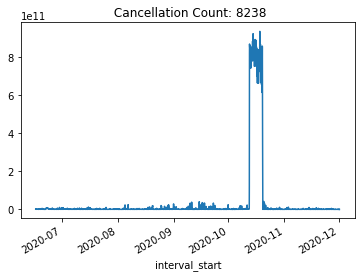

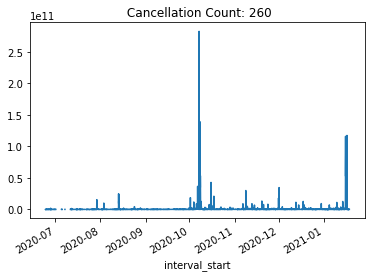

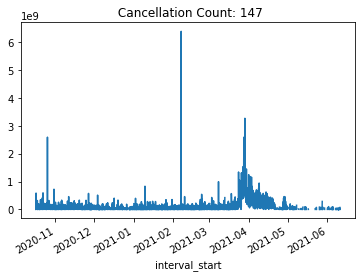

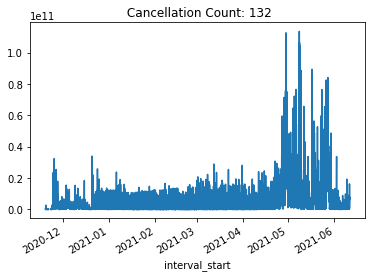

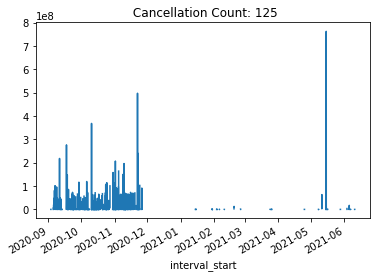

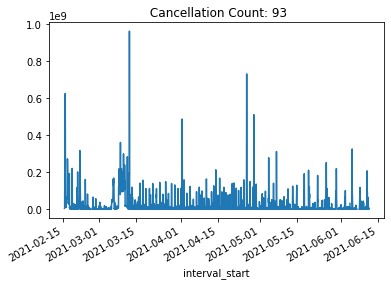

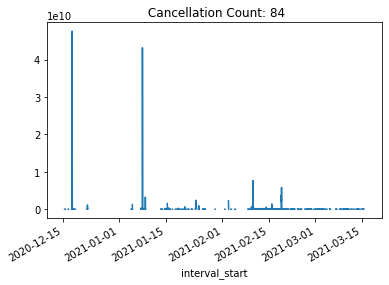

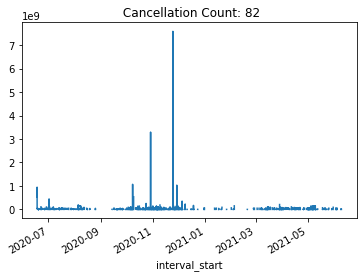

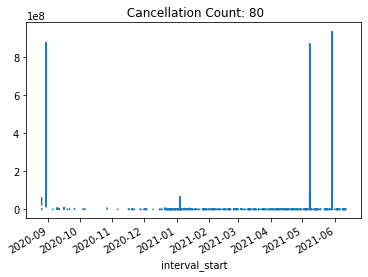

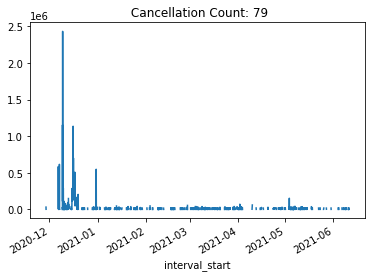

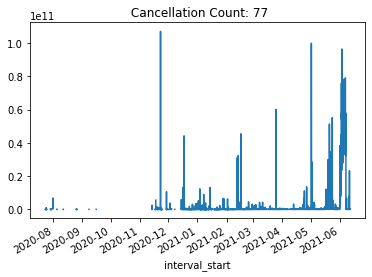

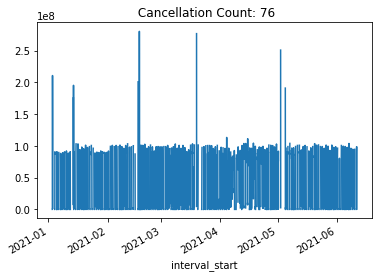

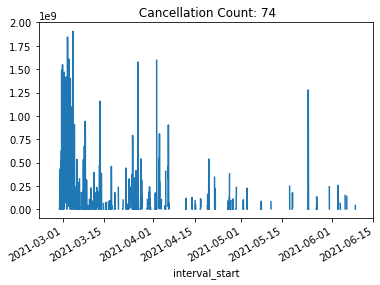

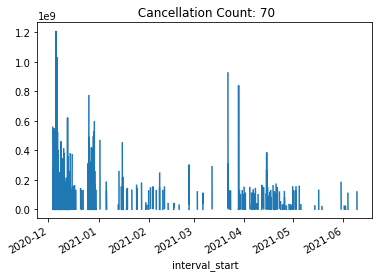

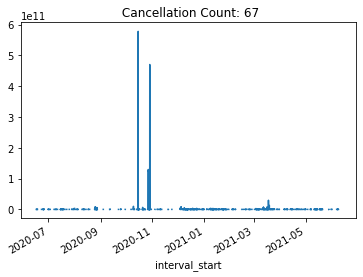

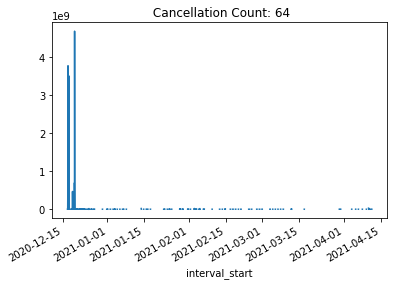

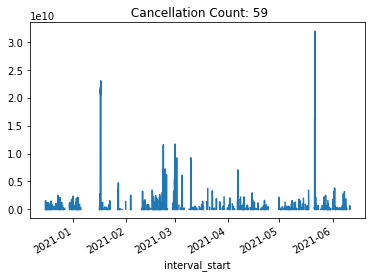

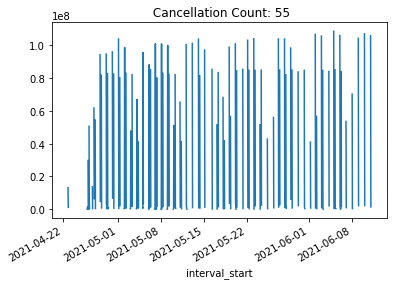

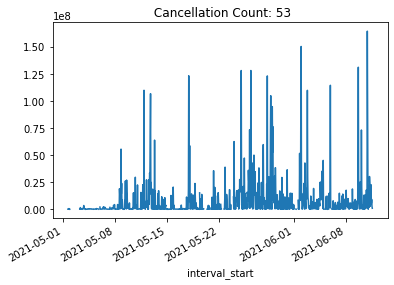

In [62]:
for i in range(len(bbr_dlsusproj1_df.columns)):
    proj_id = bbr_dlsusproj1.loc[i, 'project_id']
    cancel_count = bbr_dlsusproj1.loc[i, 'dl_cancel_count']
    plt.figure()
    bbr_dlsusproj1_df.iloc[:,i].plot(title=' Cancellation Count: ' + str(cancel_count))

#### Comparing to non-suspected projects' usage patterns

In [63]:
bbr_dlnosussum = bbr_download[~bbr_download['project_id'].isin(list(bbr_dlsuscount['project_id']))].groupby('project_id').agg({'settled':'sum'}).sort_values(by='settled', ascending=False)
bbr_dlnosussum = bbr_dlnosussum.rename({'settled': 'settled_sum'}, axis=1).reset_index()
bbr_dlnosussum

project_id      settled_sum
0     b617c07370a240ef938138ce4df3097d  109970738002432
1     ca7a0f2e08944a508baeb6f278d88f3d   11134437815552
2     36971dbb4d434790a6897bc8202fe08b    7298432770816
3     321590f2b8294783bf21d76541b30f67    1248499906560
4     4f14c095f79146ada0267da3e3748544     524110851328
...                                ...              ...
1157  4a55bdf457b64d21b44f66729813c501                0
1158  bf11357da92b42e488f9f90b83b70e3f                0
1159  4b00a32c776142118ca5312621c5238a                0
1160  4b2b2cfadd7946f1b4ac80417a704a51                0
1161  c5da7a0eaa754bfeb5908356bd01038e                0

[1162 rows x 2 columns]

In [64]:
# Zooming in first to the top 20 projects with highest total amount settled
bbr_dlnosusproj1 = bbr_dlnosussum.loc[:20,:]
bbr_dlnosusproj1

project_id      settled_sum
0   b617c07370a240ef938138ce4df3097d  109970738002432
1   ca7a0f2e08944a508baeb6f278d88f3d   11134437815552
2   36971dbb4d434790a6897bc8202fe08b    7298432770816
3   321590f2b8294783bf21d76541b30f67    1248499906560
4   4f14c095f79146ada0267da3e3748544     524110851328
5   a1e5565ed55942e5b8b11b1037e0a787     384610895360
6   cfbbd26cfa9f4a9e8ac5dcbda07b2cc3     283388525568
7   1a6d04e0ebc84c6382f03ecfe64368a3     249446252544
8   20574ac9ab424c3a8e708ea5f6a8603c     215931397888
9   48f425bd60b64c288d855a9e93ce92a6     152377132800
10  2b6aa64399d04cf5975497af8ebdf36f      89559508992
11  72fb8ed63d384ddd932630d02285026b      69925026560
12  8bbfe0f87e1d4e3c8a1cc2417dcc8f8f      61117650176
13  1217efb7b0064f97ae5f73945720c8ac      57859331584
14  f8019fe4fce9414fb2fa41f5df4f6cec      53296633856
15  96d3f5f8b69848919724af93ef453b22      48558186240
16  a60cfe92d2704ab493c1272d5973b356      47421566464
17  8b2edd391c734bc0aa63aefc2c8c18f3      47099931904
18  4aea0d3bc32f420e90b32ba75683f5f4      46174693376
19  c8c8cadc3cc94b4ea66c5bbd847e00ca      44795372032
20  f5cd2cea4f594401bfc4471e5fd86de1      43653463552

In [65]:
bbr_dlnosus1_df = bbr_download[bbr_download['project_id'].isin(list(bbr_dlnosusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlnosus1_df = bbr_dlnosus1_df[list(bbr_dlnosusproj1['project_id'])]
bbr_dlnosus1_df

project_id           b617c07370a240ef938138ce4df3097d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.802391e+11   
2021-06-11 10:00:00                      2.393457e+11   
2021-06-11 11:00:00                      2.366751e+11   
2021-06-11 12:00:00                      2.568208e+11   
2021-06-11 13:00:00                      1.737526e+10   

project_id           ca7a0f2e08944a508baeb6f278d88f3d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           36971dbb4d434790a6897bc8202fe08b  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           321590f2b8294783bf21d76541b30f67  \
interval_start                                          
2020-06-16 14:00:00                               0.0   
2020-06-16 15:00:00                               0.0   
2020-06-16 16:00:00                               0.0   
2020-06-16 17:00:00                               0.0   
2020-06-16 18:00:00                               0.0   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           4f14c095f79146ada0267da3e3748544  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a1e5565ed55942e5b8b11b1037e0a787  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


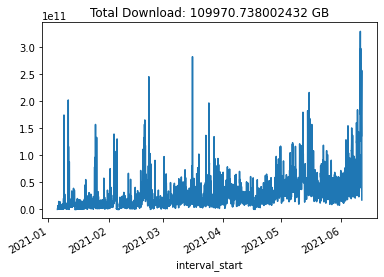

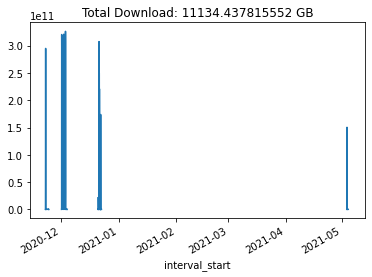

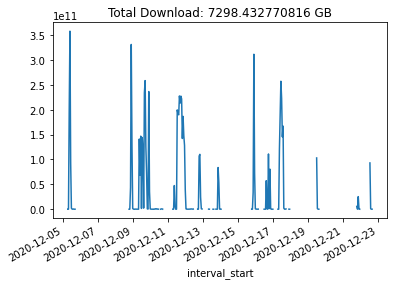

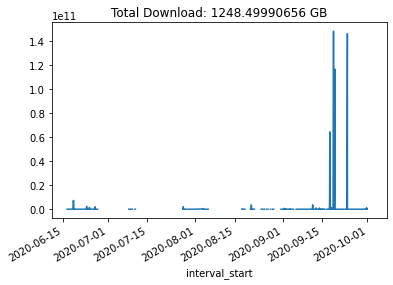

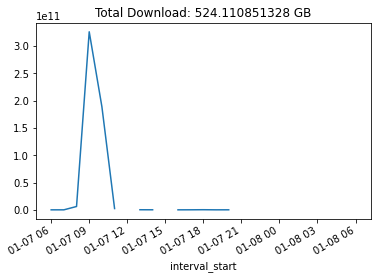

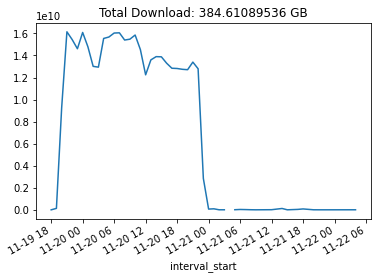

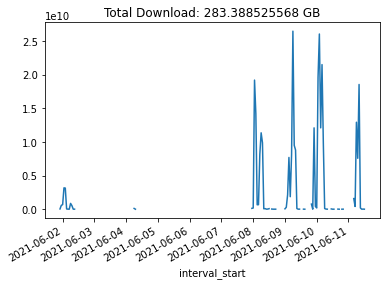

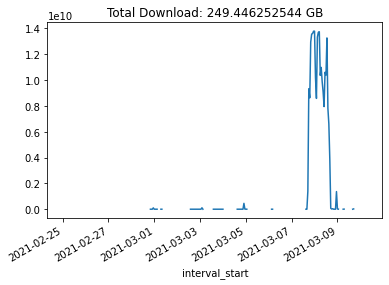

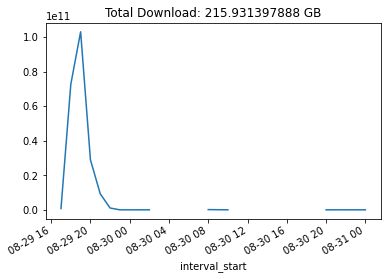

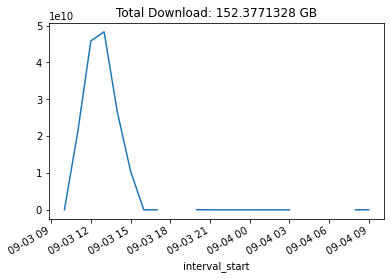

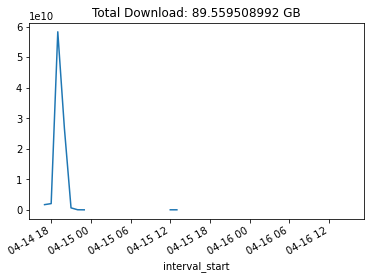

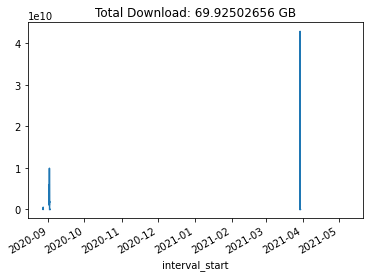

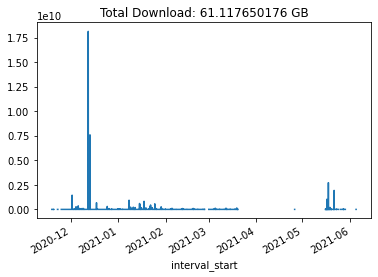

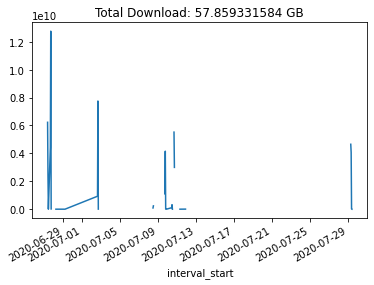

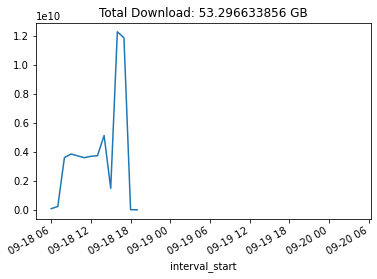

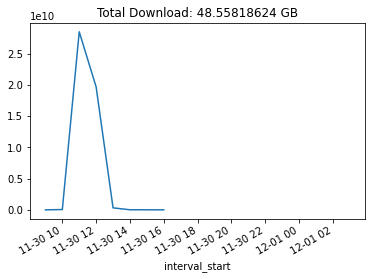

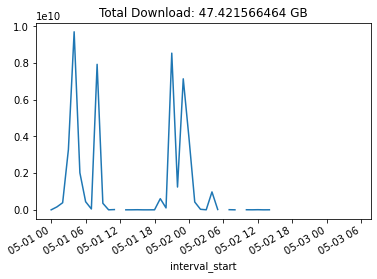

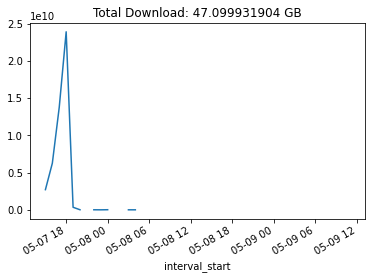

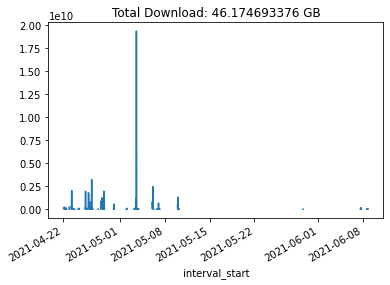

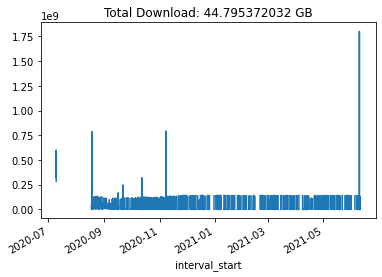

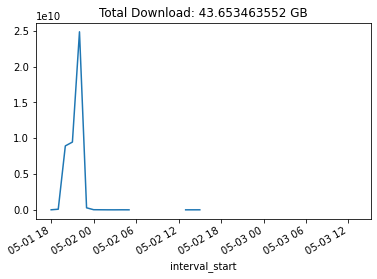

In [66]:
for i in range(len(bbr_dlnosus1_df.columns)):
    proj_id = bbr_dlnosusproj1.loc[i, 'project_id']
    settled_sum = bbr_dlnosusproj1.loc[i, 'settled_sum']/1e9
    plt.figure()
    bbr_dlnosus1_df.iloc[:,i].plot(title='Total Download: ' + str(settled_sum) + ' GB')

#### Getting suspected and non-suspected projects' DTW scores

In [224]:
bbr_dlsus_df = bbr_download[bbr_download['project_id'].isin(list(bbr_dlsuscount['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlsus_df = bbr_dlsus_df[list(bbr_dlsuscount['project_id'])]
bbr_dlsus_df

project_id           8118cf7c11224ffda2284716de755d21  \
interval_start                                          
2020-06-16 14:00:00                      1.536007e+09   
2020-06-16 15:00:00                      6.202394e+08   
2020-06-16 16:00:00                      6.954959e+08   
2020-06-16 17:00:00                      1.754264e+09   
2020-06-16 18:00:00                      2.696940e+09   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           0276add01fd94ae484e926afe29a031a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           75ba7cc203b3411d8cb5f62e9a1286b7  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.460766e+10   
2021-06-11 10:00:00                      6.232017e+09   
2021-06-11 11:00:00                      7.947056e+09   
2021-06-11 12:00:00                      7.737266e+09   
2021-06-11 13:00:00                      9.536899e+08   

project_id           50ce9633c7ab4abd9c12c9be63d6665e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           879379eb3543450ba03b7b5e7c222265  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

In [225]:
bbr_dlnosus_df = bbr_download[~bbr_download['project_id'].isin(list(bbr_dlsuscount['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlnosus_df = bbr_dlnosus_df[list(bbr_dlnosussum['project_id'])]
bbr_dlnosus_df

project_id           b617c07370a240ef938138ce4df3097d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.802391e+11   
2021-06-11 10:00:00                      2.393457e+11   
2021-06-11 11:00:00                      2.366751e+11   
2021-06-11 12:00:00                      2.568208e+11   
2021-06-11 13:00:00                      1.737526e+10   

project_id           ca7a0f2e08944a508baeb6f278d88f3d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           36971dbb4d434790a6897bc8202fe08b  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           321590f2b8294783bf21d76541b30f67  \
interval_start                                          
2020-06-16 14:00:00                               0.0   
2020-06-16 15:00:00                               0.0   
2020-06-16 16:00:00                               0.0   
2020-06-16 17:00:00                               0.0   
2020-06-16 18:00:00                               0.0   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           4f14c095f79146ada0267da3e3748544  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a1e5565ed55942e5b8b11b1037e0a787  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

In [226]:
len(bbr_download['project_id'].unique())

3141

##### US template candidate 1

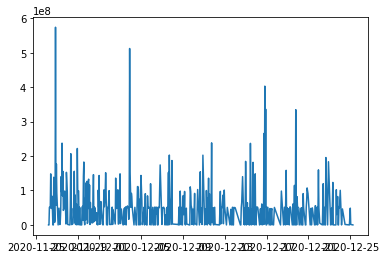

In [227]:
plt.plot(us_template1.dropna())

In [228]:
template = list(us_template1.dropna())

In [229]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.9399563169904633
1 0.5820042198673963
2 0.49003404174090104
3 0.8223186328232025
4 0.5380287209148307
5 0.532969237710617
6 0.8485281003007624
7 0.6277708159754884
8 0.4981713688610241
9 0.02767816565358172
10 0.8550858720452257
11 0.594458818977608
12 0.7993981665507304
13 0.5758697832291908
14 0.5836408718717565
15 0.11587593087259185
16 0.5364986047889256
17 0.9380704868154158
18 0.9303626142501038


<AxesSubplot:>

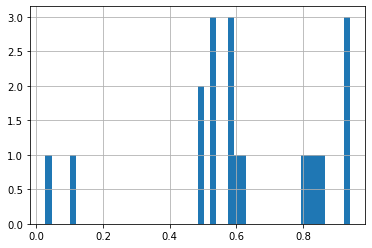

In [231]:
pd.Series(sus_scores).hist(bins=50)

<AxesSubplot:xlabel='interval_start'>

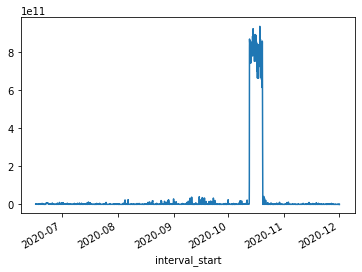

In [232]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

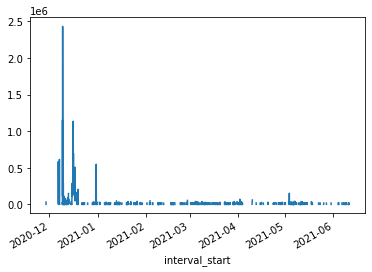

In [233]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [234]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.6710425707917681
1 0.5041012609366958
2 0.8828607733705401
3 0.5889509138873186
4 0.21187002652519893
5 0.3212123991195891
6 0.795617816091954
7 0.3003431536658855
8 0.22811671087533159
9 0.8676108374384237
10 0.23198891625615758
11 0.6340517241379311
12 0.5848787185659002
13 0.8844827586206897
14 0.5376521298174441
15 0.5118534482758621
16 0.6155285843920145
17 0.7408819628647214
18 0.9851904706430569
19 0.6759635724683832
20 0.7360547667342799


<AxesSubplot:>

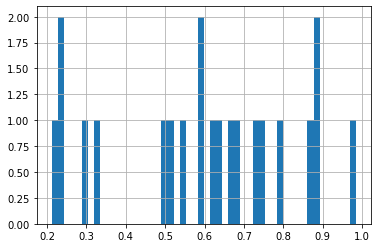

In [235]:
pd.Series(nosus_scores).hist(bins=50)

<AxesSubplot:xlabel='interval_start'>

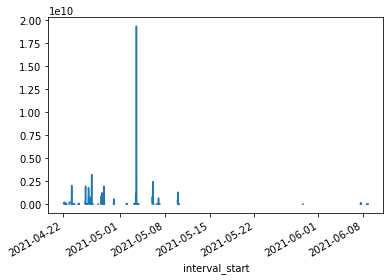

In [236]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

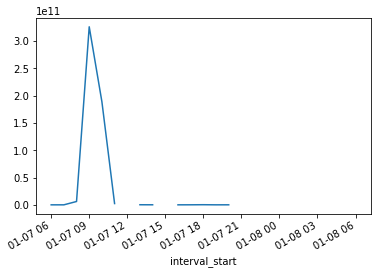

In [237]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### US template candidate 2

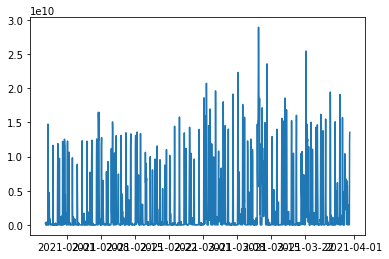

In [238]:
plt.plot(us_template2.dropna())

In [239]:
template = list(us_template2.dropna())

In [240]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6367217312934143
1 0.5836051764705883
2 0.6825504418946551
3 0.658417324473383
4 0.8349319145229661
5 0.5445460154321952
6 0.23645131845841783
7 0.5020825995068686
8 0.537455026920948
9 0.06651867992627858
10 0.7328840988450175
11 0.9832407407407407
12 0.7195189474753632
13 0.6547041497011176
14 0.4760344682285522
15 0.05150858215626675
16 0.9144849643893431
17 0.7917699923106498
18 0.6295094209558824


<AxesSubplot:>

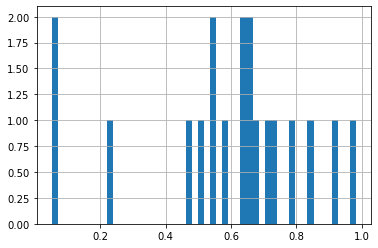

In [242]:
pd.Series(sus_scores).hist(bins=50)

<AxesSubplot:xlabel='interval_start'>

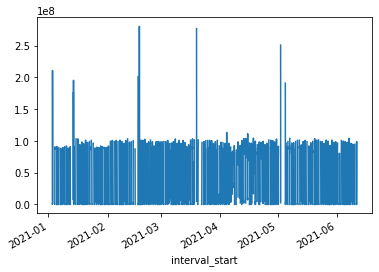

In [243]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

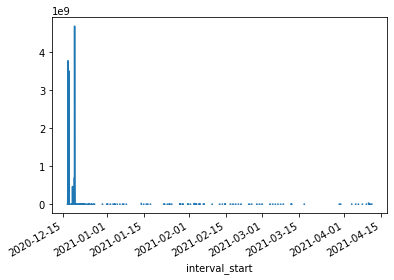

In [244]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [245]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.5319146204500077
1 0.5161600087796312
2 0.6970970758245495
3 0.8707560410056139
4 0.4360294117647059
5 0.5244367959949938
6 0.90406162464986
7 0.7670188463735008
8 0.4902714932126697
9 0.48792016806722693
10 0.3375
11 0.4654166666666667
12 0.22598176333470454
13 0.46296568627450985
14 0.5397058823529413
15 0.47830882352941173
16 0.6832236842105264
17 0.7846153846153846
18 0.965923092209857
19 0.6384031491384432
20 0.26461937716262973


<AxesSubplot:>

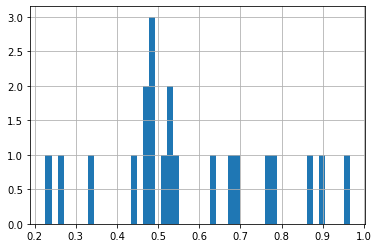

In [249]:
pd.Series(nosus_scores).hist(bins=50)

<AxesSubplot:xlabel='interval_start'>

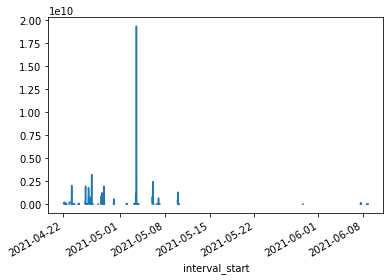

In [250]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

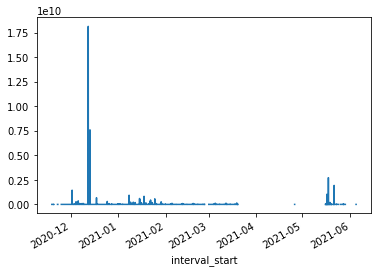

In [251]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### EU template candidate 1

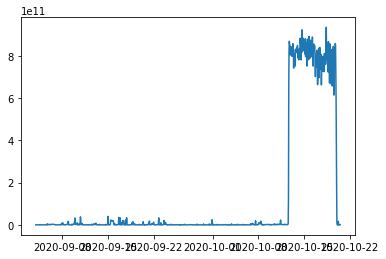

In [252]:
plt.plot(eu_template1.dropna())

In [253]:
template = list(eu_template1.dropna())

In [254]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6708015135532954
1 0.3894306669756117
2 0.33420043803116983
3 0.7432382749553583
4 0.8732183138414199
5 0.5513920790537916
6 0.05304613108995104
7 0.4273504273504274
8 0.5923948881129325
9 0.7186322289410163
10 0.02703598460619805
11 0.8022346104562369
12 0.7488937353083265
13 0.7326141976649149
14 0.21204386755534632
15 0.10263587495348381
16 0.9076303907000183
17 0.9934582114049075
18 0.8807309619558279


<AxesSubplot:>

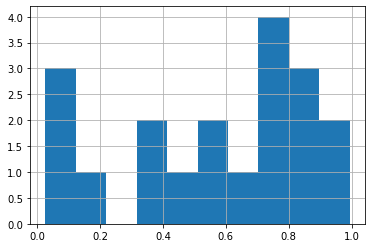

In [255]:
pd.Series(sus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

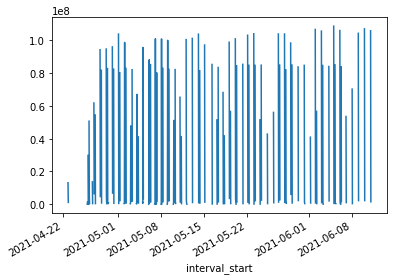

In [256]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

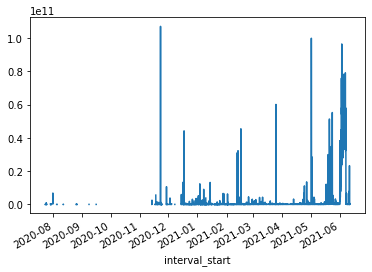

In [257]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [258]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.8028879552445652
1 0.17047470422685496
2 0.02642739440148356
3 0.8091879605011885
4 0.13177974840173234
5 0.07461068963550277
6 0.7490425124473381
7 0.9856234328500655
8 0.05987488829311882
9 0.08598238222903098
10 0.059555725775564894
11 0.314834673815907
12 0.1497725232728011
13 0.15624069109323802
14 0.3973610892078011
15 0.2998212689901698
16 0.13244908517943654
17 0.08290369148277998
18 0.9999154650629182
19 0.906568815952194
20 0.18167481469799718


<AxesSubplot:>

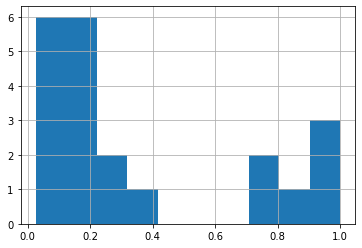

In [259]:
pd.Series(nosus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

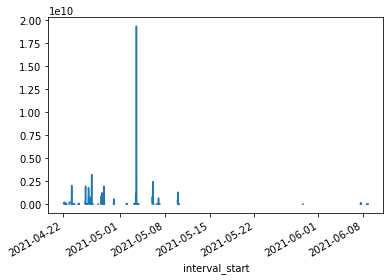

In [260]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

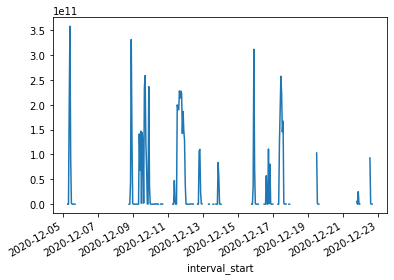

In [261]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### AP template candidate 1

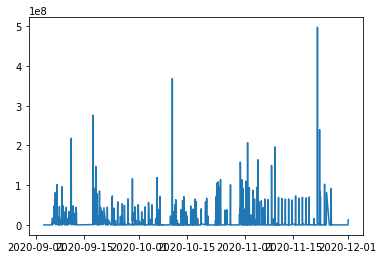

In [262]:
plt.plot(ap_template1.dropna())

In [264]:
template = list(ap_template1.dropna())

In [265]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.08128661087866107
1 0.5475812170741592
2 0.4863734089076739
3 0.27782100851257396
4 0.7685140012692369
5 0.5433707660685994
6 0.8505485893416928
7 0.6368007399577167
8 0.3392287405639074
9 0.09299939002349544
10 0.8163855577047067
11 0.9969363186318632
12 0.9764091694143507
13 0.8689048065336725
14 0.5293746026700572
15 0.05520689416966018
16 0.4862105183235472
17 0.8256238859180036
18 0.9910984848484848


<AxesSubplot:>

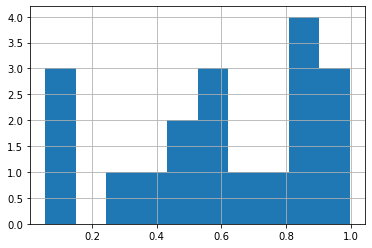

In [266]:
pd.Series(sus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

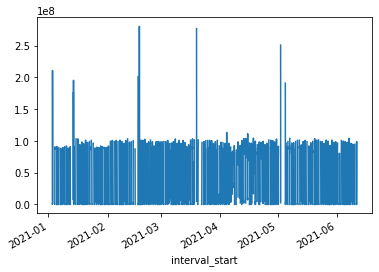

In [267]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

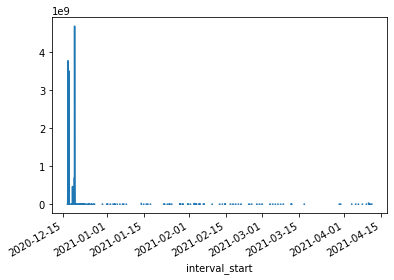

In [268]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [269]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.051560952289236184
1 0.8344046811397557
2 0.8524369416710458
3 0.5121833795975017
4 0.07972027972027973
5 0.08365570599613148
6 0.9951569264069264
7 0.8083517210944395
8 0.6200174825174825
9 0.07280844155844157
10 0.8570616883116883
11 0.6181818181818182
12 0.5435598913664952
13 0.8845454545454545
14 0.07172459893048133
15 0.08508522727272727
16 0.4001794258373206
17 0.2488636363636364
18 0.7359643734643735
19 0.8567283057851239
20 0.5877005347593582


<AxesSubplot:>

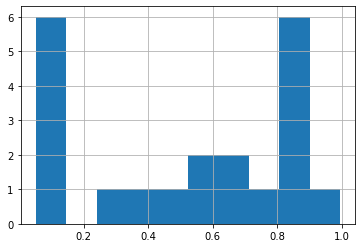

In [270]:
pd.Series(nosus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

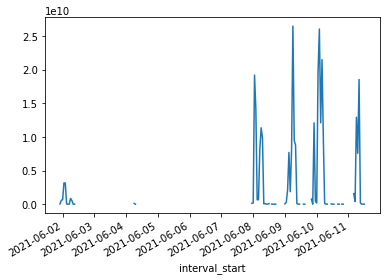

In [271]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

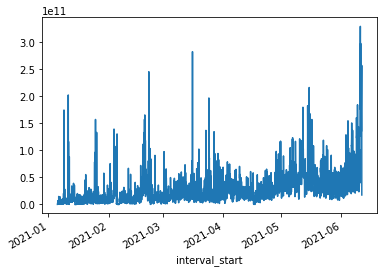

In [272]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### AP template candidate 2

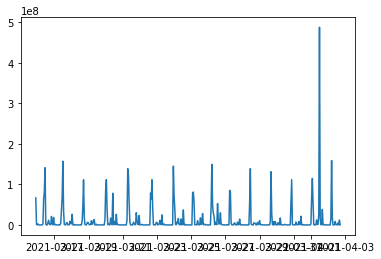

In [273]:
plt.plot(ap_template2.dropna())

In [274]:
template = list(ap_template2.dropna())

In [275]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.07852754344470125
1 0.6557964224132892
2 0.4201567806216082
3 0.45846271492459667
4 0.5757494701111399
5 0.37312012358315527
6 0.49047864003342434
7 0.3196756502162622
8 0.34034602258094704
9 0.08283131760083695
10 0.7616920572273962
11 0.672985741560017
12 0.7637288802488854
13 0.3314810749622451
14 0.48070402201676143
15 0.02471832446256994
16 0.46980250381952804
17 0.8811410327131706
18 0.7193144830784004


<AxesSubplot:>

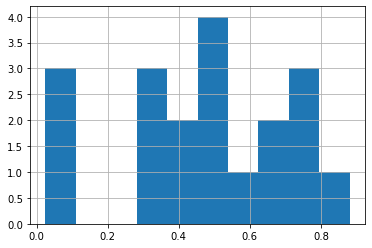

In [276]:
pd.Series(sus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

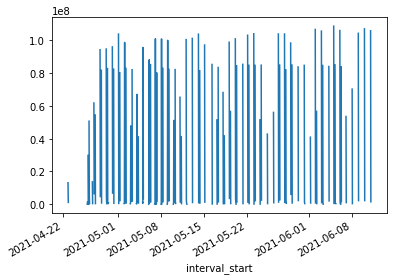

In [277]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

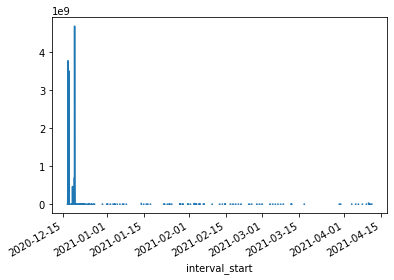

In [278]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [279]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.06522585999559627
1 0.27319922128487995
2 0.3147849740549651
3 0.4812826661031304
4 0.10072791658469404
5 0.11465418729934151
6 0.7950615028620144
7 0.755667568842649
8 0.6690930552823136
9 0.10741687979539638
10 0.85988308366825
11 0.21432225063938615
12 0.5452764205461444
13 0.7828644501278772
14 0.2088160072213029
15 0.11636828644501274
16 0.6802396015614484
17 0.2467047019476687
18 0.9954724545517384
19 0.6121207341392791
20 0.40439295922972773


<AxesSubplot:>

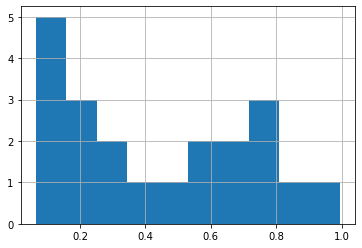

In [280]:
pd.Series(nosus_scores).hist()

<AxesSubplot:xlabel='interval_start'>

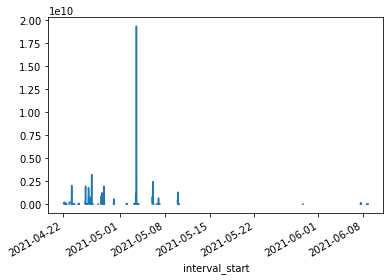

In [281]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

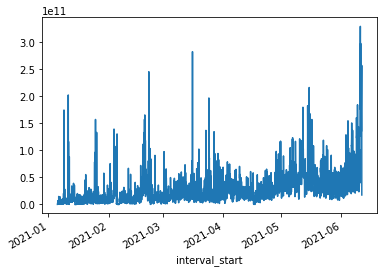

In [282]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

##### bbr template candidate 1

<AxesSubplot:xlabel='interval_start'>

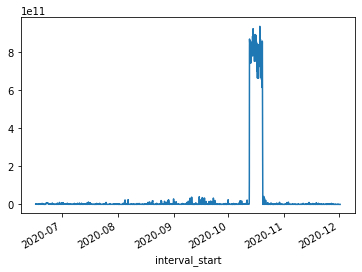

In [283]:
bbr_dlsus_df.iloc[:,0].dropna().plot()

In [284]:
template = list(bbr_dlsus_df.iloc[:,0].dropna())

In [285]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 1.0
1 0.6066553162315031
2 0.815976594966588
3 0.886298082213826
4 0.24460473472190714
5 0.2647903393490256
6 0.2460758192332405
7 0.4853654756780026
8 0.008282200551582353
9 0.03519136104739573
10 0.7712728611374371
11 0.5484236747839233
12 0.3925997918879198
13 0.2135471418509134
14 0.437550486068902
15 0.08466046177953146
16 0.9943937832493106
17 0.6452165793853774
18 0.09027728482697428


<AxesSubplot:>

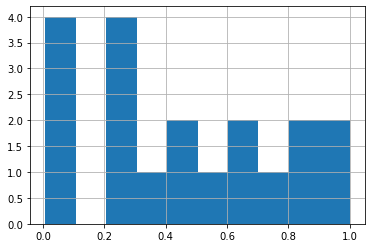

In [286]:
pd.Series(sus_scores).hist()

In [287]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.9900153952327866
1 0.5732455733753592
2 0.4080723799949736
3 0.9862250972913069
4 0.45133301481127563
5 0.45857010704374257
6 0.8166104702750665
7 0.809260085629862
8 0.37999044433827045
9 0.4530257320319432
10 0.17914818101153507
11 0.5273788819875777
12 0.3470592865387786
13 0.4405548654244307
14 0.5189915966386555
15 0.4528260869565217
16 0.7363582870219025
17 0.1795699952221691
18 0.7858704045660567
19 0.7531621808143547
20 0.2552868103763244


<AxesSubplot:>

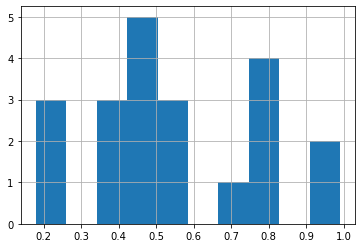

In [288]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 2

<AxesSubplot:xlabel='interval_start'>

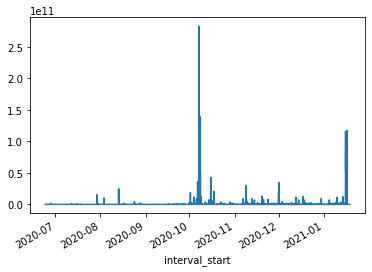

In [289]:
bbr_dlsus_df.iloc[:,1].dropna().plot()

In [290]:
template = list(bbr_dlsus_df.iloc[:,1].dropna())

In [291]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6788663481346997
1 1.0
2 0.810722407421576
3 0.7664713956984643
4 0.9996129164488456
5 0.6615534009453237
6 0.02700947029770262
7 0.4866410793510363
8 0.9898985778440454
9 0.032787171280418304
10 0.8890102178154741
11 0.8205516272796167
12 0.6557188863848359
13 0.3942804503027758
14 0.3766444207215234
15 0.0815692038551099
16 0.7004943931456722
17 0.9236728418919035
18 0.80290794537263


<AxesSubplot:>

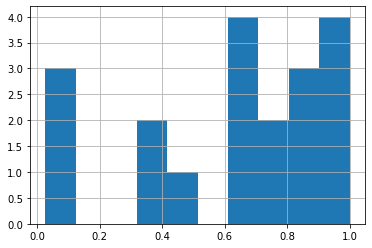

In [292]:
pd.Series(sus_scores).hist()

In [293]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.8741245212664398
1 0.7914252652636946
2 0.8054962667011006
3 0.9594961314278548
4 0.7424037198018801
5 0.4303575921939218
6 0.8434828859270384
7 0.6785476442595971
8 0.4724957040331548
9 0.009761591890369847
10 0.7665477754833865
11 0.6433727551467368
12 0.6816894398381264
13 0.8402890932982917
14 0.3839066244106052
15 0.018856767411300934
16 0.39775918113285846
17 0.7374507227332457
18 0.7364065774052633
19 0.8292085108642271
20 0.010605240782252445


<AxesSubplot:>

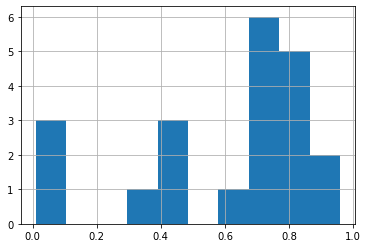

In [294]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 3

<AxesSubplot:xlabel='interval_start'>

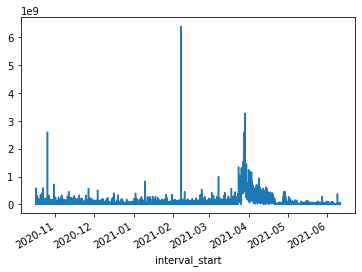

In [295]:
bbr_dlsus_df.iloc[:,2].dropna().plot()

In [296]:
template = list(bbr_dlsus_df.iloc[:,2].dropna())

In [297]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.8426463418821025
1 0.8800795573438484
2 1.0
3 0.7198464897592234
4 0.9913237976006698
5 0.8313187792596527
6 0.6715716546917601
7 0.8151964295203853
8 0.1563663412960935
9 0.041833657259349843
10 0.4312557638287188
11 0.8871572640378216
12 0.7292072659231061
13 0.5922110034300552
14 0.5085448230438794
15 0.16369947018522701
16 0.7333918523811218
17 0.8545975467812696
18 0.5117073505682013


<AxesSubplot:>

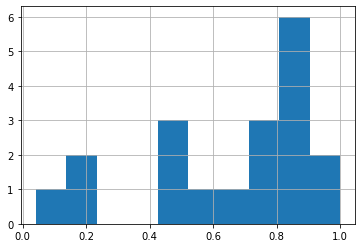

In [298]:
pd.Series(sus_scores).hist()

In [299]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.6631081732694927
1 0.7036698267853236
2 0.938123477987867
3 0.48917108179987856
4 0.6321335477788254
5 0.7551325121313923
6 0.6676279740447009
7 0.692484302923821
8 0.6418760283215943
9 0.7195900710680811
10 0.2763587049816322
11 0.288215973724265
12 0.5224800879638787
13 0.7662741328206361
14 0.20932468156693107
15 0.5027637587118481
16 0.5892118544378249
17 0.7342724566949512
18 0.38061601616035645
19 0.11124559704228054
20 0.24427103213311285


<AxesSubplot:>

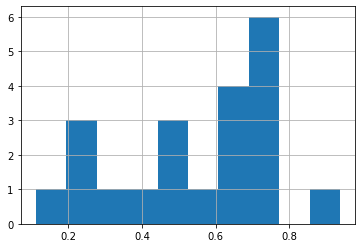

In [300]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 4

<AxesSubplot:xlabel='interval_start'>

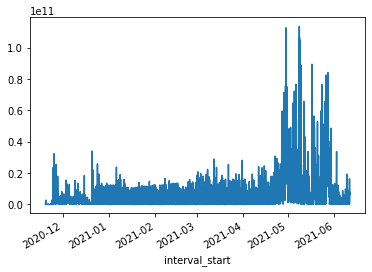

In [301]:
bbr_dlsus_df.iloc[:,3].dropna().plot()

In [302]:
template = list(bbr_dlsus_df.iloc[:,3].dropna())

In [303]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.7393096039552238
1 0.5451438566044644
2 0.5884377132887788
3 1.0
4 0.599257953697043
5 0.3029813883157163
6 0.15886222513069537
7 0.6657038272298224
8 0.6351338663439475
9 0.05025933982808917
10 0.833447017669434
11 0.7978155918634676
12 0.29940968175555704
13 0.7299374976774824
14 0.43705790849988246
15 0.12637546679182188
16 0.6036252886301868
17 0.8366323166460172
18 0.21472545172371305


<AxesSubplot:>

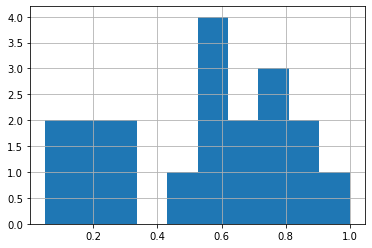

In [304]:
pd.Series(sus_scores).hist()

In [305]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.4614960098907155
1 0.37794797846008255
2 0.5391030427536241
3 0.7909767815612648
4 0.16205769645493606
5 0.17252533965926242
6 0.7030741345492262
7 0.9135426110370155
8 0.18309251671339233
9 0.22366677962968673
10 0.11554576542715422
11 0.28816763712170224
12 0.26317167988915624
13 0.27302135001078287
14 0.4772989635793934
15 0.40556933362087555
16 0.6455512298105626
17 0.08233108276239609
18 0.996128379835518
19 0.7425856581776358
20 0.1969199152596126


<AxesSubplot:>

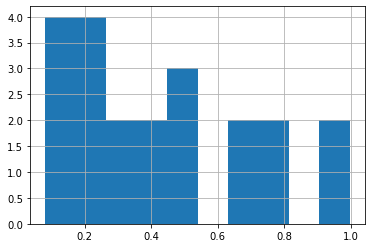

In [306]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 5

<AxesSubplot:xlabel='interval_start'>

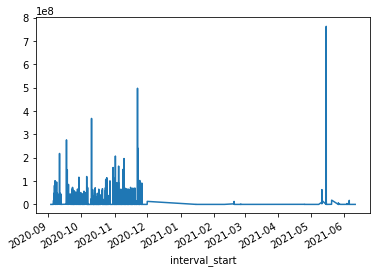

In [307]:
bbr_dlsus_df.iloc[:,4].dropna().plot()

In [308]:
template = list(bbr_dlsus_df.iloc[:,4].dropna())

In [309]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.13990820765321532
1 0.5770005840400397
2 0.5742509775436766
3 0.3363707942492663
4 1.0
5 0.6092329020088714
6 0.7418905946829152
7 0.7419535135944668
8 0.4672501429277861
9 0.22333454343140036
10 0.5896758362196463
11 0.8195751526452415
12 0.9772474242447492
13 0.5679669451766214
14 0.6038626087005754
15 0.08497736117403842
16 0.6297257718214029
17 0.9468671970268858
18 0.8590433736426456


<AxesSubplot:>

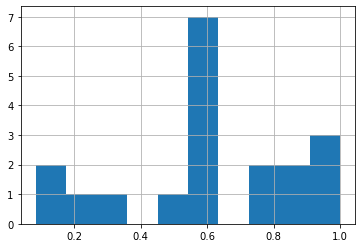

In [310]:
pd.Series(sus_scores).hist()

In [311]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.05632049762355784
1 0.3854223453315849
2 0.5833813602360071
3 0.7028443512347777
4 0.0674310881615916
5 0.09279368213228034
6 0.7385418135664927
7 0.6228543497637509
8 0.6226744627534361
9 0.07403751233958544
10 0.8570723452263432
11 0.33698585060875286
12 0.6413993542221553
13 0.8066469233300428
14 0.06230764763950991
15 0.09143632773938792
16 0.5304982594690082
17 0.2365403599362138
18 0.7292628264987594
19 0.9182615892388843
20 0.5105394576389293


<AxesSubplot:>

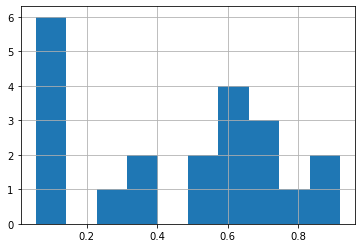

In [312]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 6

<AxesSubplot:xlabel='interval_start'>

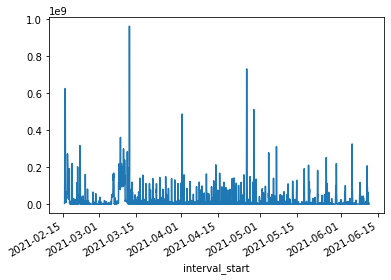

In [313]:
bbr_dlsus_df.iloc[:,5].dropna().plot()

In [314]:
template = list(bbr_dlsus_df.iloc[:,5].dropna())

In [315]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.7271334273518915
1 0.9909274203679328
2 0.844398667047598
3 0.8274362535568435
4 0.9776664577811894
5 1.0
6 0.8757759629744238
7 0.9205345427246587
8 0.45765286969556995
9 0.1556197380641311
10 0.7272397225832261
11 0.8398247754470931
12 0.8219979150620259
13 0.8844086314994681
14 0.8527671299353569
15 0.3270868935648408
16 0.7496636333892632
17 0.8974815052825657
18 0.7694038793824202


<AxesSubplot:>

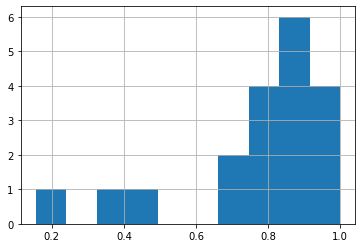

In [316]:
pd.Series(sus_scores).hist()

In [317]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.7849708166389721
1 0.7727825950233227
2 0.8740750430199437
3 0.7542096836079348
4 0.010594555658933302
5 0.6337071749362864
6 0.666299723166676
7 0.49896018394705843
8 0.12368318376902065
9 0.8619642160414692
10 0.86126748787693
11 0.32125113798933547
12 0.8662513218876536
13 0.29339315905839514
14 0.0859975671891855
15 0.6005657432696059
16 0.5482678604431485
17 0.314865392118611
18 0.8961125581297256
19 0.8075463964656318
20 0.9978655527759289


<AxesSubplot:>

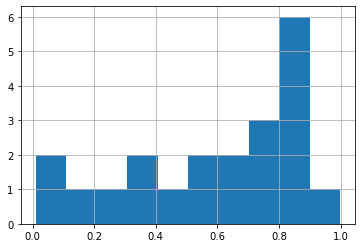

In [318]:
pd.Series(nosus_scores).hist()

##### bbr template candidate 7 (the final template that we use)

Text(0, 0.5, 'settled')

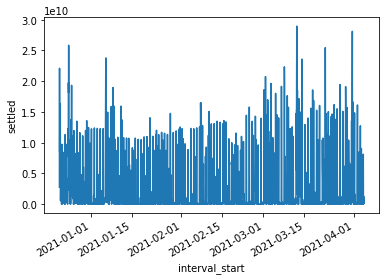

In [72]:
bbr_dlsus_df.iloc[4500:7000,3].dropna().plot()
plt.ylabel('settled')

In [347]:
template = list(bbr_dlsus_df.iloc[4500:7000,3].dropna())

In [348]:
sus_scores = list()
for i in range(len(bbr_dlsusproj1_df.columns)):
    alignment = dtw(list(bbr_dlsusproj1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_scores.append(prob)
    print(i, prob)

0 0.6400136928288251
1 0.8103279334052367
2 0.6133930117090739
3 0.5922442501046248
4 0.8044045713155575
5 0.8697945285465799
6 0.2427050205467215
7 0.6249331668918188
8 0.5015412336033762
9 0.05126762649390737
10 0.6116562313682854
11 0.9346784731931537
12 0.6847633493516605
13 0.650227272149178
14 0.9071417784991594
15 0.12103327716270063
16 0.846923397641932
17 0.9873528282930905
18 0.5847390243338269


<AxesSubplot:xlabel='interval_start'>

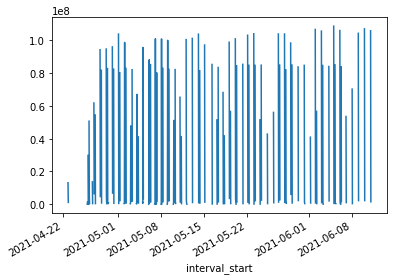

In [349]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == max(sus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

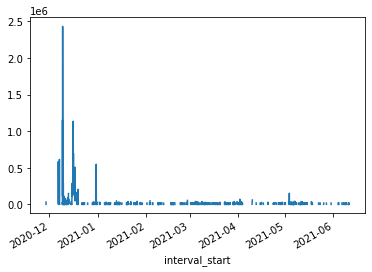

In [350]:
bbr_dlsusproj1_df.iloc[:,np.where(sus_scores == min(sus_scores))[0][0]].plot()

In [351]:
nosus_scores = list()
for i in range(len(bbr_dlnosus1_df.columns)):
    alignment = dtw(list(bbr_dlnosus1_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_scores.append(prob)
    print(i, prob)

0 0.410942506949203
1 0.9737001520892945
2 0.755994988369423
3 0.8352042260586646
4 0.8313737212700943
5 0.39043839341491204
6 0.6770550620939222
7 0.1543169508861948
8 0.540022585359373
9 0.34539230199851967
10 0.5739575622995312
11 0.771531375935521
12 0.3281003125799711
13 0.6692141623488774
14 0.4392715635476989
15 0.41947322970639034
16 0.6565766748477411
17 0.9721668659492494
18 0.9425909069691453
19 0.8515958374766665
20 0.22744590064004877


<AxesSubplot:xlabel='interval_start'>

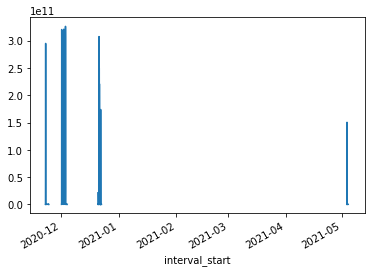

In [352]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == max(nosus_scores))[0][0]].plot()

<AxesSubplot:xlabel='interval_start'>

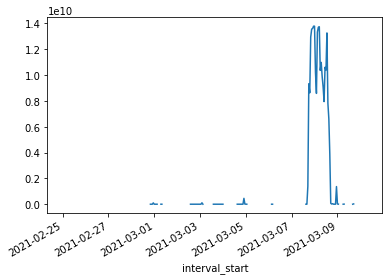

In [353]:
bbr_dlnosus1_df.iloc[:,np.where(nosus_scores == min(nosus_scores))[0][0]].plot()

Text(0, 0.5, 'settled')

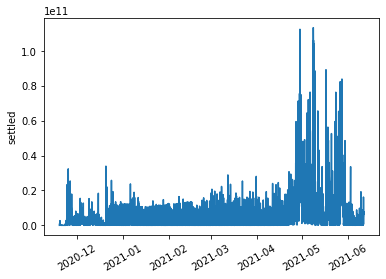

In [93]:
plt.plot(bbr_dlsus_df.iloc[:,3].dropna())
plt.xticks(rotation=30)
plt.ylabel('settled')

Text(0, 0.5, 'reference')

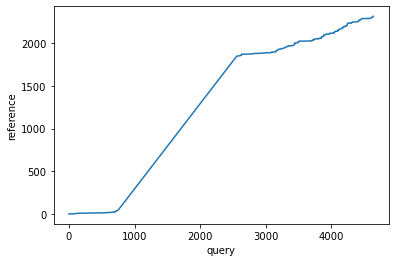

In [95]:
alignment = dtw(bbr_dlsus_df.iloc[:,3].dropna(), template)
y = alignment.index2
x = alignment.index1
plt.plot(x,y)
plt.xlabel('query')
plt.ylabel('reference')

Text(0, 0.5, 'settled')

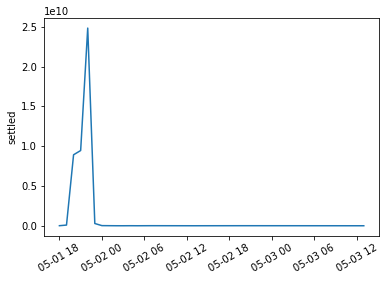

In [96]:
plt.plot(bbr_dlnosus_df.iloc[:,20].dropna())
plt.xticks(rotation=30)
plt.ylabel('settled')

Text(0, 0.5, 'reference')

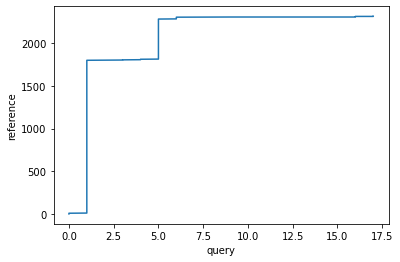

In [97]:
alignment = dtw(list(bbr_dlnosus_df.iloc[:,20].dropna()), template)
y = alignment.index2
x = alignment.index1
plt.plot(x,y)
plt.xlabel('query')
plt.ylabel('reference')

#### All Regions Results (Using Template Candidate 7)

Using template candidate 7.

In [4]:
# Collating bbr data
# ap_bbr = pd.read_csv('bucket_data/ap_bbr.csv')
# eu_bbr = pd.read_csv('bucket_data/eu_bbr.csv')
# us_bbr = pd.read_csv('bucket_data/us_bbr.csv')

# ap_bbr['project_id'] = ap_bbr['project_id'].astype(str).str.lower()
# eu_bbr['project_id'] = eu_bbr['project_id'].astype(str).str.lower()
# us_bbr['project_id'] = us_bbr['project_id'].astype(str).str.lower()

# ap_bbr['interval_start'] = pd.to_datetime(ap_bbr['interval_start'])
# eu_bbr['interval_start'] = pd.to_datetime(eu_bbr['interval_start'])
# us_bbr['interval_start'] = pd.to_datetime(us_bbr['interval_start'])

bbr = ap_bbr.append(eu_bbr).append(us_bbr).reset_index(drop=True)
bbr

Unnamed: 0      interval_start  action  inline   settled  \
0                 0 2021-06-04 14:00:00       1     126         0   
1                 1 2021-04-20 17:00:00       1       0  11766784   
2                 2 2021-04-20 17:00:00       2       0   8471040   
3                 3 2021-04-20 18:00:00       1       0    562432   
4                 4 2021-04-20 18:00:00       2       0    361216   
...             ...                 ...     ...     ...       ...   
1044495      237936 2021-03-10 13:00:00       2    2451         0   
1044496      237937 2021-03-10 15:00:00       2       0  75193856   
1044497      237938 2021-03-10 16:00:00       2       0   2381824   
1044498      237939 2021-02-12 22:00:00       2       0         0   
1044499      237940 2021-02-13 00:00:00       2       0   1345024   

                               project_id  
0        25f0aeda906b46ceb0a63f79037840c0  
1        a965308845f94c34a312cd34d0e30bc5  
2        a965308845f94c34a312cd34d0e30bc5  
3        a965308845f94c34a312cd34d0e30bc5  
4        a965308845f94c34a312cd34d0e30bc5  
...                                   ...  
1044495  99b54f4665b441269c87660036f8e42e  
1044496  99b54f4665b441269c87660036f8e42e  
1044497  99b54f4665b441269c87660036f8e42e  
1044498  d346180ab62e4142aeb0d34a31fdd382  
1044499  d346180ab62e4142aeb0d34a31fdd382  

[1044500 rows x 6 columns]

In [5]:
len(bbr) - len(bbr.drop_duplicates())

0

In [6]:
len(bbr.drop_duplicates().groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index())

629266

Within each region's file, we want to sum the inline and settled amounts of duplicate rows with the same project_id, interval_start and action EXCEPT when inline==0 and settled==0 (since these indicate multiple cancellations within an hour). For rows that are not cancellations, we can remove duplicates.

In [7]:
cancellation_mask = (bbr['inline']==0) & (bbr['settled']==0)
bbr = bbr[cancellation_mask].append(bbr[~cancellation_mask].drop_duplicates().groupby(['interval_start','action','project_id']).aggregate({'inline': sum, 'settled': sum}).reset_index()).reset_index(drop=True)
bbr

Unnamed: 0      interval_start  action  inline  settled  \
0             41.0 2021-04-20 04:00:00       1       0        0   
1             42.0 2021-04-20 04:00:00       2       0        0   
2             43.0 2021-04-20 05:00:00       1       0        0   
3             44.0 2021-04-20 05:00:00       2       0        0   
4             56.0 2021-04-20 11:00:00       2       0        0   
...            ...                 ...     ...     ...      ...   
659183         NaN 2021-06-11 13:00:00       2       0    67072   
659184         NaN 2021-06-11 13:00:00       2     176        0   
659185         NaN 2021-06-11 13:00:00       2    4739        0   
659186         NaN 2021-06-11 13:00:00       2       0   195584   
659187         NaN 2021-06-11 13:00:00       2     649   484864   

                              project_id  
0       6b2d0a6d00c44b5abd88758afc2e4798  
1       6b2d0a6d00c44b5abd88758afc2e4798  
2       6b2d0a6d00c44b5abd88758afc2e4798  
3       6b2d0a6d00c44b5abd88758afc2e4798  
4       6b2d0a6d00c44b5abd88758afc2e4798  
...                                  ...  
659183  e2bc94727cc4497d8a3a7d93a4f068ad  
659184  eddb79195f3241c884df12ea93b44529  
659185  f6c05c9255a14ecabb3473d4c97e3705  
659186  f7877e7be74d4e9a8f2c7b90d0935cf5  
659187  f82708edb49e40f9956d0bd72ba0cdbf  

[659188 rows x 6 columns]

In [8]:
bbr['month'] = bbr['interval_start'].dt.to_period('M')
bbr_dlsuscount = bbr[(bbr['inline']==0) & (bbr['settled']==0) & (bbr['action']==2)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
bbr_dlsuscount = bbr_dlsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'dl_cancel_count'}, axis=1).reset_index(drop=True)
bbr_dlsuscount

project_id  dl_cancel_count
0     8118cf7c11224ffda2284716de755d21             8238
1     a56224e6a3f943baa6791431d2711271              260
2     0276add01fd94ae484e926afe29a031a              147
3     75ba7cc203b3411d8cb5f62e9a1286b7              132
4     50ce9633c7ab4abd9c12c9be63d6665e              125
...                                ...              ...
1974  69dc0cb12002472d905a7647981757e8                1
1975  69d85e47154f4733a08c9a885319fd80                1
1976  69bd1fd778f4431bb59b2b5ecec372b8                1
1977  69a353f2ac9e4c3eb81e38f7cb9a10e5                1
1978  fff103d31b114502a51ef83a52293e84                1

[1979 rows x 2 columns]

In [9]:
bbr_dlsuscount['dl_cancel_count'].value_counts()

1       1203
2        300
3        153
4         71
5         44
6         24
7         19
9         14
10        14
8         12
12        10
14        10
16         9
17         7
15         7
11         7
13         6
32         5
18         4
21         4
26         4
25         3
28         3
29         3
30         2
45         2
41         2
39         2
46         2
24         2
23         2
67         1
260        1
147        1
132        1
125        1
93         1
84         1
82         1
80         1
79         1
77         1
76         1
74         1
70         1
64         1
59         1
55         1
53         1
48         1
8238       1
19         1
44         1
42         1
20         1
22         1
38         1
36         1
35         1
33         1
Name: dl_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [10]:
# Narrowing down bbr for future plotting purpose
bbr_download = bbr[bbr['action']==2][['project_id', 'interval_start', 'settled']]
bbr_download = bbr_download.groupby(['interval_start','project_id']).aggregate({'settled': sum}).reset_index()
bbr_download

interval_start                        project_id       settled
0      2020-06-16 14:00:00  0de105efbc5d4944b567aa6ea90db9f9     422522112
1      2020-06-16 14:00:00  2e1e9468e497490d89544666a1760e3a  192471493376
2      2020-06-16 14:00:00  300af053503a42cfa6c1a90246c09d59  245334294016
3      2020-06-16 14:00:00  321590f2b8294783bf21d76541b30f67             0
4      2020-06-16 14:00:00  40d0af33125649d5adbf343920fa3751   12405925888
...                    ...                               ...           ...
220336 2021-06-11 13:00:00  e2bc94727cc4497d8a3a7d93a4f068ad         67072
220337 2021-06-11 13:00:00  eddb79195f3241c884df12ea93b44529             0
220338 2021-06-11 13:00:00  f6c05c9255a14ecabb3473d4c97e3705             0
220339 2021-06-11 13:00:00  f7877e7be74d4e9a8f2c7b90d0935cf5        195584
220340 2021-06-11 13:00:00  f82708edb49e40f9956d0bd72ba0cdbf        484864

[220341 rows x 3 columns]

In [11]:
# Focusing first on projects with more than 50 times download cancellations
bbr_dlsusproj1 = bbr_dlsuscount[bbr_dlsuscount['dl_cancel_count']>50]
bbr_dlsusproj1

project_id  dl_cancel_count
0   8118cf7c11224ffda2284716de755d21             8238
1   a56224e6a3f943baa6791431d2711271              260
2   0276add01fd94ae484e926afe29a031a              147
3   75ba7cc203b3411d8cb5f62e9a1286b7              132
4   50ce9633c7ab4abd9c12c9be63d6665e              125
5   879379eb3543450ba03b7b5e7c222265               93
6   91c84be747f34cccb0363d4fd8242e3d               84
7   c633be39a19f4e259068364f684f2614               82
8   5d91665c1ab0418089bdf29488c70c5b               80
9   276d649ffb4149c18c48d0b7de487aec               79
10  0fc6c670c8c349b8a917b3f5b1ac5e68               77
11  db34f21f987044eaaadb13f516b79f5c               76
12  d041a5c274e1471fa603e00b2143414e               74
13  fee8c911af2e4c5c841ee158eebb8663               70
14  d346180ab62e4142aeb0d34a31fdd382               67
15  55a57b57962a4ad58d71c86408f972af               64
16  9f28c45fa04249da955042dc28d7f2a8               59
17  6a0c2e967df34f0298b61814949c3fc4               55
18  a63cf958e0614ed8859a64991aa1fa5f               53

In [12]:
bbr_dlsusproj1_df = bbr_download[bbr_download['project_id'].isin(list(bbr_dlsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlsusproj1_df = bbr_dlsusproj1_df[list(bbr_dlsusproj1['project_id'])]
bbr_dlsusproj1_df

project_id           8118cf7c11224ffda2284716de755d21  \
interval_start                                          
2020-06-16 14:00:00                      1.536007e+09   
2020-06-16 15:00:00                      6.202394e+08   
2020-06-16 16:00:00                      6.954959e+08   
2020-06-16 17:00:00                      1.754264e+09   
2020-06-16 18:00:00                      2.696940e+09   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           0276add01fd94ae484e926afe29a031a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           75ba7cc203b3411d8cb5f62e9a1286b7  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.460766e+10   
2021-06-11 10:00:00                      6.232017e+09   
2021-06-11 11:00:00                      7.947056e+09   
2021-06-11 12:00:00                      7.737266e+09   
2021-06-11 13:00:00                      9.536899e+08   

project_id           50ce9633c7ab4abd9c12c9be63d6665e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           879379eb3543450ba03b7b5e7c222265  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

#### Getting suspected and non-suspected projects' DTW scores

In [15]:
bbr_dlsus_df = bbr_download[bbr_download['project_id'].isin(list(bbr_dlsuscount['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlsus_df = bbr_dlsus_df[list(bbr_dlsuscount['project_id'])]
bbr_dlsus_df

project_id           8118cf7c11224ffda2284716de755d21  \
interval_start                                          
2020-06-16 14:00:00                      1.536007e+09   
2020-06-16 15:00:00                      6.202394e+08   
2020-06-16 16:00:00                      6.954959e+08   
2020-06-16 17:00:00                      1.754264e+09   
2020-06-16 18:00:00                      2.696940e+09   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           0276add01fd94ae484e926afe29a031a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           75ba7cc203b3411d8cb5f62e9a1286b7  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.460766e+10   
2021-06-11 10:00:00                      6.232017e+09   
2021-06-11 11:00:00                      7.947056e+09   
2021-06-11 12:00:00                      7.737266e+09   
2021-06-11 13:00:00                      9.536899e+08   

project_id           50ce9633c7ab4abd9c12c9be63d6665e  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           879379eb3543450ba03b7b5e7c222265  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

In [16]:
bbr_dlnosus_df = bbr_download[~bbr_download['project_id'].isin(list(bbr_dlsuscount['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_dlnosus_df = bbr_dlnosus_df[list(bbr_dlnosussum['project_id'])]
bbr_dlnosus_df

project_id           b617c07370a240ef938138ce4df3097d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.802391e+11   
2021-06-11 10:00:00                      2.393457e+11   
2021-06-11 11:00:00                      2.366751e+11   
2021-06-11 12:00:00                      2.568208e+11   
2021-06-11 13:00:00                      1.737526e+10   

project_id           ca7a0f2e08944a508baeb6f278d88f3d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           36971dbb4d434790a6897bc8202fe08b  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           321590f2b8294783bf21d76541b30f67  \
interval_start                                          
2020-06-16 14:00:00                               0.0   
2020-06-16 15:00:00                               0.0   
2020-06-16 16:00:00                               0.0   
2020-06-16 17:00:00                               0.0   
2020-06-16 18:00:00                               0.0   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           4f14c095f79146ada0267da3e3748544  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           a1e5565ed55942e5b8b11b1037e0a787  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

In [98]:
template = list(bbr_dlsus_df.iloc[4500:7000,3].dropna())

In [99]:
sus_probofsus = list()
for i in range(len(bbr_dlsus_df.columns)):
    alignment = dtw(list(bbr_dlsus_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    sus_probofsus.append(prob)
    print(i, prob)

0 0.6400136928288251
1 0.8103279334052367
2 0.6133930117090739
3 0.5922442501046248
4 0.8044045713155575
5 0.8697945285465799
6 0.2427050205467215
7 0.6249331668918188
8 0.5015412336033762
9 0.05126762649390737
10 0.6116562313682854
11 0.9346784731931537
12 0.6847633493516605
13 0.650227272149178
14 0.9071417784991594
15 0.12103327716270063
16 0.846923397641932
17 0.9873528282930905
18 0.5847390243338269
19 0.8465867509733321
20 0.9892738736862204
21 0.6006118326172427
22 0.8168289768411683
23 0.18008261815134952
24 0.9847463928065243
25 0.8547313423768237
26 0.26545972725287537
27 0.6396471583730339
28 0.23702434676026518
29 0.35729892501935556
30 0.46261873920552676
31 0.6272569326507211
32 0.02453089780744122
33 0.4483218970265602
34 0.797099535523249
35 0.39921696800099105
36 0.9383582738505019
37 0.3855785837651122
38 0.7294845039339858
39 0.8188721816343472
40 0.8153491042612991
41 0.3386401547023309
42 0.9258659566302053
43 0.6927030740452582
44 0.020464121096113397
45 0.0865969

364 0.6645197658798695
365 0.9957541738629822
366 0.6031411917098446
367 0.21286701208981007
368 0.22742755709076956
369 0.9835269796409692
370 0.511873920552677
371 0.8912876607177125
372 0.016345916604983968
373 0.8662794584656527
374 0.8833657167530224
375 0.9951352907311457
376 0.51176597582038
377 0.261046280587525
378 0.33736327000575705
379 0.5763289195931682
380 0.9499946027633851
381 0.879351957745115
382 0.641335636154289
383 0.6747265400115141
384 0.2994695287441401
385 0.29863681223784855
386 0.5724154946952875
387 0.7724525043177892
388 0.47258203799654575
389 0.5682827535159141
390 0.38823451010446
391 0.7467184801381692
392 0.2229898292074458
393 0.8523272448142915
394 0.6609815774323546
395 0.726448422044277
396 0.3320379965457686
397 0.9090124038310566
398 0.5721070811744386
399 0.3981865284974093
400 0.8065630397236615
401 0.7160418571573708
402 0.43641825598059747
403 0.6306131260794473
404 0.542343120322395
405 0.1524495555836387
406 0.9260288975946754
407 0.9027157

723 0.4755652378709374
724 0.3981001727115717
725 0.7577720207253886
726 0.51176597582038
727 0.966213298791019
728 0.33736327000575705
729 0.33613989637305697
730 0.09887737478411052
731 0.7067043491913958
732 0.17245970063327576
733 0.0073402417962002975
734 0.8124086621495947
735 0.30070318282753516
736 0.7924546632124352
737 0.9641278065630398
738 0.4124352331606218
739 0.2900937577103381
740 0.016321243523316098
741 0.672783534830167
742 0.5125215889464594
743 0.016371617731721355
744 0.7726683937823834
745 0.26381692573402415
746 0.4971934369602763
747 0.9572943652849741
748 0.016455574745730228
749 0.9958981001727115
750 0.6749424294761082
751 0.016335636154289013
752 0.843048359240069
753 0.7502089252883168
754 0.6747265400115141
755 0.43389857120427067
756 0.9958981001727115
757 0.360391479562464
758 0.016263672999424328
759 0.5116580310880829
760 0.12366656507162455
761 0.016263672999424328
762 0.016191709844559532
763 0.9981769334100941
764 0.556556149634366
765 0.5767015443

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


837 nan
838 0.01629965457685667
839 0.9958981001727115
840 0.7182642487046632
841 0.9896373056994818
842 0.016407599309153698
843 0.5535097458672589
844 0.9963298791018999
845 0.015975820379965477
846 0.015975820379965477
847 0.9958981001727115
848 0.015975820379965477
849 0.8461538461538461
850 0.9896373056994818
851 0.016407599309153698
852 0.22992227979274615
853 0.9958981001727115
854 0.4995682210708118
855 0.809153713298791
856 0.26316925734024177
857 0.9933074265975821
858 0.016407599309153698
859 0.015975820379965477
860 0.9958981001727115
861 0.7183362118595279
862 0.4858376511226252
863 0.9958981001727115
864 0.016407599309153698
865 0.8058074265975821
866 0.5723538119911177
867 0.0073402417962002975
868 0.529828727691422
869 0.016407599309153698
870 0.6655152561888313
871 0.7337543177892919
872 0.9926597582037997
873 0.016839378238341918
874 0.9992803684513529
875 0.06704002844661183
876 0.9958981001727115
877 0.015975820379965477
878 0.2900937577103381
879 0.9958981001727115

1183 0.5110103626943006
1184 0.9958981001727115
1185 0.9933074265975821
1186 0.9933074265975821
1187 0.7392106466785449
1188 0.4
1189 0.34643062751871045
1190 0.9926597582037997
1191 0.016407599309153698
1192 0.9958981001727115
1193 0.9958981001727115
1194 0.015975820379965477
1195 0.016407599309153698
1196 0.9958981001727115
1197 0.0073402417962002975
1198 0.9926597582037997
1199 0.9926597582037997
1200 0.9926597582037997
1201 0.015975820379965477
1202 0.015975820379965477
1203 0.6655152561888313
1204 0.8841136195410807
1205 0.6072578112733553
1206 0.016407599309153698
1207 0.016407599309153698
1208 0.015975820379965477
1209 0.3484848484848485
1210 0.9958981001727115
1211 0.016407599309153698
1212 0.6665227403569373
1213 0.6655152561888313
1214 0.016407599309153698
1215 0.9926597582037997
1216 0.6665227403569373
1217 0.6663788140472078
1218 0.9926597582037997
1219 0.30670696603339087
1220 0.9956822107081175
1221 0.9958981001727115
1222 0.5551106924163919
1223 0.4971934369602763
1224 0

1527 0.9958981001727115
1528 0.511873920552677
1529 0.016407599309153698
1530 0.016407599309153698
1531 0.9958981001727115
1532 0.9958981001727115
1533 0.9958981001727115
1534 0.6664507772020725
1535 0.4667149243116936
1536 0.0073402417962002975
1537 0.6524659374400308
1538 0.015975820379965477
1539 0.016263672999424328
1540 0.9926597582037997
1541 0.9926597582037997
1542 0.6803454231433506
1543 0.5021588946459412
1544 0.9956822107081175
1545 0.015975820379965477
1546 0.6665227403569373
1547 0.016407599309153698
1548 0.015328151986183092
1549 0.510146804835924
1550 0.6655152561888313
1551 0.42338415039192245
1552 0.015975820379965477
1553 0.2251727115716753
1554 0.9956822107081175
1555 0.015975820379965477
1556 0.6286701208981001
1557 0.8090673575129533
1558 0.6655152561888313
1559 0.6623488773747841
1560 0.016407599309153698
1561 0.9991364421416234
1562 0.9926597582037997
1563 0.015112262521588926
1564 0.6747265400115141
1565 0.24141239685281135
1566 0.8160621761658031
1567 0.01511226

1862 0.016407599309153698
1863 0.6417674150834772
1864 0.9926597582037997
1865 0.015975820379965477
1866 0.015112262521588926
1867 0.9933074265975821
1868 0.9958981001727115
1869 0.03217606294294162
1870 nan
1871 0.9965457685664939
1872 0.6665227403569373
1873 0.0073402417962002975
1874 0.9958981001727115
1875 0.6665227403569373
1876 0.9958981001727115
1877 0.016407599309153698
1878 0.016407599309153698
1879 0.9958981001727115
1880 0.9958981001727115
1881 0.0073402417962002975
1882 0.016407599309153698
1883 0.29928448063163093
1884 0.015975820379965477
1885 0.9956822107081175
1886 0.016407599309153698
1887 0.8904720782959125
1888 0.7945595854922279
1889 0.9958981001727115
1890 0.9567141623488774
1891 0.016407599309153698
1892 0.5114421416234888
1893 0.9958981001727115
1894 0.8335183814458426
1895 0.015112262521588926
1896 0.9958981001727115
1897 0.1669323767769364
1898 0.9958981001727115
1899 0.9958981001727115
1900 0.2251727115716753
1901 0.016407599309153698
1902 0.3588773747841105
1

<AxesSubplot:>

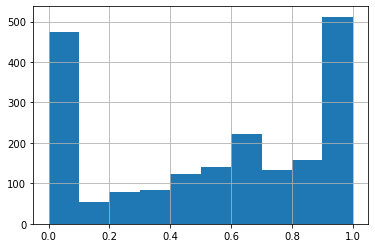

In [100]:
# Projects with probabilities = nan are found to be because they have no usage data other than a record of settled=0
# Hence, their probabilities are filled with 0
sus_probofsus = pd.Series(sus_probofsus).fillna(0)
sus_probofsus.hist()

In [101]:
nosus_probofsus = list()
for i in range(len(bbr_dlnosus_df.columns)):
    alignment = dtw(list(bbr_dlnosus_df.iloc[:,i].dropna()), template)
    y = alignment.index2
    x = alignment.index1
    prob = 1 - (abs(auc(x,y) - 0.5*max(y)*min(max(x),max(y)))/(max(x)*max(y) - 0.5*max(y)*min(max(x),max(y))))
    nosus_probofsus.append(prob)
    print(i, prob)

0 0.410942506949203
1 0.9737001520892945
2 0.755994988369423
3 0.8352042260586646
4 0.8313737212700943
5 0.39043839341491204
6 0.6770550620939222
7 0.1543169508861948
8 0.540022585359373
9 0.34539230199851967
10 0.5739575622995312
11 0.771531375935521
12 0.3281003125799711
13 0.6692141623488774
14 0.4392715635476989
15 0.41947322970639034
16 0.6565766748477411
17 0.9721668659492494
18 0.9425909069691453
19 0.8515958374766665
20 0.22744590064004877
21 0.6170429311621022
22 0.5052616003491014
23 0.32317714199894876
24 0.9891027222633441
25 0.6760642080666464
26 0.11262233736326999
27 0.6130575431093566
28 0.13684852179213658
29 0.27234147545028375
30 0.9293007358383768
31 0.8916391898257183
32 0.9097693825421578
33 0.32018806371137976
34 0.8615005587727319
35 0.5628111348166209
36 0.8537930118241
37 0.25095453014848845
38 0.4636226252158895
39 0.9166858568412972
40 0.3957493763193245
41 0.9978411053540587
42 0.19940990213010934
43 0.42785883101536226
44 0.7446159044829916
45 0.7821243523

360 0.016191709844559532
361 0.9926597582037997
362 0.6625647668393783
363 0.6768854346574553
364 0.7945595854922279
365 0.6732512953367875
366 0.015831894070235997
367 0.9926597582037997
368 0.4126943005181347
369 0.7945595854922279
370 0.0017271157167529916
371 0.5824080927707871
372 0.016407599309153698
373 0.5011873920552676
374 0.6768854346574553
375 0.9709192239580939
376 0.5680360226992351
377 0.016407599309153698
378 0.016407599309153698
379 0.9926597582037997
380 0.016407599309153698
381 0.0017271157167529916
382 0.13298791018998268
383 0.016407599309153698
384 0.8944540395317597
385 0.09347554477639364
386 0.016407599309153698
387 0.016407599309153698
388 0.9926597582037997
389 0.6623488773747841
390 0.015544041450777257
391 0.9926597582037997
392 0.016407599309153698
393 0.015831894070235997
394 0.6623488773747841
395 0.9926597582037997
396 0.9926597582037997
397 0.9926597582037997
398 0.9926597582037997
399 0.9926597582037997
400 0.6770293609671848
401 0.016407599309153698


711 0.9956822107081175
712 0.016407599309153698
713 0.016407599309153698
714 0.06840003181528953
715 0.9958981001727115
716 0.016407599309153698
717 0.9958981001727115
718 0.6665227403569373
719 0.6069948186528498
720 0.6665227403569373
721 0.9958981001727115
722 0.675014392630973
723 0.016407599309153698
724 0.9958981001727115
725 0.6663788140472078
726 0.016407599309153698
727 0.9958981001727115
728 0.016407599309153698
729 0.016407599309153698
730 0.9958981001727115
731 0.016407599309153698
732 0.510254749568221
733 0.6663788140472078
734 0.007772020725388629
735 0.016191709844559532
736 0.9956822107081175
737 0.016407599309153698
738 0.016407599309153698
739 0.01629965457685667
740 0.016407599309153698
741 0.9956822107081175
742 0.016407599309153698
743 0.9956822107081175
744 0.016407599309153698
745 0.016407599309153698
746 0.016407599309153698
747 0.3493789171210716
748 0.016407599309153698
749 0.675014392630973
750 0.9956822107081175
751 0.016407599309153698
752 0.01640759930915

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


918 nan
919 nan
920 0.05267702936096719
921 0.17801381692573404
922 nan
923 0.060017271157167484
924 0.01770293609671847
925 0.01770293609671847
926 0.021157167530224563
927 0.01770293609671847
928 nan
929 nan
930 nan
931 nan
932 nan
933 nan
934 nan
935 0.01770293609671847
936 nan
937 0.9853262629533679
938 nan
939 nan
940 nan
941 0.01770293609671847
942 nan
943 nan
944 nan
945 0.09184554650875898
946 0.9177432184999679
947 nan
948 0.2607207548759426
949 nan
950 nan
951 nan
952 nan
953 nan
954 nan
955 nan
956 nan
957 nan
958 nan
959 0.01770293609671847
960 0.01770293609671847
961 nan
962 nan
963 0.021157167530224563
964 nan
965 nan
966 0.022884283246977555
967 nan
968 nan
969 nan
970 nan
971 nan
972 nan
973 0.032037996545768554
974 nan
975 0.01770293609671847
976 0.022884283246977555
977 nan
978 nan
979 nan
980 0.022884283246977555
981 nan
982 0.021157167530224563
983 nan
984 0.022884283246977555
985 nan
986 nan
987 nan
988 0.01770293609671847
989 0.022884283246977555
990 nan
991 0.386

<AxesSubplot:>

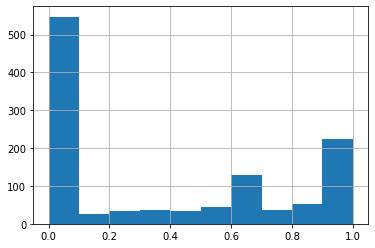

In [102]:
# Projects with probabilities = nan are found to be because they have no usage data other than a record of settled=0
# Hence, their probabilities are filled with 0
nosus_probofsus = pd.Series(nosus_probofsus).fillna(0)
nosus_probofsus.hist()

In [103]:
bbr_dlsuscount['cheatingprob_dlpattern'] = sus_probofsus
bbr_dlsuscount

project_id  dl_cancel_count  \
0     8118cf7c11224ffda2284716de755d21             8238   
1     a56224e6a3f943baa6791431d2711271              260   
2     0276add01fd94ae484e926afe29a031a              147   
3     75ba7cc203b3411d8cb5f62e9a1286b7              132   
4     50ce9633c7ab4abd9c12c9be63d6665e              125   
...                                ...              ...   
1974  69dc0cb12002472d905a7647981757e8                1   
1975  69d85e47154f4733a08c9a885319fd80                1   
1976  69bd1fd778f4431bb59b2b5ecec372b8                1   
1977  69a353f2ac9e4c3eb81e38f7cb9a10e5                1   
1978  fff103d31b114502a51ef83a52293e84                1   

      cheatingprob_dlpattern  
0                   0.640014  
1                   0.810328  
2                   0.613393  
3                   0.592244  
4                   0.804405  
...                      ...  
1974                0.995898  
1975                0.015976  
1976                0.996546  
1977                0.015976  
1978                0.499568  

[1979 rows x 3 columns]

In [104]:
bbr_dlnosussum['cheatingprob_dlpattern'] = nosus_probofsus
bbr_dlnosussum

project_id      settled_sum  \
0     b617c07370a240ef938138ce4df3097d  109970738002432   
1     ca7a0f2e08944a508baeb6f278d88f3d   11134437815552   
2     36971dbb4d434790a6897bc8202fe08b    7298432770816   
3     321590f2b8294783bf21d76541b30f67    1248499906560   
4     4f14c095f79146ada0267da3e3748544     524110851328   
...                                ...              ...   
1157  4a55bdf457b64d21b44f66729813c501                0   
1158  bf11357da92b42e488f9f90b83b70e3f                0   
1159  4b00a32c776142118ca5312621c5238a                0   
1160  4b2b2cfadd7946f1b4ac80417a704a51                0   
1161  c5da7a0eaa754bfeb5908356bd01038e                0   

      cheatingprob_dlpattern  
0                   0.410943  
1                   0.973700  
2                   0.755995  
3                   0.835204  
4                   0.831374  
...                      ...  
1157                0.017703  
1158                0.000000  
1159                0.000000  
1160                0.000000  
1161                0.017703  

[1162 rows x 3 columns]

### Cheating Probabilities from Download Cancellation Counts

In [105]:
bbr_dlsuscount['cheatingprob_dlcancellation'] = bbr_dlsuscount.apply(lambda row: percentileofscore(bbr_dlsuscount['dl_cancel_count'], row['dl_cancel_count'])/100, axis=1)
bbr_dlsuscount

project_id  dl_cancel_count  \
0     8118cf7c11224ffda2284716de755d21             8238   
1     a56224e6a3f943baa6791431d2711271              260   
2     0276add01fd94ae484e926afe29a031a              147   
3     75ba7cc203b3411d8cb5f62e9a1286b7              132   
4     50ce9633c7ab4abd9c12c9be63d6665e              125   
...                                ...              ...   
1974  69dc0cb12002472d905a7647981757e8                1   
1975  69d85e47154f4733a08c9a885319fd80                1   
1976  69bd1fd778f4431bb59b2b5ecec372b8                1   
1977  69a353f2ac9e4c3eb81e38f7cb9a10e5                1   
1978  fff103d31b114502a51ef83a52293e84                1   

      cheatingprob_dlpattern  cheatingprob_dlcancellation  
0                   0.640014                     1.000000  
1                   0.810328                     0.999495  
2                   0.613393                     0.998989  
3                   0.592244                     0.998484  
4                   0.804405                     0.997979  
...                      ...                          ...  
1974                0.995898                     0.304194  
1975                0.015976                     0.304194  
1976                0.996546                     0.304194  
1977                0.015976                     0.304194  
1978                0.499568                     0.304194  

[1979 rows x 4 columns]

In [106]:
bbr_dlnosussum['cheatingprob_dlcancellation'] = 0
bbr_dlnosussum

project_id      settled_sum  \
0     b617c07370a240ef938138ce4df3097d  109970738002432   
1     ca7a0f2e08944a508baeb6f278d88f3d   11134437815552   
2     36971dbb4d434790a6897bc8202fe08b    7298432770816   
3     321590f2b8294783bf21d76541b30f67    1248499906560   
4     4f14c095f79146ada0267da3e3748544     524110851328   
...                                ...              ...   
1157  4a55bdf457b64d21b44f66729813c501                0   
1158  bf11357da92b42e488f9f90b83b70e3f                0   
1159  4b00a32c776142118ca5312621c5238a                0   
1160  4b2b2cfadd7946f1b4ac80417a704a51                0   
1161  c5da7a0eaa754bfeb5908356bd01038e                0   

      cheatingprob_dlpattern  cheatingprob_dlcancellation  
0                   0.410943                            0  
1                   0.973700                            0  
2                   0.755995                            0  
3                   0.835204                            0  
4                   0.831374                            0  
...                      ...                          ...  
1157                0.017703                            0  
1158                0.000000                            0  
1159                0.000000                            0  
1160                0.000000                            0  
1161                0.017703                            0  

[1162 rows x 4 columns]

In [107]:
bbr_dl_probs = bbr_dlsuscount[['project_id', 'cheatingprob_dlpattern', 'cheatingprob_dlcancellation']].append(bbr_dlnosussum[['project_id', 'cheatingprob_dlpattern', 'cheatingprob_dlcancellation']])
bbr_dl_probs

project_id  cheatingprob_dlpattern  \
0     8118cf7c11224ffda2284716de755d21                0.640014   
1     a56224e6a3f943baa6791431d2711271                0.810328   
2     0276add01fd94ae484e926afe29a031a                0.613393   
3     75ba7cc203b3411d8cb5f62e9a1286b7                0.592244   
4     50ce9633c7ab4abd9c12c9be63d6665e                0.804405   
...                                ...                     ...   
1157  4a55bdf457b64d21b44f66729813c501                0.017703   
1158  bf11357da92b42e488f9f90b83b70e3f                0.000000   
1159  4b00a32c776142118ca5312621c5238a                0.000000   
1160  4b2b2cfadd7946f1b4ac80417a704a51                0.000000   
1161  c5da7a0eaa754bfeb5908356bd01038e                0.017703   

      cheatingprob_dlcancellation  
0                        1.000000  
1                        0.999495  
2                        0.998989  
3                        0.998484  
4                        0.997979  
...                           ...  
1157                     0.000000  
1158                     0.000000  
1159                     0.000000  
1160                     0.000000  
1161                     0.000000  

[3141 rows x 3 columns]

## Uploads

In [108]:
bbr['month'] = bbr['interval_start'].dt.to_period('M')
bbr_ulsuscount = bbr[(bbr['inline']==0) & (bbr['settled']==0) & (bbr['action']==1)].groupby(['project_id', 'month']).agg({'settled':'count'}).sort_values(by='settled', ascending=False).reset_index()
bbr_ulsuscount = bbr_ulsuscount.drop_duplicates('project_id', keep='first').drop('month', axis=1).rename({'settled': 'ul_cancel_count'}, axis=1).reset_index(drop=True)
bbr_ulsuscount

project_id  ul_cancel_count
0     cc26c23f444849718e245092e49390ba              744
1     abeddf73ae1346bf8a982cbb5ec60d10              744
2     caad47a0bcff4eee8edeb861d9d4061a              744
3     79a5dc5865ad430392daf69e808e9ac7              703
4     a56224e6a3f943baa6791431d2711271              193
...                                ...              ...
2913  6e8cae8756504e2c8eeec0bb59a63817                1
2914  6ec5681cc63b4d68bfeb21c2276afcd4                1
2915  6ece2a5302d44e5fb05ab4ca619ea15d                1
2916  6ed90c32e5bb4e32bc84940d20d98805                1
2917  fff103d31b114502a51ef83a52293e84                1

[2918 rows x 2 columns]

In [109]:
bbr_ulsuscount['ul_cancel_count'].value_counts()

1      1896
2       450
3       166
4        85
5        62
6        32
7        28
10       22
9        16
8        14
11       13
17       12
13       10
19       10
14       10
15        8
12        7
23        6
18        6
20        5
21        5
28        4
24        4
33        3
29        3
16        3
22        3
744       3
26        3
32        2
25        2
193       1
125       1
65        1
63        1
59        1
57        1
51        1
47        1
43        1
41        1
37        1
30        1
31        1
182       1
27        1
34        1
40        1
42        1
54        1
70        1
76        1
86        1
100       1
106       1
703       1
Name: ul_cancel_count, dtype: int64

#### Observing usage patterns from suspected wallets

In [31]:
# Narrowing down bbr for future plotting purpose
bbr_upload = bbr[bbr['action']==1][['project_id', 'interval_start', 'settled']]
bbr_upload = bbr_upload.groupby(['interval_start','project_id']).aggregate({'settled': sum}).reset_index()
bbr_upload

interval_start                        project_id        settled
0      2020-06-16 14:00:00  09725ae44260437ea04c2eaa561cd9dd  3974125045504
1      2020-06-16 14:00:00  0de105efbc5d4944b567aa6ea90db9f9     2252339968
2      2020-06-16 14:00:00  19c87c6d894942d2a6f6cd5270df3654              0
3      2020-06-16 14:00:00  2e1e9468e497490d89544666a1760e3a   371949820416
4      2020-06-16 14:00:00  300af053503a42cfa6c1a90246c09d59   184689140224
...                    ...                               ...            ...
408920 2021-06-11 13:00:00  e6cd1b6ec6c042ccadf54429c52a6b96     6857341696
408921 2021-06-11 13:00:00  ecfbcbc52e854a7fa970454c02785bfe        4972544
408922 2021-06-11 13:00:00  eddb79195f3241c884df12ea93b44529       70024704
408923 2021-06-11 13:00:00  f66f04c5c17743f780f75f274e00ff1b      124356352
408924 2021-06-11 13:00:00  f7877e7be74d4e9a8f2c7b90d0935cf5        1115904

[408925 rows x 3 columns]

In [32]:
# Focusing first on projects with more than 50 times upload cancellations
bbr_ulsusproj1 = bbr_ulsuscount[bbr_ulsuscount['ul_cancel_count']>50]
bbr_ulsusproj1

project_id  ul_cancel_count
0   cc26c23f444849718e245092e49390ba              744
1   abeddf73ae1346bf8a982cbb5ec60d10              744
2   caad47a0bcff4eee8edeb861d9d4061a              744
3   79a5dc5865ad430392daf69e808e9ac7              703
4   a56224e6a3f943baa6791431d2711271              193
5   91c84be747f34cccb0363d4fd8242e3d              182
6   86c08c2fbd75448d824019e80bc9acbe              125
7   2417ab05b502446dbd0795c37668a723              106
8   d2adb8afbe11450f92eb17715cc18312              100
9   50ce9633c7ab4abd9c12c9be63d6665e               86
10  276d649ffb4149c18c48d0b7de487aec               76
11  9f28c45fa04249da955042dc28d7f2a8               70
12  c2b2ee61bd46445a85deeb1a7644d00b               65
13  879379eb3543450ba03b7b5e7c222265               63
14  74f0eacad7e8489b9b495351788c9c88               59
15  147d9aff4856497083bcd054694394f2               57
16  c91610461d1e4bc4815c71f8c2f212d8               54
17  6a0c2e967df34f0298b61814949c3fc4               51

In [33]:
bbr_ulsusproj1_df = bbr_upload[bbr_upload['project_id'].isin(list(bbr_ulsusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_ulsusproj1_df = bbr_ulsusproj1_df[list(bbr_ulsusproj1['project_id'])]
bbr_ulsusproj1_df

project_id           cc26c23f444849718e245092e49390ba  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               0.0   
2021-06-11 10:00:00                               0.0   
2021-06-11 11:00:00                               0.0   
2021-06-11 12:00:00                               0.0   
2021-06-11 13:00:00                               0.0   

project_id           abeddf73ae1346bf8a982cbb5ec60d10  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               0.0   
2021-06-11 10:00:00                               0.0   
2021-06-11 11:00:00                               0.0   
2021-06-11 12:00:00                               0.0   
2021-06-11 13:00:00                               0.0   

project_id           caad47a0bcff4eee8edeb861d9d4061a  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               0.0   
2021-06-11 10:00:00                               0.0   
2021-06-11 11:00:00                               0.0   
2021-06-11 12:00:00                               0.0   
2021-06-11 13:00:00                               0.0   

project_id           79a5dc5865ad430392daf69e808e9ac7  \
interval_start                                          
2020-06-16 14:00:00                         2253824.0   
2020-06-16 15:00:00                         4838400.0   
2020-06-16 16:00:00                         3479552.0   
2020-06-16 17:00:00                         2225408.0   
2020-06-16 18:00:00                            4096.0   
...                                               ...   
2021-06-11 09:00:00                        63915776.0   
2021-06-11 10:00:00                       262714112.0   
2021-06-11 11:00:00                        82175488.0   
2021-06-11 12:00:00                       158390016.0   
2021-06-11 13:00:00                        27892480.0   

project_id           a56224e6a3f943baa6791431d2711271  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           91c84be747f34cccb0363d4fd8242e3d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-

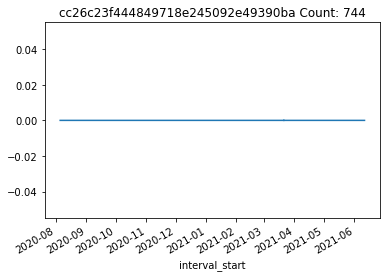

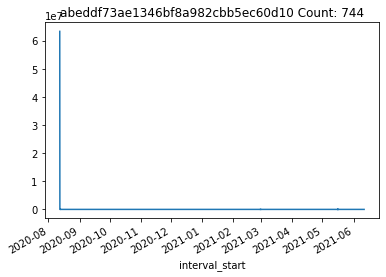

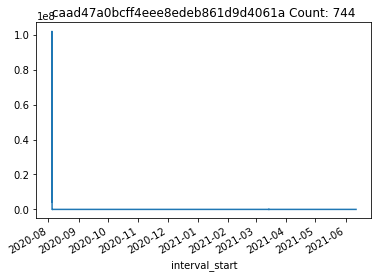

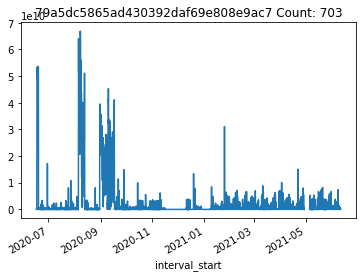

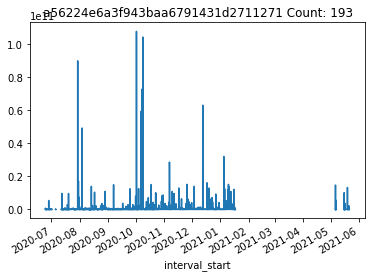

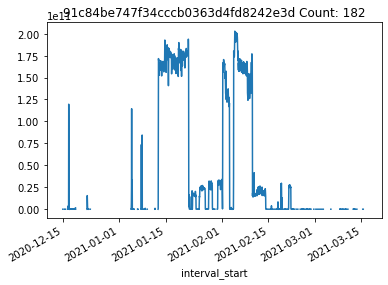

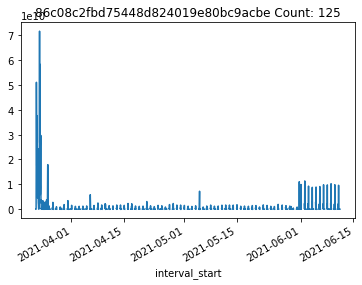

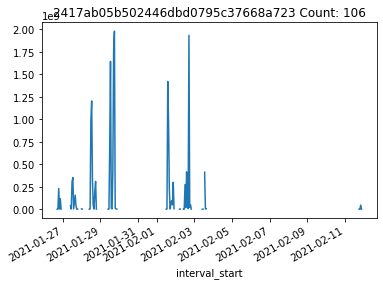

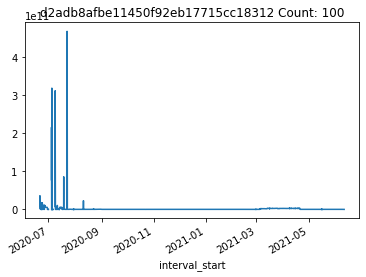

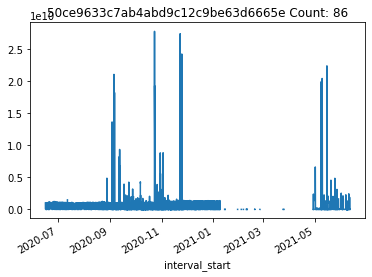

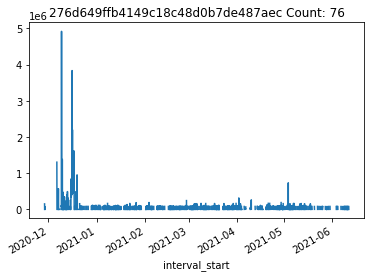

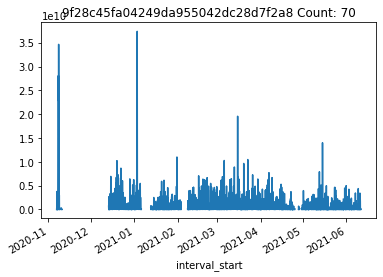

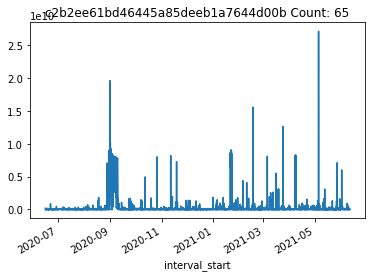

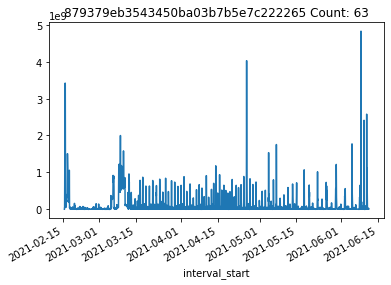

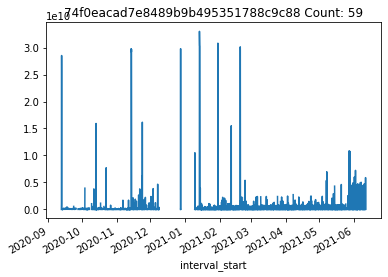

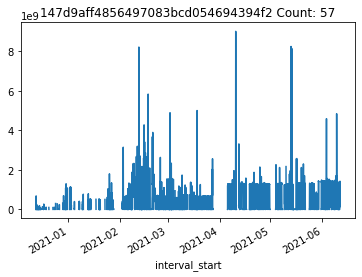

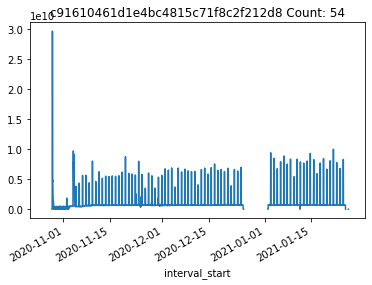

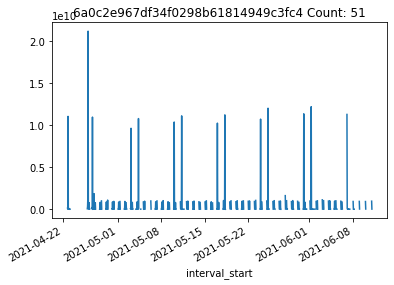

In [34]:
for i in range(len(bbr_ulsusproj1_df.columns)):
    proj_id = bbr_ulsusproj1.loc[i, 'project_id']
    cancel_count = bbr_ulsusproj1.loc[i, 'ul_cancel_count']
    plt.figure()
    bbr_ulsusproj1_df.iloc[:,i].plot(title=proj_id + ' Count: ' + str(cancel_count))

The first and third plots look quite suspiciously similar -- to be looked into manually and checked if the projets belong to the same user.

#### Comparing to non-suspected projects' usage patterns

In [35]:
bbr_ulnosussum = bbr_upload[~bbr_upload['project_id'].isin(list(bbr_ulsuscount['project_id']))].groupby('project_id').agg({'settled':'sum'}).sort_values(by='settled', ascending=False)
bbr_ulnosussum = bbr_ulnosussum.rename({'settled': 'settled_sum'}, axis=1).reset_index()
bbr_ulnosussum

project_id       settled_sum
0     300af053503a42cfa6c1a90246c09d59  2045121573532672
1     2e1e9468e497490d89544666a1760e3a  1983166538025984
2     c2958c3bbd9645fbb2a420c93dd6abc1  1935589431612672
3     b617c07370a240ef938138ce4df3097d   458557632795648
4     09725ae44260437ea04c2eaa561cd9dd   147002996323840
...                                ...               ...
1973  248a75d2d1d745efa28297fca941a5a7                 0
1974  a8b4ea927655434cbf50fa54b3648cd4                 0
1975  4f3b801f2403479295362aa9af96730f                 0
1976  4edfab0fa12748a9a18fffb1957e93bd                 0
1977  814395d601db424094f9c905b7c7f012                 0

[1978 rows x 2 columns]

In [36]:
# Zooming in first to the top 20 projects with highest total amount settled
bbr_ulnosusproj1 = bbr_ulnosussum.loc[:20,:]
bbr_ulnosusproj1

project_id       settled_sum
0   300af053503a42cfa6c1a90246c09d59  2045121573532672
1   2e1e9468e497490d89544666a1760e3a  1983166538025984
2   c2958c3bbd9645fbb2a420c93dd6abc1  1935589431612672
3   b617c07370a240ef938138ce4df3097d   458557632795648
4   09725ae44260437ea04c2eaa561cd9dd   147002996323840
5   62397406ab88417e81ceb8de2809b08d    86395225019136
6   4f14c095f79146ada0267da3e3748544    11184746991872
7   22406ed8e061445ab6b911d6342addef    10982480757248
8   4aea0d3bc32f420e90b32ba75683f5f4     9355158792192
9   f7b6622a075240e687d18e18902f3aec     5928556076032
10  49374c285fa94908a72d489d69ff4d83     4183827401472
11  b2d7098ff18b4c55b05ca43b3bc5003e     2867838013184
12  6747e36a5d2347fb8e47ffde3065c2a1     2798567840768
13  2b6aa64399d04cf5975497af8ebdf36f     2750314046976
14  c8c8cadc3cc94b4ea66c5bbd847e00ca     2647264476672
15  91c10674a98e464c927ea4ba0992db0b     1984673731072
16  a8c3ce16e8604fdb8e3dd51b115784b0     1842107759872
17  381d49e81347429da04836223af88543     1739793517568
18  165c035806df4c5f94c2bac6a15c6624     1412043261696
19  39a3967982ed44b280f8fa0e807bdd9e     1285106083840
20  c443e6d24a9b4a56bbbb5e56c136520f     1198383115776

In [37]:
bbr_ulnosus1_df = bbr_upload[bbr_upload['project_id'].isin(list(bbr_ulnosusproj1['project_id']))].pivot(index='interval_start', columns='project_id', values='settled')
bbr_ulnosus1_df = bbr_ulnosus1_df[list(bbr_ulnosusproj1['project_id'])]
bbr_ulnosus1_df

project_id           300af053503a42cfa6c1a90246c09d59  \
interval_start                                          
2020-06-16 14:00:00                      1.846891e+11   
2020-06-16 15:00:00                      2.751137e+11   
2020-06-16 16:00:00                      2.660055e+11   
2020-06-16 17:00:00                      2.657250e+11   
2020-06-16 18:00:00                      2.043862e+11   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           2e1e9468e497490d89544666a1760e3a  \
interval_start                                          
2020-06-16 14:00:00                      3.719498e+11   
2020-06-16 15:00:00                      2.726815e+11   
2020-06-16 16:00:00                      2.388429e+11   
2020-06-16 17:00:00                      2.048695e+11   
2020-06-16 18:00:00                      2.493415e+11   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           c2958c3bbd9645fbb2a420c93dd6abc1  \
interval_start                                          
2020-06-16 14:00:00                      3.022376e+11   
2020-06-16 15:00:00                      2.026051e+11   
2020-06-16 16:00:00                      2.193669e+11   
2020-06-16 17:00:00                      2.973104e+11   
2020-06-16 18:00:00                      2.795219e+11   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           b617c07370a240ef938138ce4df3097d  \
interval_start                                          
2020-06-16 14:00:00                               NaN   
2020-06-16 15:00:00                               NaN   
2020-06-16 16:00:00                               NaN   
2020-06-16 17:00:00                               NaN   
2020-06-16 18:00:00                               NaN   
...                                               ...   
2021-06-11 09:00:00                      1.479818e+11   
2021-06-11 10:00:00                      1.444762e+11   
2021-06-11 11:00:00                      1.789124e+11   
2021-06-11 12:00:00                      1.077623e+11   
2021-06-11 13:00:00                      1.668215e+10   

project_id           09725ae44260437ea04c2eaa561cd9dd  \
interval_start                                          
2020-06-16 14:00:00                      3.974125e+12   
2020-06-16 15:00:00                      4.128906e+12   
2020-06-16 16:00:00                      3.903861e+12   
2020-06-16 17:00:00                      3.957360e+12   
2020-06-16 18:00:00                      3.934514e+12   
...                                               ...   
2021-06-11 09:00:00                               NaN   
2021-06-11 10:00:00                               NaN   
2021-06-11 11:00:00                               NaN   
2021-06-11 12:00:00                               NaN   
2021-06-11 13:00:00                               NaN   

project_id           62397406ab88417e81ceb8de2809b08d  \
interval_start                                          
2020-06-16 14:00:00                      1.215518e+10   
2020-06-16 15:00:00                      1.244445e+10   
2020-06-16 16:00:00                      1.255364e+10   
2020-

E:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


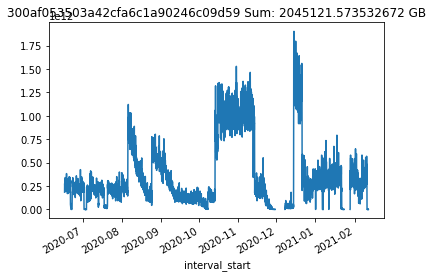

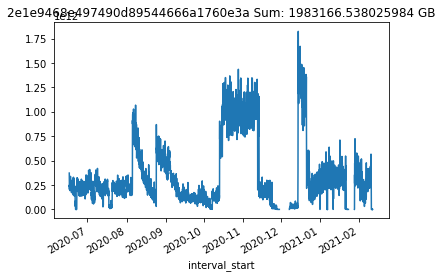

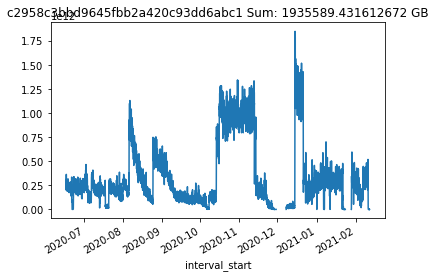

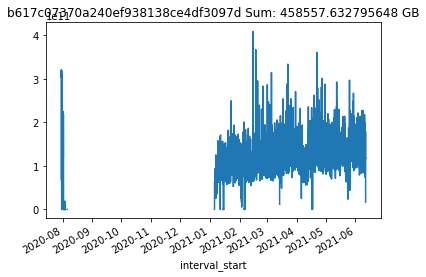

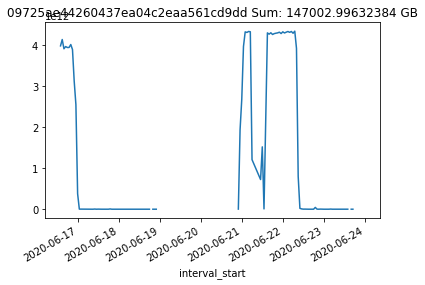

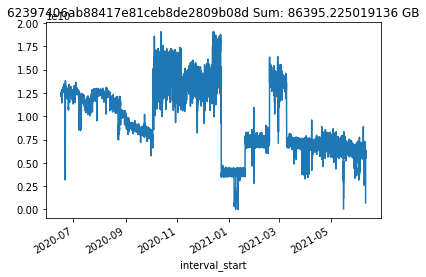

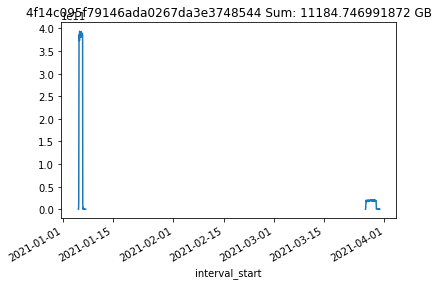

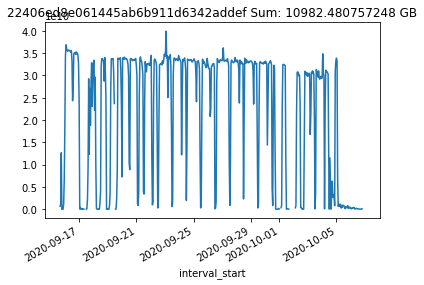

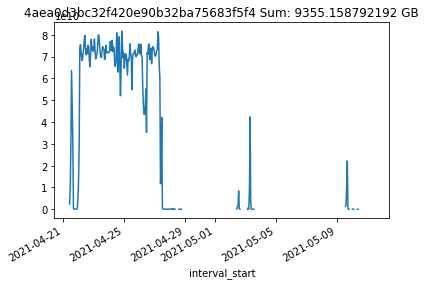

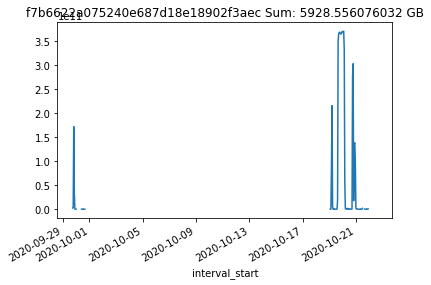

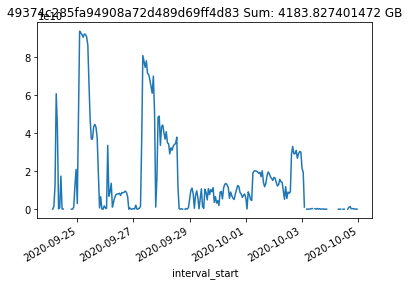

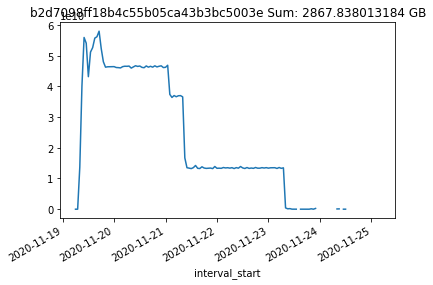

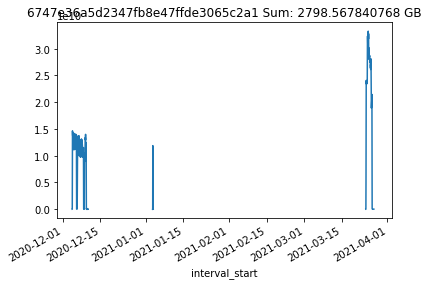

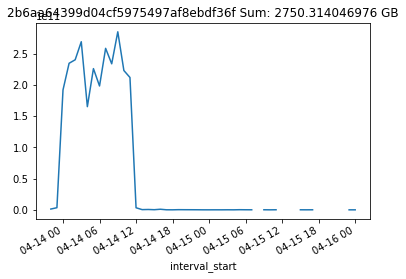

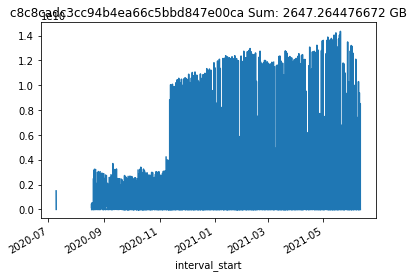

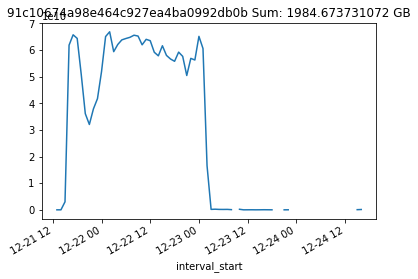

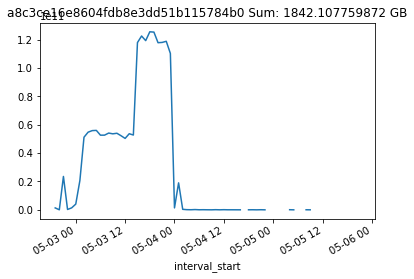

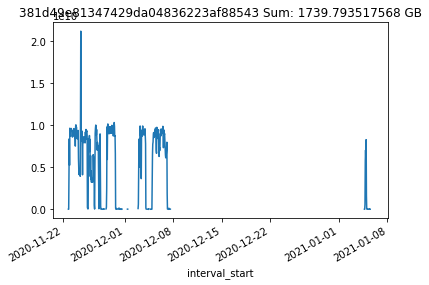

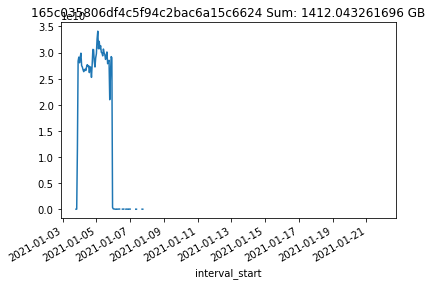

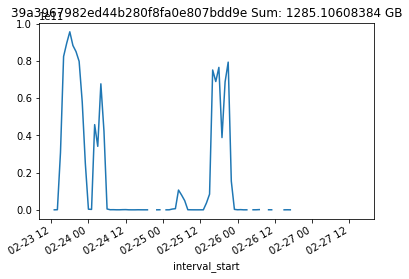

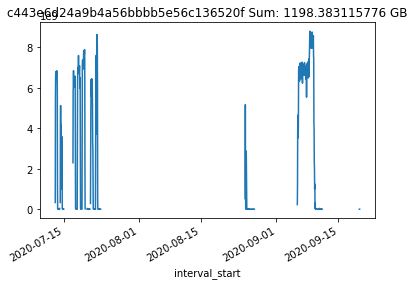

In [38]:
for i in range(len(bbr_ulnosus1_df.columns)):
    proj_id = bbr_ulnosusproj1.loc[i, 'project_id']
    settled_sum = bbr_ulnosusproj1.loc[i, 'settled_sum']/1e9
    plt.figure()
    bbr_ulnosus1_df.iloc[:,i].plot(title=proj_id + ' Sum: ' + str(settled_sum) + ' GB')

The first, second and third plots look very suspiciously similar -- to be looked into manually and checked if the projets belong to the same user.

In [39]:
for i in range(3):
    proj_id = bbr_ulnosusproj1.loc[i, 'project_id']
    print(proj_id)

300af053503a42cfa6c1a90246c09d59
2e1e9468e497490d89544666a1760e3a
c2958c3bbd9645fbb2a420c93dd6abc1


Unlike in the download patterns, both suspects and non-suspects seem to have the "combing" pattern in their usages, and I don't see any other distinguishing patterns between suspects and non-suspects. Hence, the upload pattern detection portion will not be performed for uploads.

### Cheating Probabilities from Upload Cancellation Counts

In [110]:
bbr_ulsuscount['cheatingprob_ulcancellation'] = bbr_ulsuscount.apply(lambda row: percentileofscore(bbr_ulsuscount['ul_cancel_count'], row['ul_cancel_count'])/100, axis=1)
bbr_ulsuscount

project_id  ul_cancel_count  \
0     cc26c23f444849718e245092e49390ba              744   
1     abeddf73ae1346bf8a982cbb5ec60d10              744   
2     caad47a0bcff4eee8edeb861d9d4061a              744   
3     79a5dc5865ad430392daf69e808e9ac7              703   
4     a56224e6a3f943baa6791431d2711271              193   
...                                ...              ...   
2913  6e8cae8756504e2c8eeec0bb59a63817                1   
2914  6ec5681cc63b4d68bfeb21c2276afcd4                1   
2915  6ece2a5302d44e5fb05ab4ca619ea15d                1   
2916  6ed90c32e5bb4e32bc84940d20d98805                1   
2917  fff103d31b114502a51ef83a52293e84                1   

      cheatingprob_ulcancellation  
0                        0.999657  
1                        0.999657  
2                        0.999657  
3                        0.998972  
4                        0.998629  
...                           ...  
2913                     0.325051  
2914                     0.325051  
2915                     0.325051  
2916                     0.325051  
2917                     0.325051  

[2918 rows x 3 columns]

In [111]:
bbr_ulnosussum['cheatingprob_ulcancellation'] = 0
bbr_ulnosussum

project_id       settled_sum  \
0     300af053503a42cfa6c1a90246c09d59  2045121573532672   
1     2e1e9468e497490d89544666a1760e3a  1983166538025984   
2     c2958c3bbd9645fbb2a420c93dd6abc1  1935589431612672   
3     b617c07370a240ef938138ce4df3097d   458557632795648   
4     09725ae44260437ea04c2eaa561cd9dd   147002996323840   
...                                ...               ...   
1973  248a75d2d1d745efa28297fca941a5a7                 0   
1974  a8b4ea927655434cbf50fa54b3648cd4                 0   
1975  4f3b801f2403479295362aa9af96730f                 0   
1976  4edfab0fa12748a9a18fffb1957e93bd                 0   
1977  814395d601db424094f9c905b7c7f012                 0   

      cheatingprob_ulcancellation  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
...                           ...  
1973                            0  
1974                            0  
1975                            0  
1976                            0  
1977                            0  

[1978 rows x 3 columns]

In [112]:
bbr_ul_probs = bbr_ulsuscount[['project_id', 'cheatingprob_ulcancellation']].append(bbr_ulnosussum[['project_id', 'cheatingprob_ulcancellation']])
bbr_ul_probs

project_id  cheatingprob_ulcancellation
0     cc26c23f444849718e245092e49390ba                     0.999657
1     abeddf73ae1346bf8a982cbb5ec60d10                     0.999657
2     caad47a0bcff4eee8edeb861d9d4061a                     0.999657
3     79a5dc5865ad430392daf69e808e9ac7                     0.998972
4     a56224e6a3f943baa6791431d2711271                     0.998629
...                                ...                          ...
1973  248a75d2d1d745efa28297fca941a5a7                     0.000000
1974  a8b4ea927655434cbf50fa54b3648cd4                     0.000000
1975  4f3b801f2403479295362aa9af96730f                     0.000000
1976  4edfab0fa12748a9a18fffb1957e93bd                     0.000000
1977  814395d601db424094f9c905b7c7f012                     0.000000

[4896 rows x 2 columns]

## Combining Download and Upload Results

In [113]:
bbr_probs = bbr_dl_probs.merge(bbr_ul_probs, how='outer', on='project_id').fillna(0)
bbr_probs

project_id  cheatingprob_dlpattern  \
0     8118cf7c11224ffda2284716de755d21                0.640014   
1     a56224e6a3f943baa6791431d2711271                0.810328   
2     0276add01fd94ae484e926afe29a031a                0.613393   
3     75ba7cc203b3411d8cb5f62e9a1286b7                0.592244   
4     50ce9633c7ab4abd9c12c9be63d6665e                0.804405   
...                                ...                     ...   
4900  a7b165e53f6144ebb5fdf93635327a2a                0.000000   
4901  248a75d2d1d745efa28297fca941a5a7                0.000000   
4902  a8b4ea927655434cbf50fa54b3648cd4                0.000000   
4903  4f3b801f2403479295362aa9af96730f                0.000000   
4904  814395d601db424094f9c905b7c7f012                0.000000   

      cheatingprob_dlcancellation  cheatingprob_ulcancellation  
0                        1.000000                     0.325051  
1                        0.999495                     0.998629  
2                        0.998989                     0.727039  
3                        0.998484                     0.946025  
4                        0.997979                     0.996916  
...                           ...                          ...  
4900                     0.000000                     0.000000  
4901                     0.000000                     0.000000  
4902                     0.000000                     0.000000  
4903                     0.000000                     0.000000  
4904                     0.000000                     0.000000  

[4905 rows x 4 columns]

In [114]:
bbr_probs['cheatingprob'] = bbr_probs.apply(lambda row: 0.2 * row['cheatingprob_dlpattern'] + 0.6 * row['cheatingprob_dlcancellation'] + 0.2 * row['cheatingprob_ulcancellation'], axis=1)
bbr_probs = bbr_probs.sort_values(by='cheatingprob', ascending=False).reset_index(drop=True)
bbr_probs

project_id  cheatingprob_dlpattern  \
0     6a0c2e967df34f0298b61814949c3fc4                0.987353   
1     d1c8f2afeca542c8ba544c02803a045d                0.984746   
2     22c86abe69a845178764dec325a59dfe                0.989274   
3     a5a35931913941daaf4553721eeb5263                0.938358   
4     d346180ab62e4142aeb0d34a31fdd382                0.907142   
...                                ...                     ...   
4900  4111f6b7810f4152868940b837a1c105                0.000000   
4901  9a9a56f24d524b8187809acd29f3b13b                0.000000   
4902  317315b6dd8742ebab8a0d2da2fefce8                0.000000   
4903  cd86e4261fe0488eb4c9e8751585e3b1                0.000000   
4904  814395d601db424094f9c905b7c7f012                0.000000   

      cheatingprob_dlcancellation  cheatingprob_ulcancellation  cheatingprob  
0                        0.991410                     0.994174      0.991151  
1                        0.987873                     0.939513      0.977576  
2                        0.989641                     0.927176      0.977075  
3                        0.981809                     0.982351      0.973227  
4                        0.992926                     0.972413      0.971666  
...                           ...                          ...           ...  
4900                     0.000000                     0.000000      0.000000  
4901                     0.000000                     0.000000      0.000000  
4902                     0.000000                     0.000000      0.000000  
4903                     0.000000                     0.000000      0.000000  
4904                     0.000000                     0.000000      0.000000  

[4905 rows x 5 columns]

In [115]:
len(bbr['project_id'].unique())

4905

In [116]:
# (Optional) Export project probs to csv
# bbr_probs.to_csv('data/project_prob.csv', index=False)

In [123]:
bbr_probs[bbr_probs['cheatingprob']>0.95].reset_index()

index                        project_id  cheatingprob_dlpattern  \
0       0  6a0c2e967df34f0298b61814949c3fc4                0.987353   
1       1  d1c8f2afeca542c8ba544c02803a045d                0.984746   
2       2  22c86abe69a845178764dec325a59dfe                0.989274   
3       3  a5a35931913941daaf4553721eeb5263                0.938358   
4       4  d346180ab62e4142aeb0d34a31fdd382                0.907142   
5       5  879379eb3543450ba03b7b5e7c222265                0.869795   
6       6  db34f21f987044eaaadb13f516b79f5c                0.934678   
7       7  b0db94a2dffa4285a31b554eabb5b6d0                0.982293   
8       8  3fea758a588a40878635410e602e9a4d                0.925866   
9       9  ad88408f56eb41f883f2434a51eeddd0                0.976071   
10     10  9f28c45fa04249da955042dc28d7f2a8                0.846923   
11     11  20b5b0dd271a4e8bbfe33b98fa8d61c8                0.976883   
12     12  2417ab05b502446dbd0795c37668a723                0.846587   
13     13  c2b2ee61bd46445a85deeb1a7644d00b                0.854731   
14     14  a56224e6a3f943baa6791431d2711271                0.810328   
15     15  1381a886397e4bf7bacae51ea7d30958                0.940726   
16     16  d34568a584654cdebb4968d50e0a2b58                0.963639   
17     17  eb5e0d70cf154da39c1358aa2dde24e7                0.966939   
18     18  59eddba1ef384f98baa61486ca1e9e30                0.933017   
19     19  50ce9633c7ab4abd9c12c9be63d6665e                0.804405   
20     20  f7bffe74dc2545a6a1d7f02e594896bc                0.971478   
21     21  3e43ce6e796d4c12966465bc90ff893d                0.941033   
22     22  dcbfc4b46bb247e7bf74379cd033cd0d                0.936932   
23     23  3435eb25dc794ff8b7e65448abc366d7                0.941803   
24     24  ae9822fdefe844e8ab6a5a10094d9083                0.985491   
25     25  95fbc35e072f4bd094953195154d4515                0.904273   
26     26  fe5e9e6f5f424c0792c2a4579f0c8f67                0.945436   
27     27  33821f4fc42745f0b5df832f161a9a1e                0.907764   

    cheatingprob_dlcancellation  cheatingprob_ulcancellation  cheatingprob  
0                      0.991410                     0.994174      0.991151  
1                      0.987873                     0.939513      0.977576  
2                      0.989641                     0.927176      0.977075  
3                      0.981809                     0.982351      0.973227  
4                      0.992926                     0.972413      0.971666  
5                      0.997473                     0.995545      0.971552  
6                      0.994442                     0.927176      0.969036  
7                      0.963618                     0.961789      0.966987  
8                      0.978777                     0.969328      0.966305  
9                      0.959576                     0.964873      0.963934  
10                     0.991915                     0.996230      0.963780  
11                     0.955533                     0.972413      0.963179  
12                     0.990399                     0.997601      0.963077  
13                     0.987367                     0.995888      0.962544  
14                     0.999495                     0.998629      0.961488  
15                     0.966397                     0.966758      0.961335  
16                     0.955533                     0.969328      0.959913  
17                     0.955533                     0.964873      0.959682  
18                     0.959576                     0.984064      0.959162  
19                     0.997979                     0.996916      0.959051  
20                     0.947196                     0.975154      0.957644  
21                     0.963618                     0.952022      0.956782  
22                     0.955533                     0.975154      0.955737  
23                     0.951238                     0.972413      0.953586  
24                 

## Translating Projects to User IDs

In [7]:
# bbr_probs = pd.read_csv('data/usageanalysis_project_cheatingprobs.csv')
# bbr_probs

In [118]:
# Collating project data to map project_id and user_id
ap_projects = pd.read_csv('data/ap_projects.csv', usecols=['project_id', 'user_id'])
eu_projects = pd.read_csv('data/eu_projects.csv', usecols=['project_id', 'user_id'])
us_projects = pd.read_csv('data/us_projects.csv', usecols=['project_id', 'user_id'])

projects = ap_projects.append(eu_projects).append(us_projects).reset_index(drop=True)
projects['project_id'] = projects['project_id'].astype(str).str.lower()
projects['user_id'] = projects['user_id'].astype(str).str.lower()

projects

project_id                           user_id
0      000063c2965d4edbb0c0133e975196b9  6788221dd7a0428297b92cdcf976a4e9
1      00249f5ffb204d7fa5daf177cde046a5  c02783dd81c54674a4299858c08aa1a6
2      004346f3795a44769852623266c89ad3  668098dc3c334a9aae644b2294f7c4aa
3      0044787a0dd54a6eaf0f71f85fe9b751  0319b622f638494cae46937101ed1f70
4      0044d8c953ad44b183eb5f2e146f0749  1dac3d07be024def813b0f039f9fb781
...                                 ...                               ...
16431  ffc45d28750b4993b2b2f64a65eaf68b  f283eef8ba044b9884eef89ece8042f1
16432  ffdb80310efd419e9219d579e549d145  97c5b2b48679499f9aa921f3f196694b
16433  ffdfddcb34c14530a210768cd2f2d216  b3cfe396ac6f4e8daefde945a797c84f
16434  ffe38650d8d14cbd9fb25ad5b3914c3d  1c2922226f5a439eab1fb235f3df7119
16435  fff9f3939d2f4487bab1726f13144dce  3670e77cf3494b05b8ad927760fbb2bc

[16436 rows x 2 columns]

In [119]:
# Checking for duplicated project_id
projects.duplicated('project_id', keep=False).sum()

0

In [120]:
user_probs = bbr_probs.merge(projects, how='left', on='project_id')
user_probs = user_probs.groupby('user_id').agg({'project_id': 'count', 'cheatingprob': ['max', 'mean'], 'cheatingprob_dlpattern':'max', 'cheatingprob_dlcancellation':'max','cheatingprob_ulcancellation':'max'}).reset_index()
user_probs.columns = ['_'.join(col).rstrip('_') for col in user_probs.columns.values]
user_probs = user_probs.rename({'project_id_count': 'project_count'}, axis=1).sort_values('project_count', ascending=False).reset_index(drop=True)
user_probs

user_id  project_count  cheatingprob_max  \
0     8e80107a40cf4cdbb5eb038138fc6666             11          0.929031   
1     ac22374d11f64a6889c80ec20b2f3455             10          0.963179   
2     de9435a13a1e406d9b6caad826a31650              9          0.884777   
3     d0f15f92267d43ee9f3b1457f80ca568              6          0.963077   
4     0967521845444799adbb043b7f211b6d              6          0.971666   
...                                ...            ...               ...   
3989  5871eca8f7d0454b952043253e4bb3b6              1          0.000000   
3990  58a493d2b56d46b5a4cd6b406dc461d7              1          0.065010   
3991  58aa2f2d387744809e452e39003c30c0              1          0.000000   
3992  58c05cc53e504801995675c3ab217591              1          0.380831   
3993  ffff6206eb6e4eee909dc9ffa9ca0307              1          0.065010   

      cheatingprob_mean  cheatingprob_dlpattern_max  \
0              0.358427                    0.969412   
1              0.948943                    0.976883   
2              0.289871                    0.853333   
3              0.502080                    0.985326   
4              0.652560                    0.992660   
...                 ...                         ...   
3989           0.000000                    0.000000   
3990           0.065010                    0.000000   
3991           0.000000                    0.000000   
3992           0.380831                    0.666523   
3993           0.065010                    0.000000   

      cheatingprob_dlcancellation_max  cheatingprob_ulcancellation_max  
0                            0.912077                         0.989719  
1                            0.959576                         0.977724  
2                            0.966397                         0.900788  
3                            0.990399                         0.997601  
4                            0.998989                         0.972413  
...                               ...                              ...  
3989                         0.000000                         0.000000  
3990                         0.000000                         0.325051  
3991                         0.000000                         0.000000  
3992                         0.304194                         0.325051  
3993                         0.000000                         0.325051  

[3994 rows x 7 columns]

In [121]:
user_probs2 = bbr_probs.merge(projects, how='outer', on='project_id')
user_probs2 = user_probs2.groupby('user_id').agg({'project_id': 'count', 'cheatingprob': ['max', 'mean'], 'cheatingprob_dlpattern':'max', 'cheatingprob_dlcancellation':'max','cheatingprob_ulcancellation':'max'}).reset_index()
user_probs2.columns = ['_'.join(col).rstrip('_') for col in user_probs2.columns.values]
user_probs2 = user_probs2.rename({'project_id_count': 'project_count'}, axis=1).sort_values('project_count', ascending=False).reset_index(drop=True)
user_probs2

user_id  project_count  cheatingprob_max  \
0      de9435a13a1e406d9b6caad826a31650             51          0.884777   
1      8e80107a40cf4cdbb5eb038138fc6666             20          0.929031   
2      a0bb6eeb89db4224bd31c7e6d4fd755e             13          0.577420   
3      b98593dca5e84c748e0a090df68541b2             10          0.944550   
4      ac22374d11f64a6889c80ec20b2f3455             10          0.963179   
...                                 ...            ...               ...   
15174  57f0c930139f4c34b3158624e73c8e72              1               NaN   
15175  57f0df174c474924a7ba4a5a20920fe9              1               NaN   
15176  57f189674a1d4464b74d454951d16ada              1               NaN   
15177  57f1eecd7a90480599fac8a5b1f318cc              1          0.000000   
15178  ffff6206eb6e4eee909dc9ffa9ca0307              1          0.065010   

       cheatingprob_mean  cheatingprob_dlpattern_max  \
0               0.289871                    0.853333   
1               0.358427                    0.969412   
2               0.457936                    0.999136   
3               0.928300                    0.833244   
4               0.948943                    0.976883   
...                  ...                         ...   
15174                NaN                         NaN   
15175                NaN                         NaN   
15176                NaN                         NaN   
15177           0.000000                    0.000000   
15178           0.065010                    0.000000   

       cheatingprob_dlcancellation_max  cheatingprob_ulcancellation_max  
0                             0.966397                         0.900788  
1                             0.912077                         0.989719  
2                             0.683931                         0.832591  
3                             0.971450                         0.975154  
4                             0.959576                         0.977724  
...                                ...                              ...  
15174                              NaN                              NaN  
15175                              NaN                              NaN  
15176                              NaN                              NaN  
15177                         0.000000                         0.000000  
15178                         0.000000                         0.325051  

[15179 rows x 7 columns]

In [126]:
user_probs2[user_probs2['cheatingprob_max']>0.95].reset_index()

index                           user_id  project_count  cheatingprob_max  \
0       4  ac22374d11f64a6889c80ec20b2f3455             10          0.963179   
1       9  d0f15f92267d43ee9f3b1457f80ca568              8          0.963077   
2      13  0967521845444799adbb043b7f211b6d              6          0.971666   
3      64  85df11501f364111a113722ddb2928c5              3          0.951082   
4      88  fb5d9449fb1e40a7a015174b6239bd4e              3          0.950920   
5     333  745d7c4237114bf1b0d5803cf8073d39              2          0.977576   
6     488  290f71098664486390324d3257f2ef50              2          0.961488   
7     536  62e1ed08dcad43dfb99a356ce7d6ceb2              2          0.962544   
8     579  e6b2abe530b94633a7e6e3d47b3296c1              2          0.971552   
9     672  6bd31ddfc6c44dd4b99e6212bc88f892              2          0.969036   
10    799  09f0c043cc754b8092cfb1670734b2c7              2          0.966987   
11   2934  84ad533b64ff413da3d637ca73d8fadf              1          0.973227   
12   6205  c80dbe84a6fc4722a383ade5bd46fecf              1          0.991151   
13   7162  ddcb9a2da1f84edfb6ca78b43a4edabf              1          0.963780   
14   7191  dd4af5d8beab4bc18fcfbb9872c46f8c              1          0.963934   
15   9995  0ffc2ff7869c463abb96ed4cb570766e              1          0.959162   
16  10480  04e126ce1b294ecd9c2f566de0412c67              1          0.977075   
17  12778  802c3b172cc54c85967208399e5d25ac              1          0.961335   
18  14122  49ec7980c3024b828f63bfd0d1cd831c              1          0.966305   
19  14410  5aa0953d33b44fa9b6d229b28492f7c4              1          0.956782   

    cheatingprob_mean  cheatingprob_dlpattern_max  \
0            0.948943                    0.976883   
1            0.502080                    0.985326   
2            0.652560                    0.992660   
3            0.619276                    0.904273   
4            0.480969                    0.945436   
5            0.556260                    0.984746   
6            0.961488                    0.810328   
7            0.513777                    0.854731   
8            0.965302                    0.869795   
9            0.969036                    0.934678   
10           0.966987                    0.982293   
11           0.973227                    0.938358   
12           0.991151                    0.987353   
13           0.963780                    0.846923   
14           0.963934                    0.976071   
15           0.959162                    0.933017   
16           0.977075                    0.989274   
17           0.961335                    0.940726   
18           0.966305                    0.925866   
19           0.956782                    0.941033   

    cheatingprob_dlcancellation_max  cheatingprob_ulcancellation_max  
0                          0.959576                         0.977724  
1                          0.990399                         0.997601  
2                          0.998989                         0.972413  
3                          0.998484                         0.972413  
4                          0.951238                         0.955449  
5                          0.987873                         0.939513  
6                          0.999495                         0.998629  
7                          0.987367                         0.995888  
8                          0.997979                         0.996916  
9                          0.994442                         0.927176  
10                         0.963618                         0.961789  
11                         0.981809                         0.982351  
12                         0.991410                         0.994174  
13                         0.991915                         0.996230  
14                         0.959576                         0.964873  
15                         0.959576                         0.984064  
16

In [51]:
# (Optional) Export user probs to csv
# user_probs.to_csv('data/usageanalysis_user_cheatingprobs.csv', index=False)

In [122]:
# (Optional) Export user probs to csv
user_probs2.to_csv('data/user_combinedProb.csv', index=False)

It is recommended to refer to the `cheatingprob_max` column as the result.